# <u>Image classification: SVM, KNN, ANN, Random Forest (For Loop Version) </u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>

In [ ]:
# !pip install shapely
# !pip install geopandas
# !pip install fiona
# !pip install rasterstats
# !pip install spectral

In [10]:
import fiona
import random
import warnings
import argparse, os
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import numpy as np
import pandas as pd
from osgeo import ogr
from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image

import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.plot import adjust_band


import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import ndimage
from sklearn.svm import SVC
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from skimage.morphology import disk #manage disk while running.
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:

input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/S1/3band_/EW/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/S1/EW_GLCM_stack/"

rows, cols = 1000,1000
win_rows, win_cols = 5, 5


# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".tif"))

            with rio.open(input_path) as src:
                meta = src.profile
                bands = src.read()
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)


                minvalHH = np.percentile(b2, 2)
                maxvalHH = np.percentile(b2, 98)
                
                minvalHV = np.percentile(b3, 2)
                maxvalHV = np.percentile(b3, 98)
                
    #################### Product & Ratio ####################################
                
                prod = b2*b3
                rat = b3/b2
    
    ######################### Entropy #######################################
    
                b1_ = b1.astype('uint8')
                b2_ = b2.astype('uint8')
                b3_ = b3.astype('uint8')
                imgHH = b2_
                imgHV = b3_
                b1_ent = entropy(b1_, disk (10))
                b2_ent = entropy(b2_, disk (10))
                b3_ent = entropy(b3_, disk (10))
    
    ############################## Mean & SD ##################################
                
                win_meanHH = ndimage.uniform_filter(imgHH, (win_rows, win_cols))
                win_sqr_meanHH = ndimage.uniform_filter(imgHH**2, (win_rows, win_cols))
                win_varHH = win_sqr_meanHH - win_meanHH**2
                win_sdHH = np.sqrt(win_varHH)
                
                
                win_meanHV = ndimage.uniform_filter(imgHV, (win_rows, win_cols))
                win_sqr_meanHV = ndimage.uniform_filter(imgHV**2, (win_rows, win_cols))
                win_varHV = win_sqr_meanHV - win_meanHV**2
                win_sdHV = np.sqrt(win_varHV)
    
                
    ######################### Contrast ######################################
    
                b2_HH = np.clip(b2, minvalHH, maxvalHH)
                b2_HH = (((b2 - minvalHH) / (maxvalHH - minvalHH)) **2)*256
                
                b3_HV = np.clip(b3, minvalHV, maxvalHV)
                b3_HV = (((b3 - minvalHV) / (maxvalHV  - minvalHV)) **2)*256
    
    
    ######################### ASM ########################################
    
    
                b2_HH = np.clip(b2, minvalHH, maxvalHH)
                b2_HHA = b2_HH**2
                
                b3_HV = np.clip(b3, minvalHV, maxvalHV)
                b3_HVA = b3_HV**2 
    
    
    ######################### Energy ###################################
    
                b2_HH = np.clip(b2, minvalHH, maxvalHH)
                b2_HHA = b2_HH**2
                
                b3_HV = np.clip(b3, minvalHV, maxvalHV)
                b3_HVA = b3_HV**2 
                
                b2_HHE = b2_HHA**0.5
                b3_HVE = b3_HVA**0.5
    
    
    ################## Homogeneity ###################################
                
                b2_HH = np.clip(b2, minvalHH, maxvalHH)
                b2_HH = ((b2 - minvalHH) / (maxvalHH - minvalHH)) *256
                b2_HHOM = (1/(1+(abs(((b2 - minvalHH) / (maxvalHH - minvalHH)))**2))) #(1/(1+(b2 - minvalHH) / (maxvalHH - minvalHH)))*255 
    
                b3_HV = np.clip(b3, minvalHV, maxvalHV)
                b3_HV = ((b3 - minvalHV) / (maxvalHV  - minvalHV)) *256
                b3_VHOM =  (1/(1+(abs(((b3 - minvalHV) / (maxvalHV - minvalHV)))**2))) #(1/(1+(b3 - minvalHV) / (maxvalHV - minvalHV)))*255
    
    
    ################## Dissimilarity ##################################
    
                b2_HH = np.clip(b2, minvalHH, maxvalHH)
                b2_HHD = abs(((b2 - minvalHH) / (maxvalHH - minvalHH)))
                
                
                b3_HV = np.clip(b3, minvalHV, maxvalHV)
                b3_HVD = abs(((b3 - minvalHV) / (maxvalHV  - minvalHV)))
                
    
    ################## Correlation ##################################
    
                meanh, stdh = b2.mean(), b2.std()
                # global standardization of pixels
                pixH = (b2 - meanh) / stdh
                # clip pixel values to [-1,1] changed to [0,1]?
                pixH = np.clip(pixH, -1.0, 1.0)
                # shift from [-1,1] to [0,1]
                pixH = (pixH + 1.0) / 2
                
                meanv, stdv = b3.mean(), b3.std()
                pixV = (b3 - meanv) / stdv
                pixV = np.clip(pixV, -1.0, 1.0)
                pixV = (pixV + 1.0) / 2
                
                corrH = ((pixH-meanh)*(pixV-meanh))/((stdh*stdv))
                corrH = np.clip(corrH, -1.0, 1.0)
                corrV = ((pixH-meanv)*(pixV-meanv))/((stdv*stdh))
                corrV = np.clip(corrV, -1.0, 1.0)
    
    # Convert to int8
    
                prod = Image.fromarray(prod.astype(np.uint8))
                rat = Image.fromarray(rat.astype(np.uint8))
                b2ent8 = b2_ent.astype('uint8')
                b3ent8 = b3_ent.astype('uint8')
                varHH8 = Image.fromarray(win_varHH.astype(np.uint8))
                varHV8 = Image.fromarray(win_varHV.astype(np.uint8))
                sdHH8 = Image.fromarray(win_sdHH.astype(np.uint8))
                sdHV8 = Image.fromarray(win_sdHV.astype(np.uint8))
                contHH8 = Image.fromarray(b2_HH.astype(np.uint8))
                contHV8 = Image.fromarray(b3_HV.astype(np.uint8))
                ASMH8 = Image.fromarray(b2_HHA.astype(np.uint8))
                ASMV8 = Image.fromarray(b3_HVA.astype(np.uint8))
                enHH8 = Image.fromarray(b2_HHE.astype(np.uint8))
                enHV8 = Image.fromarray(b3_HVE.astype(np.uint8))
                HHOM8 = Image.fromarray(b2_HHOM.astype(np.uint8))
                VHOM8 = Image.fromarray(b3_VHOM.astype(np.uint8))
                HHD8 = Image.fromarray(b2_HHD.astype(np.uint8))
                VHD8 = Image.fromarray(b3_HVD.astype(np.uint8))
                corH8 = Image.fromarray(corrH.astype(np.uint8))
                corV8 = Image.fromarray(corrV.astype(np.uint8))
    
                SVMbands = np.dstack((b2,b3,b2_,b3_,prod,rat,b2ent8,b3ent8,varHH8,varHV8,contHH8,contHV8,ASMH8,ASMV8))
                SVMbands = SVMbands.reshape(561, 901, 14)
    
                meta.update({ "dtype":rio.float32,"count":14})
    
                bands2 = np.moveaxis(SVMbands.squeeze(),-1,0)
                # print(bands2.shape) # check new shape, should be (num. bands, X,Y)
                # print(meta)
                with rio.open(output_path, "w", **meta) as dst:
                        dst.write(bands2)
                        dst.descriptions = tuple(['BNo1', 'BNo2', 'BNo3', 'BNo4','BNo5', 'BNo6', 'BNo7','BNo8','BNo9','BNo10','BNo11', 'BNo12','BNo13', 'BN14'])
                
print(f"Stacked image saved to {output_path}")

### Support Vector Machine

In [ ]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack2/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/winter_classed_SVM2/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".png"))


            # raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/SVM_winter_stack.tif"
            raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
            with rio.open(raster_path) as src:
                image = src.read()  # Read all bands
                profile = src.profile  # Save metadata
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)
                b4 = src.read(4)
                b5 = src.read(5)
                b6 = src.read(6)
                b7 = src.read(7)
                b8 = src.read(8)
                b9 = src.read(9)
                b10 = src.read(10)
                b11 = src.read(11)
                b12 = src.read(12)
                b13 = src.read(13)
                b14 = src.read(14)
            
                image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
                bands = bands.reshape(int(np.prod(bands.shape)/14),14)
            
            # Step 2: Load the shapefile
            shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER.shp"
            shapefile = gpd.read_file(shapefile_path)
            
            # Step 3: Extract training data
            # Assuming the shapefile has a 'class' column for labels
            training_data = []
            labels = []
            
            for _, row in shapefile.iterrows():
                geom = row.geometry
                label = row['Class']
                mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
                pixels = image[mask]
                training_data.append(pixels)
                labels.extend([label] * len(pixels))
            
            training_data = np.vstack(training_data)
            labels = np.array(labels)


            with rio.open(input_path) as src_:
                image_ = src_.read()  # Read all bands
                profile_ = src_.profile  # Save metadata
                b1_ = src_.read(1)
                b2_ = src_.read(2)
                b3_ = src_.read(3)
                b4_ = src_.read(4)
                b5_ = src_.read(5)
                b6_ = src_.read(6)
                b7_ = src_.read(7)
                b8_ = src_.read(8)
                b9_ = src_.read(9)
                b10_ = src_.read(10)
                b11_ = src_.read(11)
                b12_ = src_.read(12)
                b13_ = src_.read(13)
                b14_ = src_.read(14)

                b1_ = np.where(np.isinf(b1_), np.nan, b1_)
                b2_ = np.where(np.isinf(b2_), np.nan, b2_)          
                b3_ = np.where(np.isinf(b3_), np.nan, b3_)
                b4_ = np.where(np.isinf(b4_), np.nan, b4_)
                b5_ = np.where(np.isinf(b5_), np.nan, b5_)
                b6_ = np.where(np.isinf(b6_), np.nan, b6_)
                b7_ = np.where(np.isinf(b7_), np.nan, b7_)
                b8_ = np.where(np.isinf(b8_), np.nan, b8_)
                b9_ = np.where(np.isinf(b9_), np.nan, b9_)
                b10_ = np.where(np.isinf(b10_), np.nan, b10_)
                b11_ = np.where(np.isinf(b11_), np.nan, b11_)
                b12_ = np.where(np.isinf(b12_), np.nan, b12_)
                b13_ = np.where(np.isinf(b13_), np.nan, b13_)
                b14_ = np.where(np.isinf(b14_), np.nan, b14_)

                nan1 = 9
                nan2 = 81

                b1_ = np.nan_to_num(b1_, nan=nan1)
                b2_ = np.nan_to_num(b2_, nan=nan1)
                b3_ = np.nan_to_num(b3_, nan=nan1)
                b4_ = np.nan_to_num(b4_, nan=nan1)
                b5_ = np.nan_to_num(b5_, nan=nan2)
                b6_ = np.nan_to_num(b6_, nan=nan2)
                b7_ = np.nan_to_num(b7_, nan=nan1)
                b8_ = np.nan_to_num(b8_, nan=nan1)
                b9_ = np.nan_to_num(b9_, nan=nan1)
                b10_ = np.nan_to_num(b10_, nan=nan1)
                b11_ = np.nan_to_num(b11_, nan=nan1)
                b12_ = np.nan_to_num(b12_, nan=nan1)
                b13_ = np.nan_to_num(b13_, nan=nan2)
                b14_ = np.nan_to_num(b14_, nan=nan2)
            
            
                mask1 = (b1_ ==9) & (b1_== 81)
                mask2 = (b2_ ==9) & (b2_== 81)
                mask3 = (b3_ ==9) & (b3_== 81)
                mask4 = (b4_ ==9) & (b4_== 81)
                mask5 = (b5_ ==9) & (b5_== 81)
                mask6 = (b6_ ==9) & (b6_== 81)
                mask7 = (b7_ ==9) & (b7_== 81)
                mask8 = (b8_ ==9) & (b8_== 81)
                mask9 = (b9_ ==9) & (b9_== 81)
                mask10 = (b10_ ==9) & (b10_== 81)
                mask11 = (b11_ ==9) & (b11_== 81)
                mask12 = (b12_ ==9) & (b12_== 81)
                mask13 = (b13_ ==9) & (b13_== 81)
                mask14 = (b14_ ==9) & (b14_== 81)
                
                b1_ = np.ma.masked_array(b1_, mask1)
                b2_ = np.ma.masked_array(b2_, mask2)
                b3_ = np.ma.masked_array(b3_, mask3)
                b4_ = np.ma.masked_array(b4_, mask4)
                b5_ = np.ma.masked_array(b5_, mask5)
                b6_ = np.ma.masked_array(b6_, mask6)
                b7_ = np.ma.masked_array(b7_, mask7)
                b8_ = np.ma.masked_array(b8_, mask8)
                b9_ = np.ma.masked_array(b9_, mask9)
                b10_ = np.ma.masked_array(b10_, mask10)
                b11_ = np.ma.masked_array(b11_, mask11)
                b12_ = np.ma.masked_array(b12_, mask12)
                b13_ = np.ma.masked_array(b13_, mask13)
                b14_ = np.ma.masked_array(b14_, mask14)


                image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
                bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)
    

                # Step 4: Train the SVM model
                X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
                clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                # Step 5: Classify the image
                predicted = clf.predict(bands_) #Predict using the model
                class_image = predicted.reshape(b1_.shape)
                
                
                # accuracy = accuracy_score(y_test, y_pred)
                # print(f"Accuracy: {accuracy:.2f}")
                
                # # Generate classification report
                # report = classification_report(y_test, y_pred)
                # print(report)
                
                # Step 7: Save and visualize the classified image
                cmap = ListedColormap(['black', 'gray'])
                plt.imshow(class_image, cmap=cmap)
                plt.colorbar(ticks=[0, 1])
                plt.title("Classified Image")


                plt.savefig(output_path, dpi=1500,     #resoluton  
                           bbox_inches='tight',  # Tight layout
                           pad_inches=0.1,       # Padding
                           facecolor='white',    # Background color
                           edgecolor='none',     # Edge color
                           format='png')

                plt.show()

### Support Vector Machine (Winter)

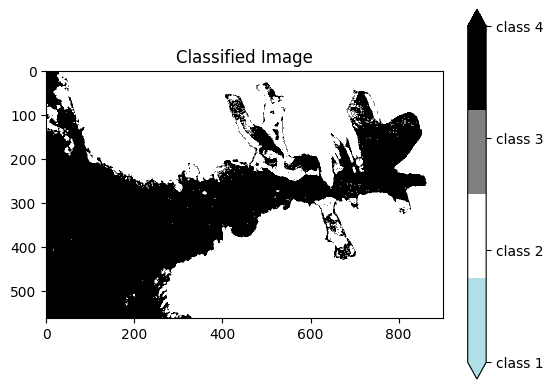

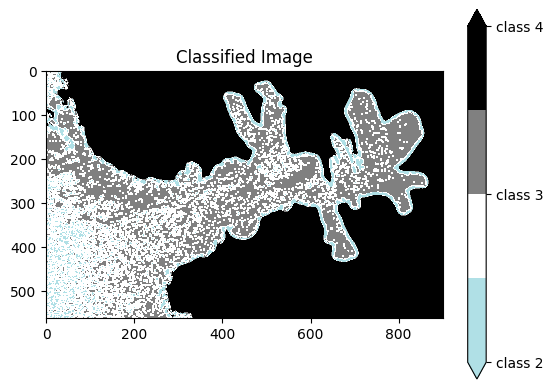

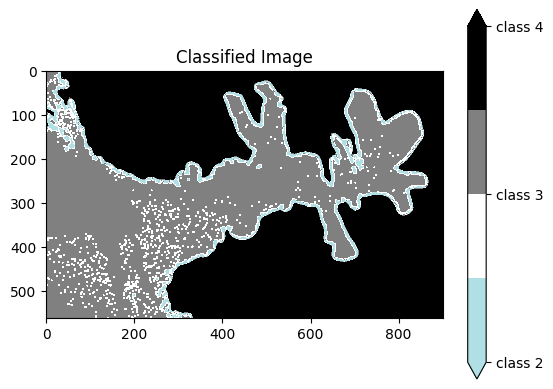

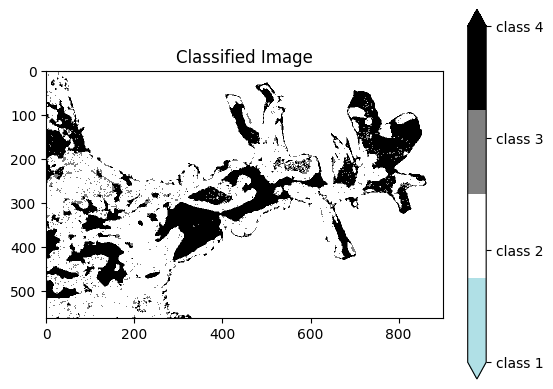

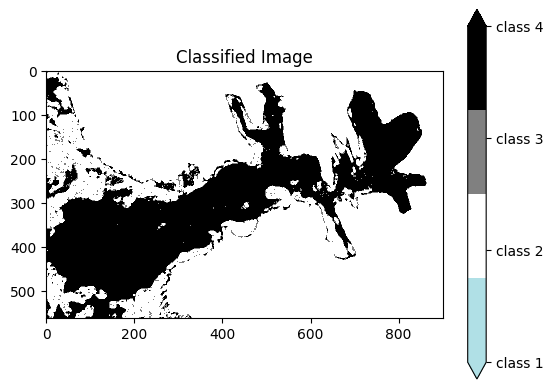

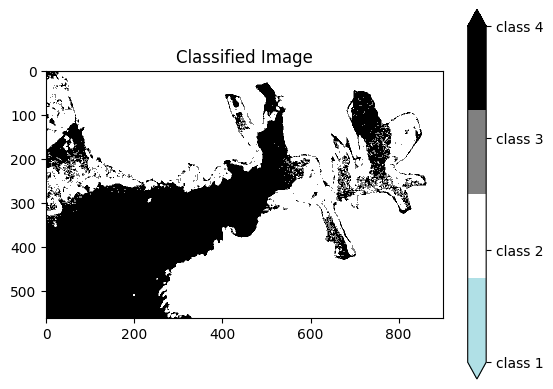

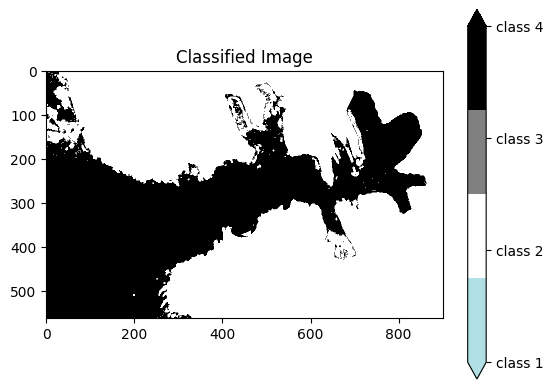

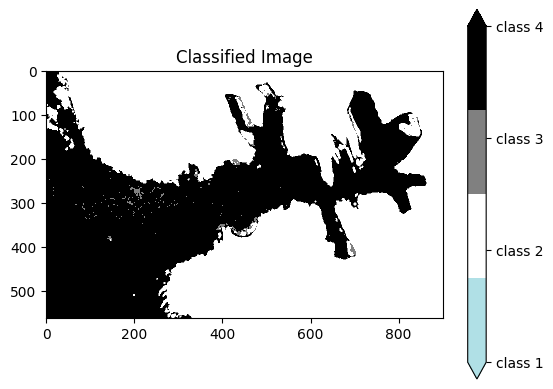

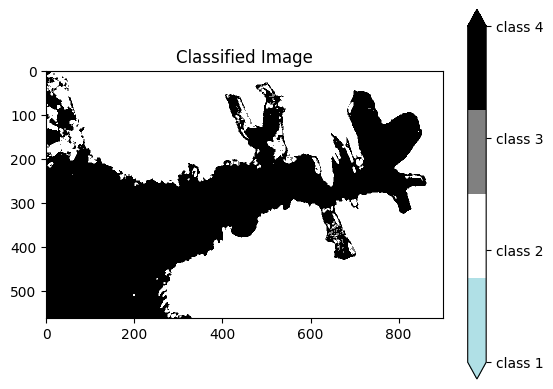

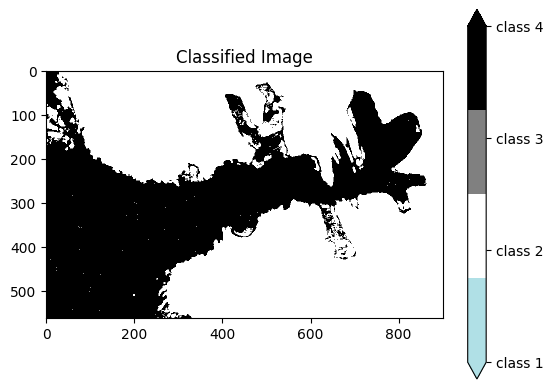

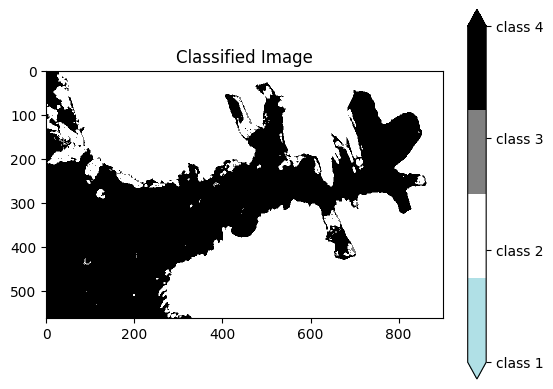

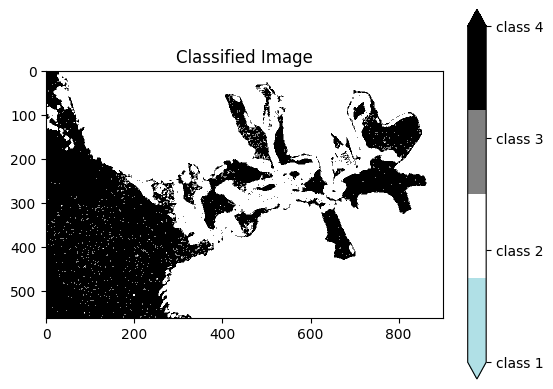

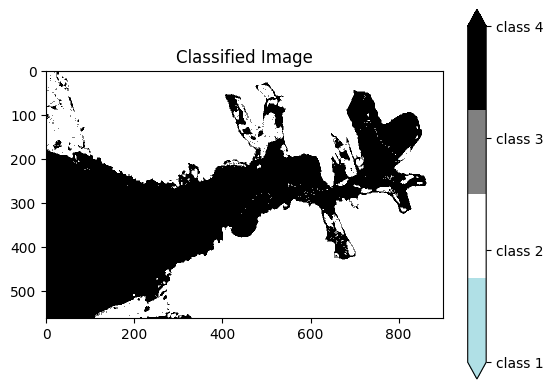

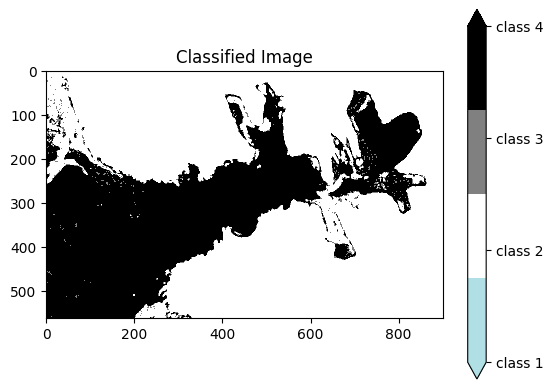

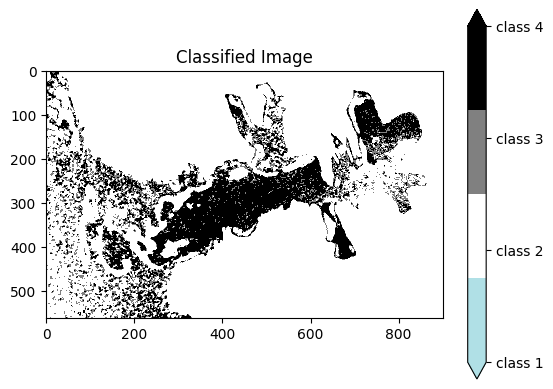

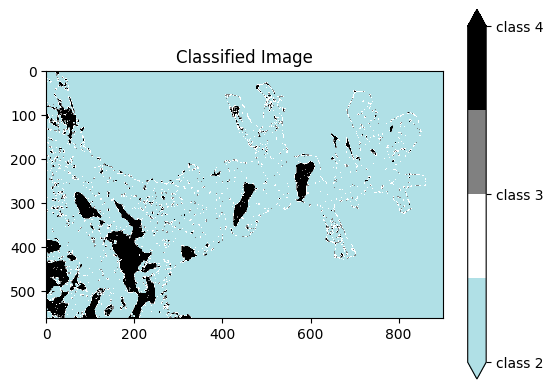

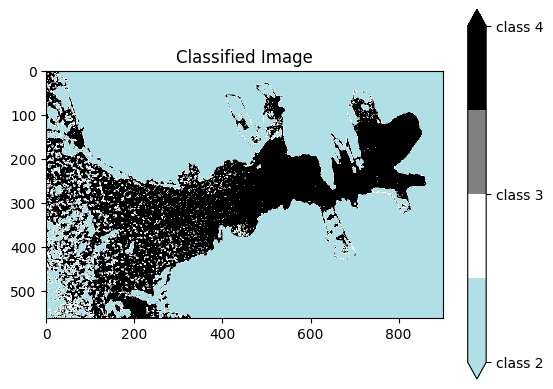

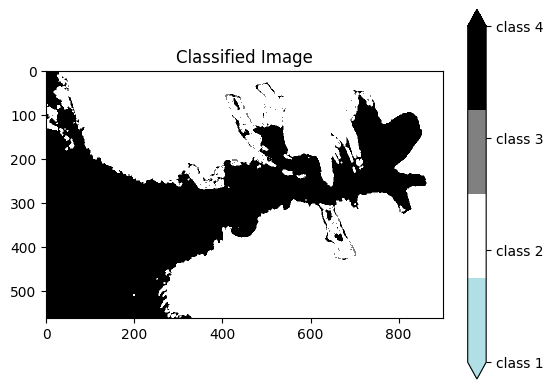

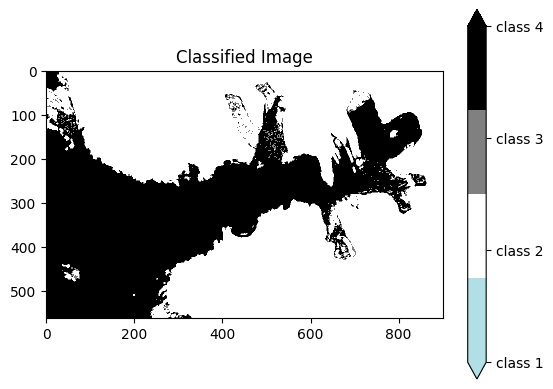

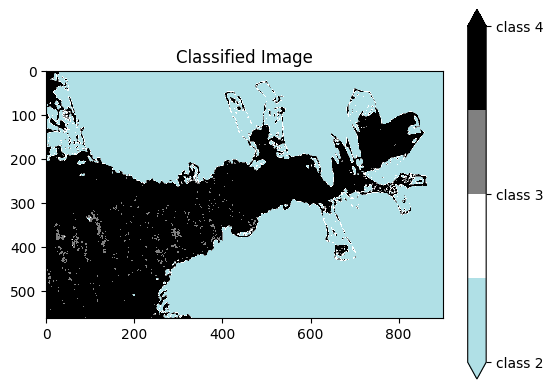

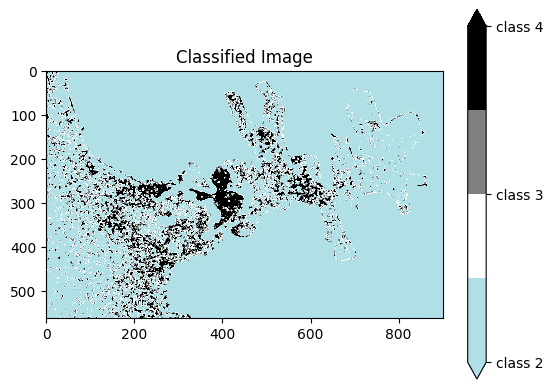

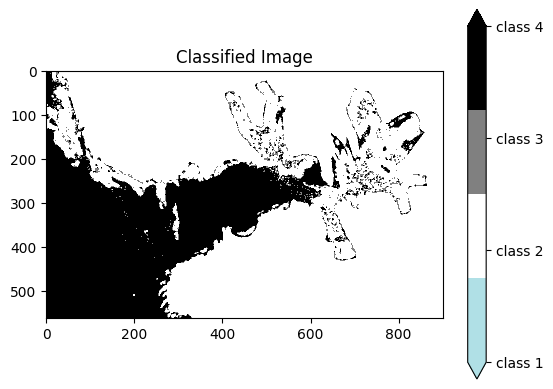

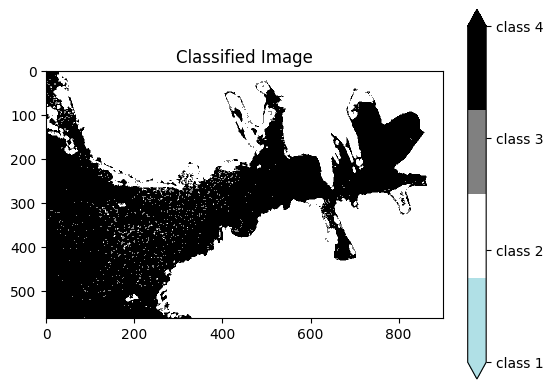

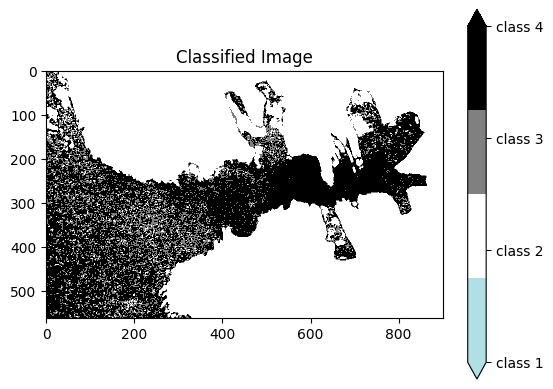

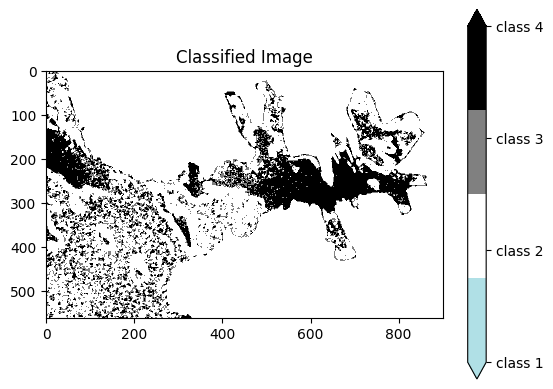

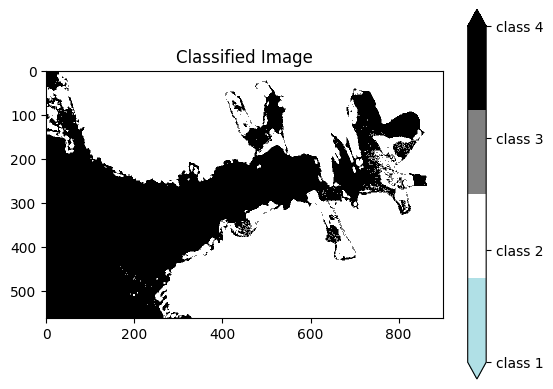

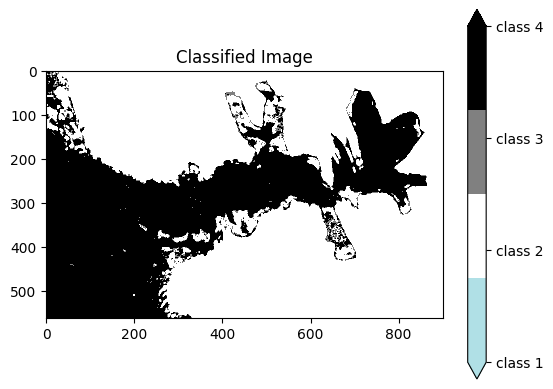

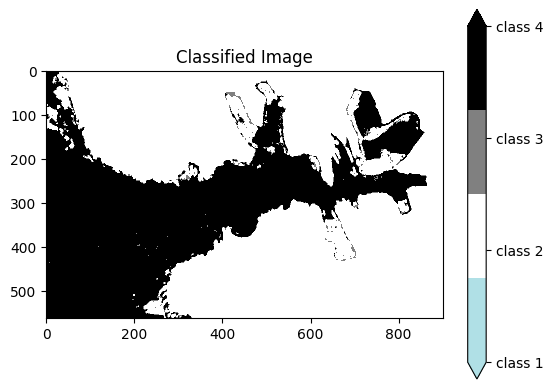

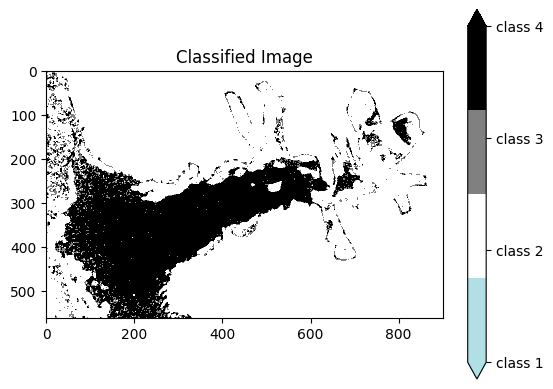

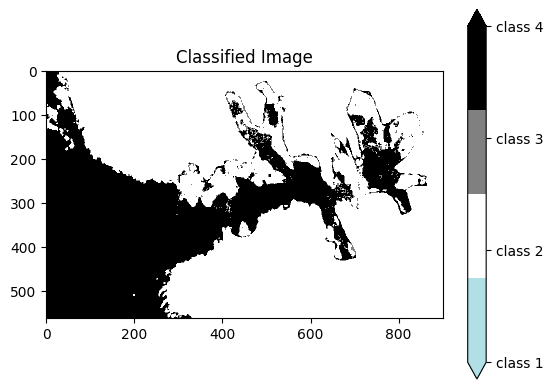

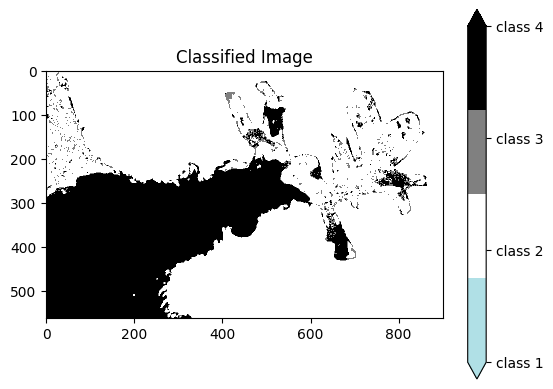

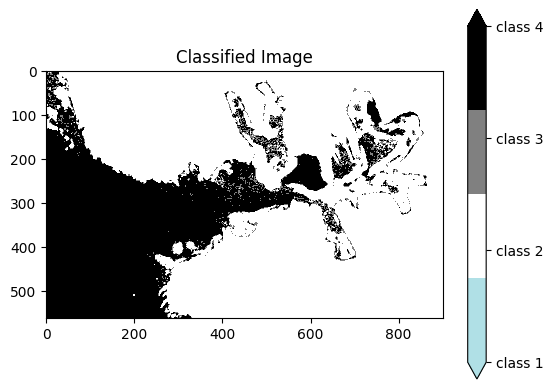

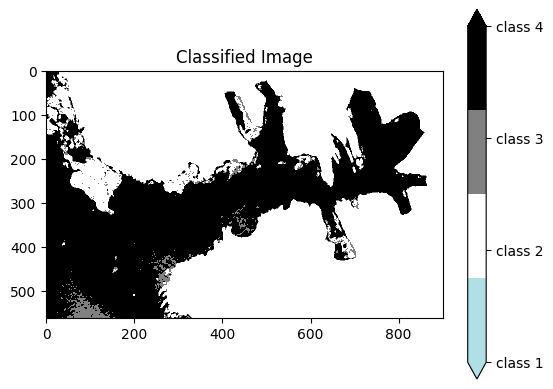

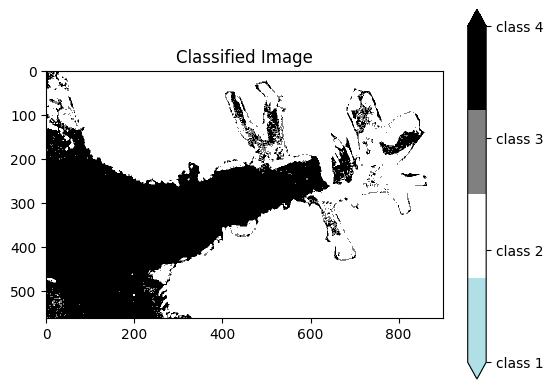

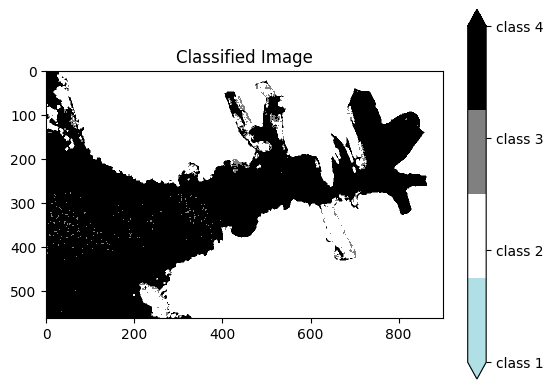

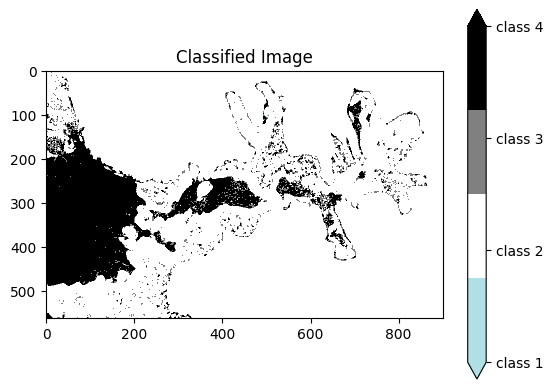

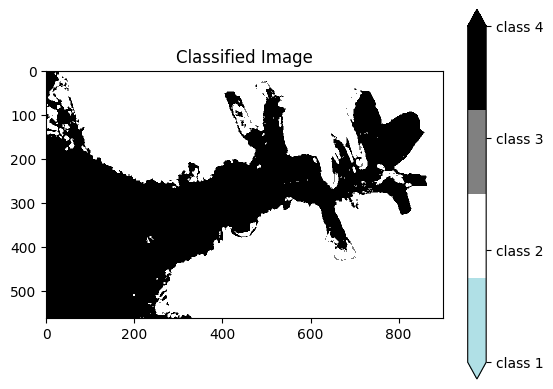

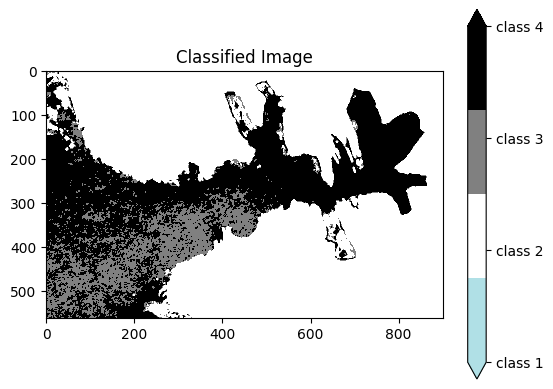

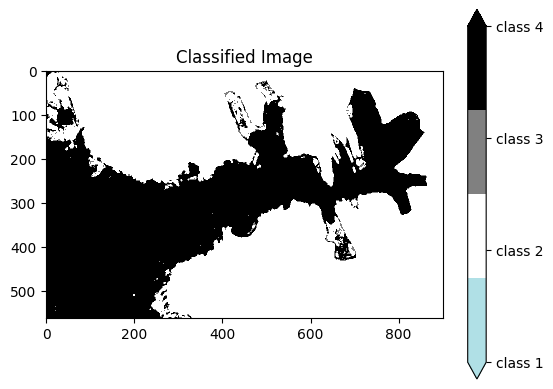

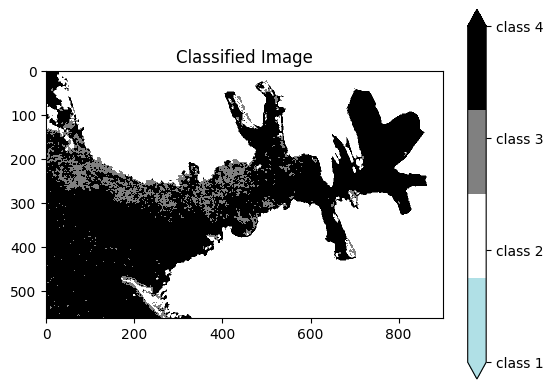

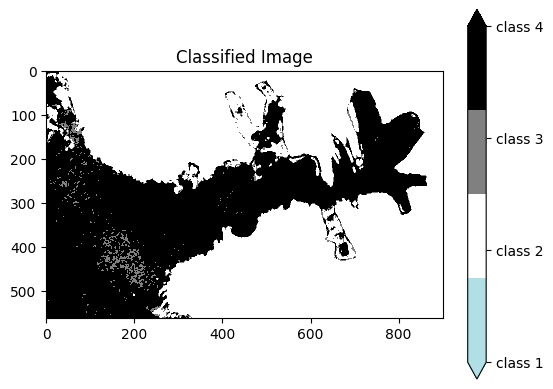

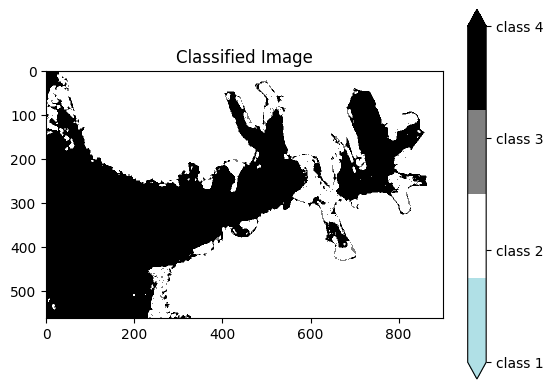

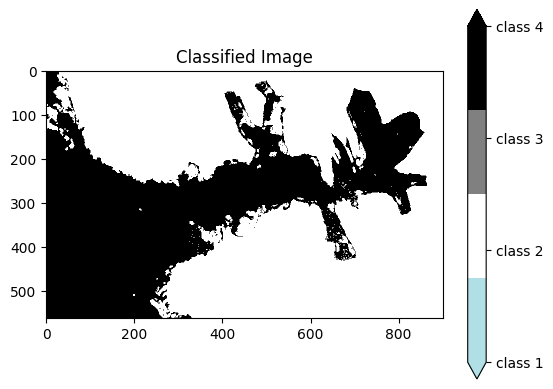

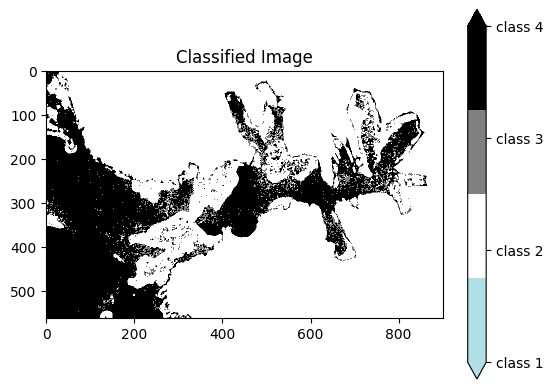

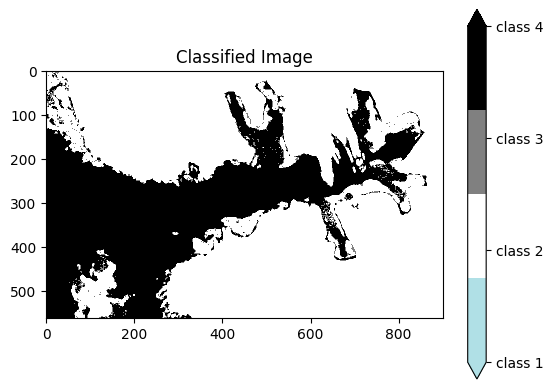

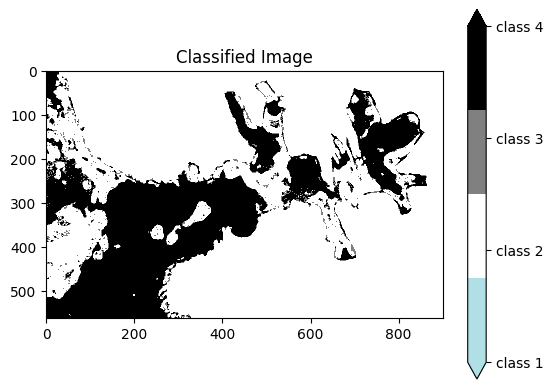

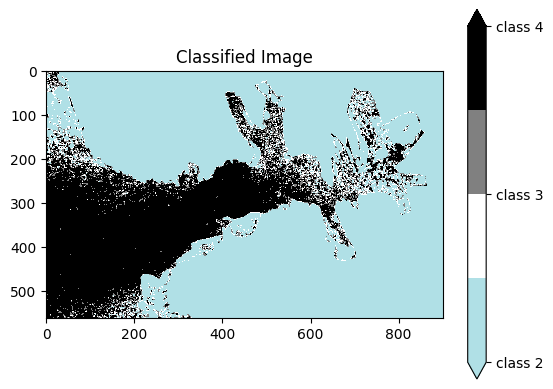

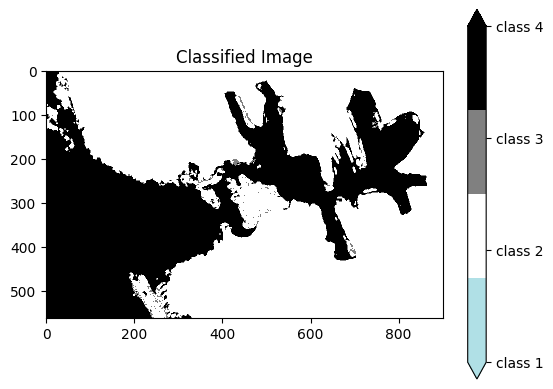

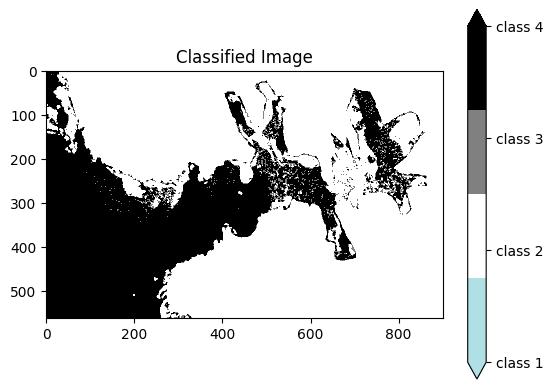

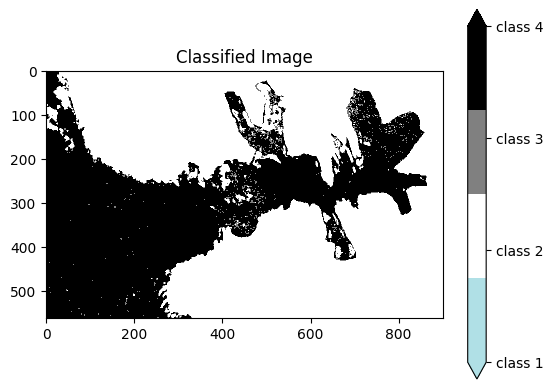

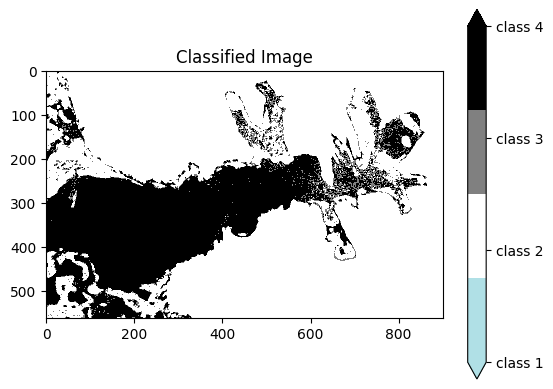

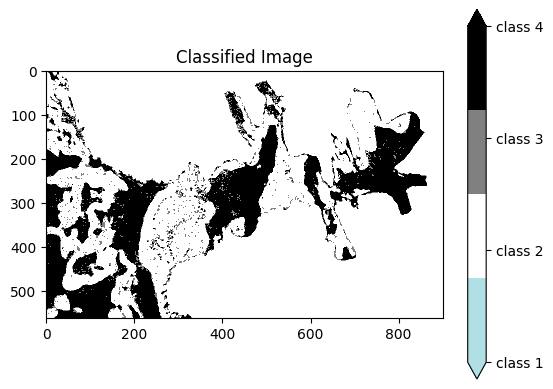

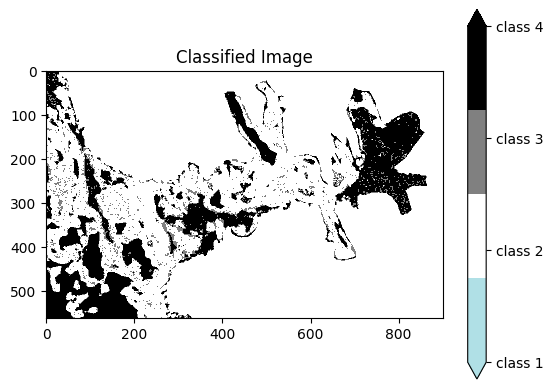

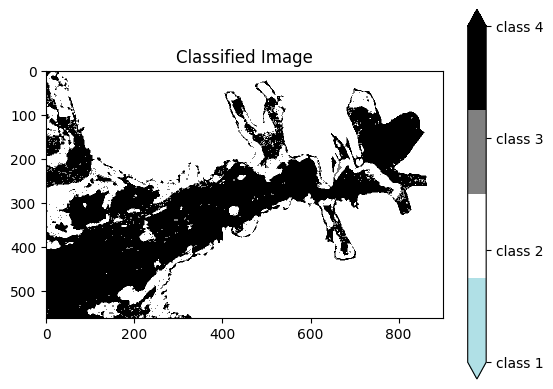

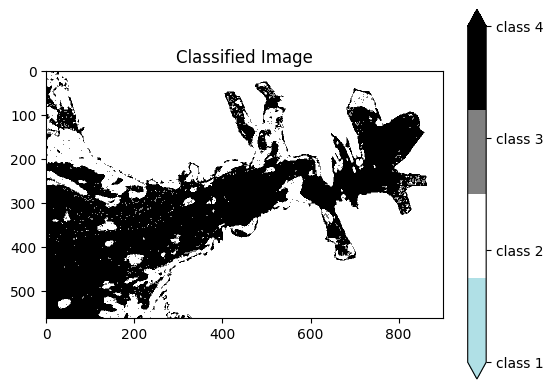

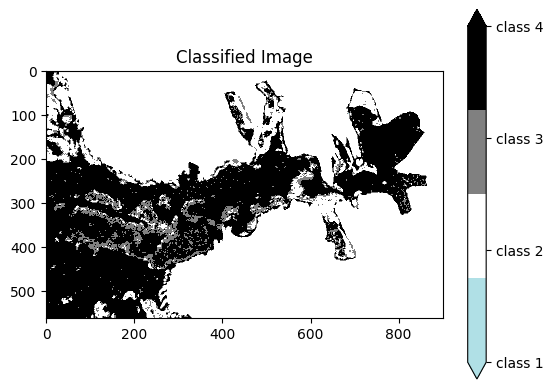

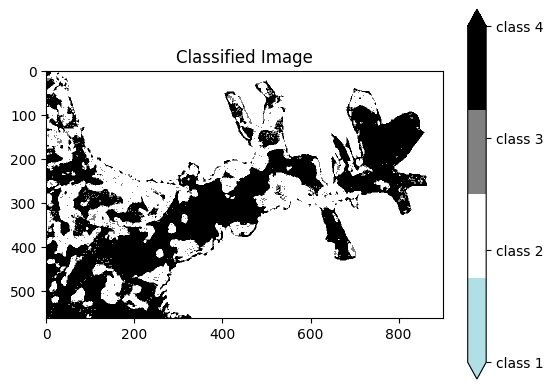

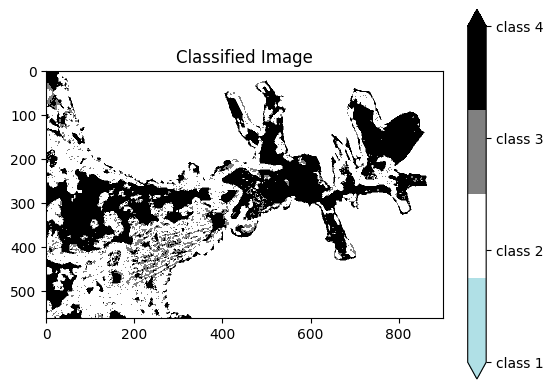

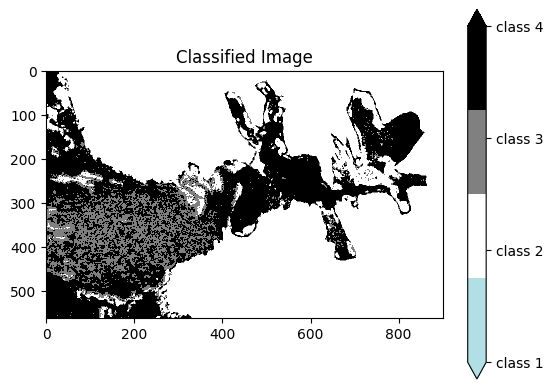

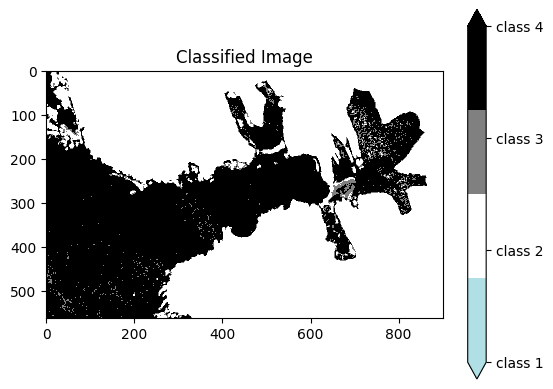

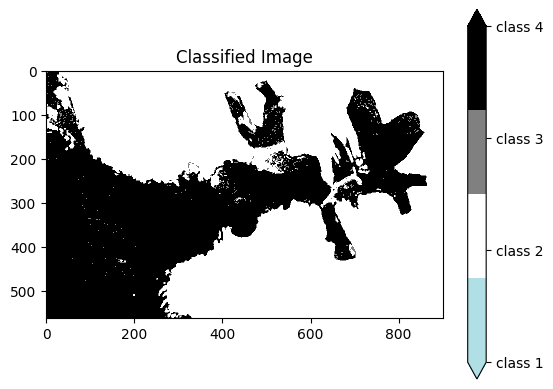

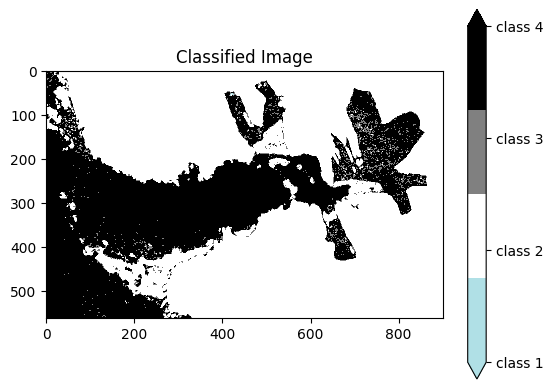

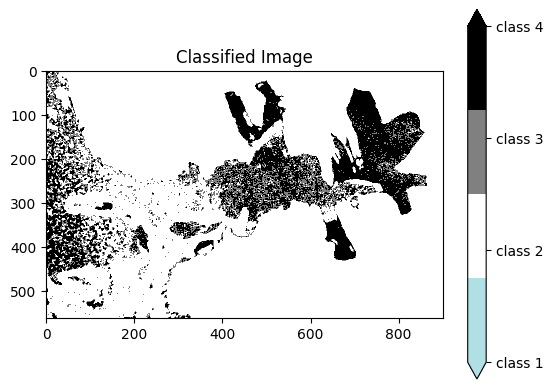

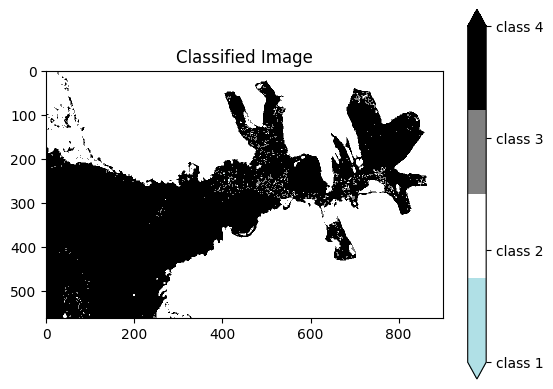

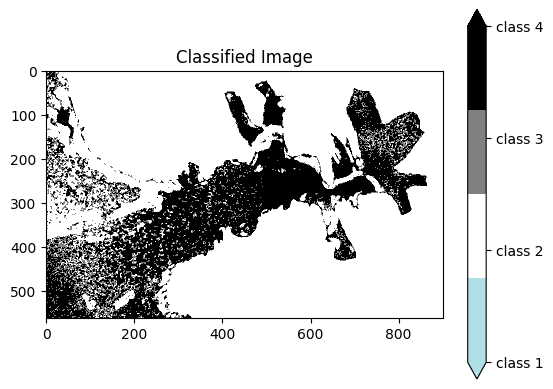

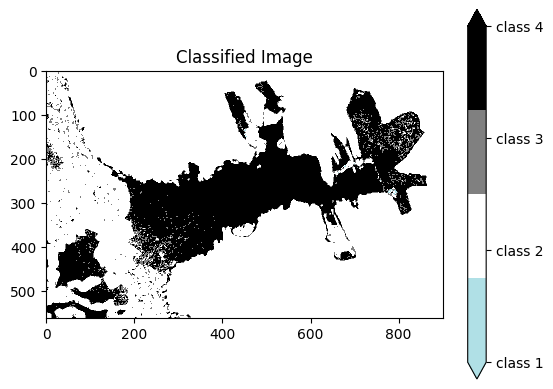

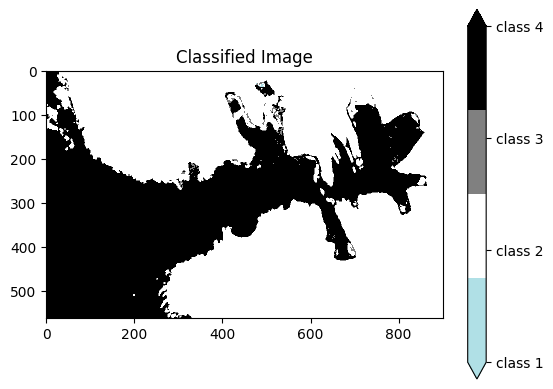

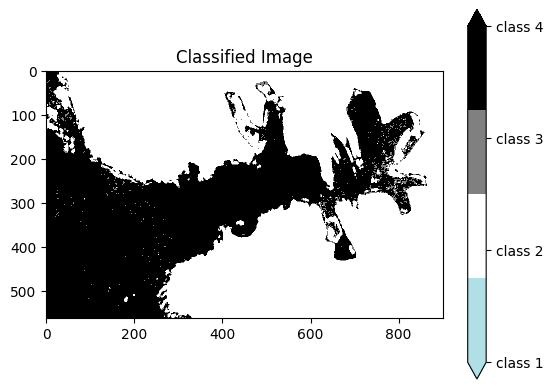

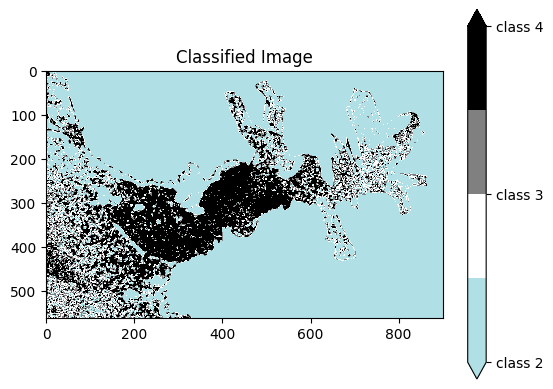

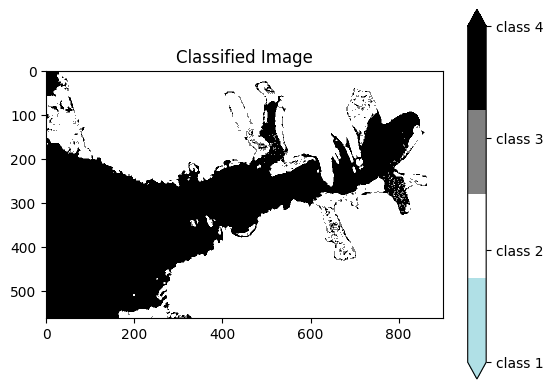

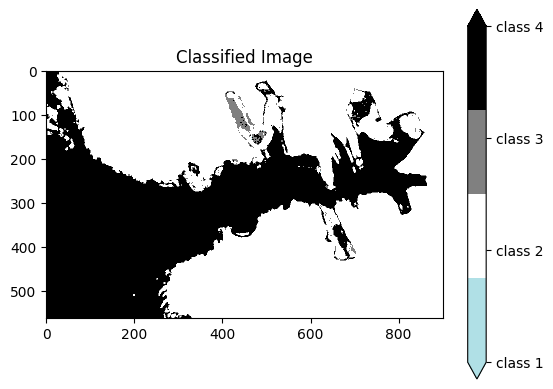

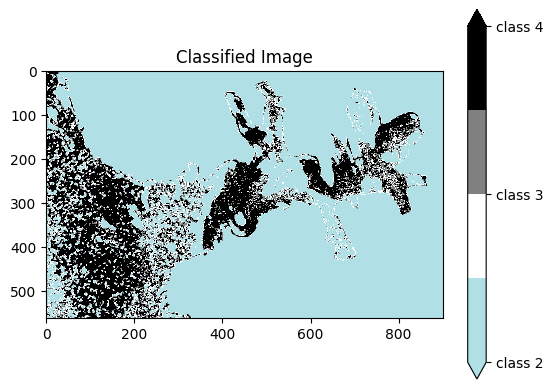

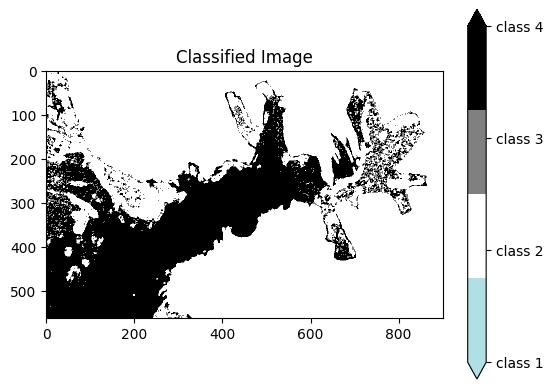

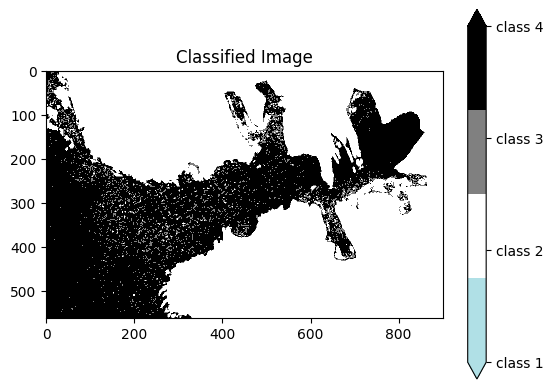

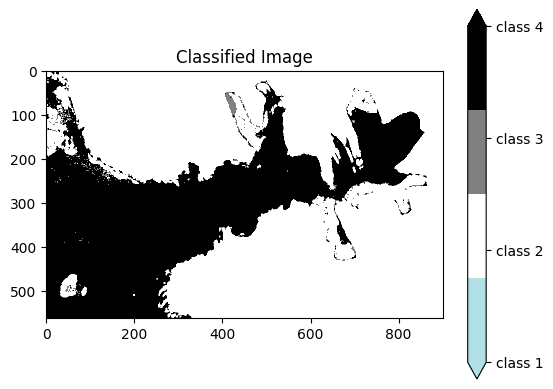

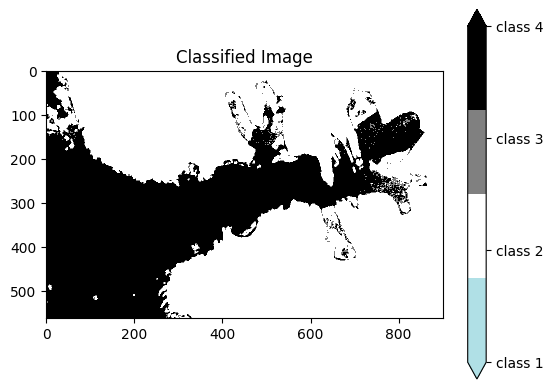

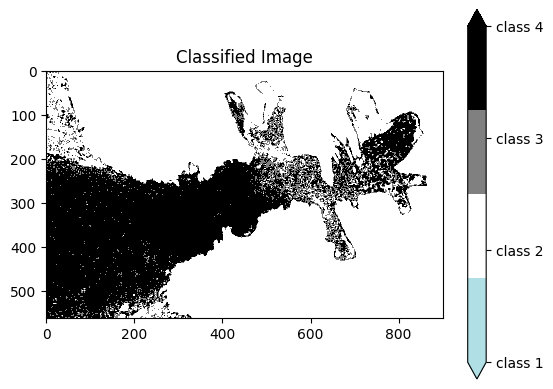

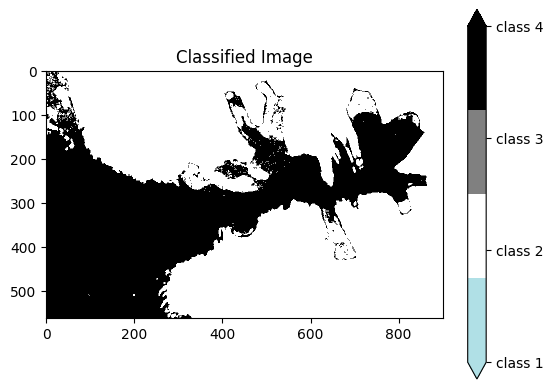

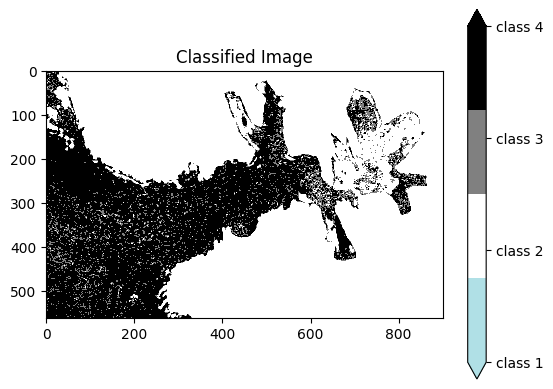

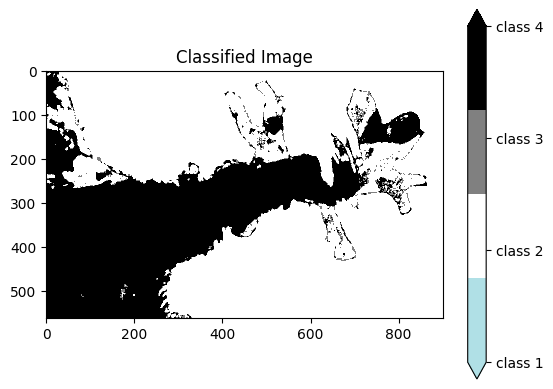

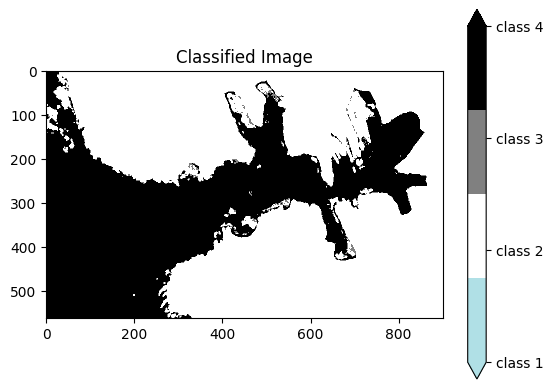

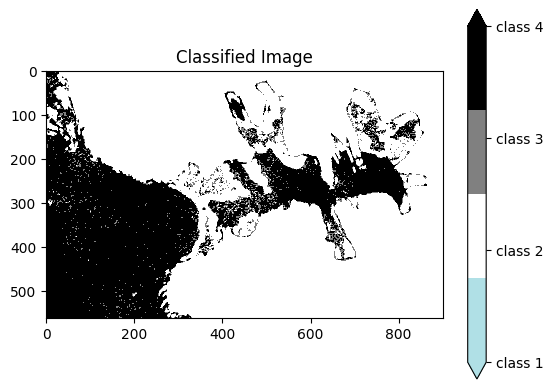

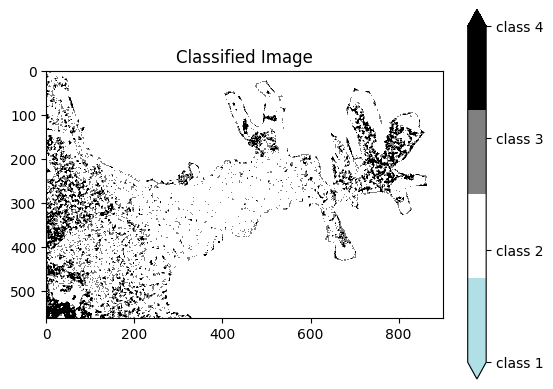

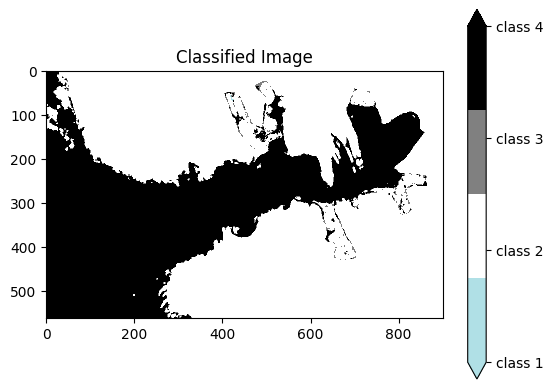

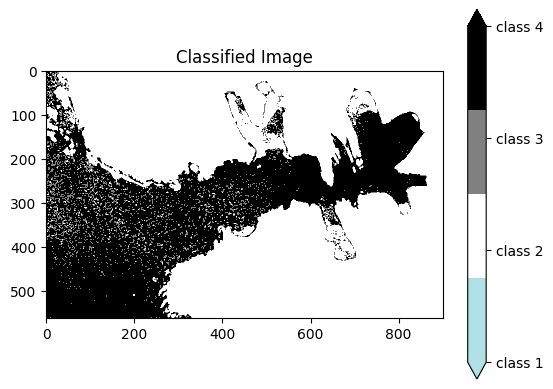

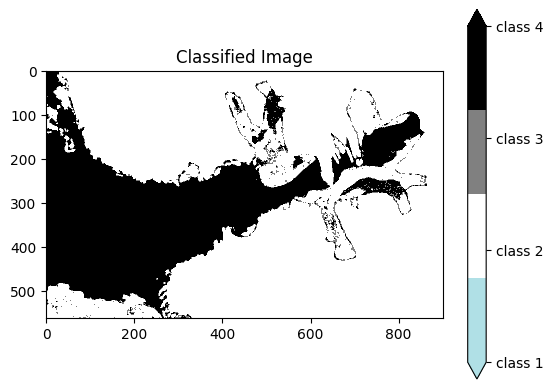

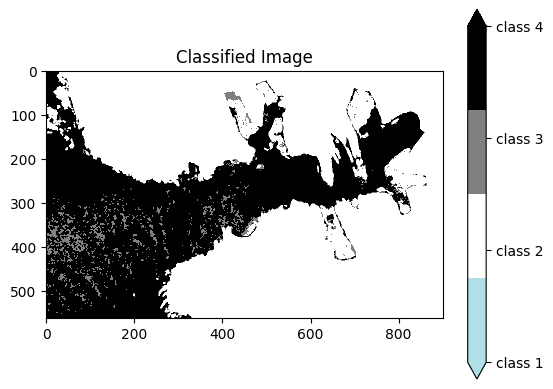

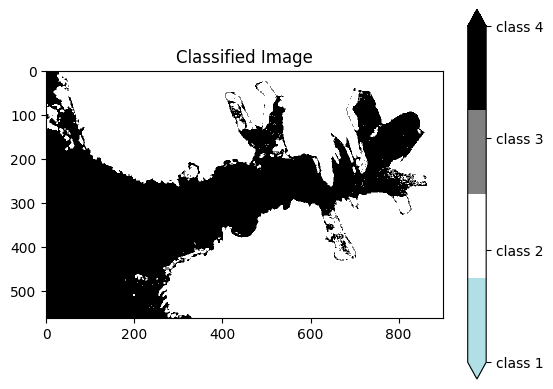

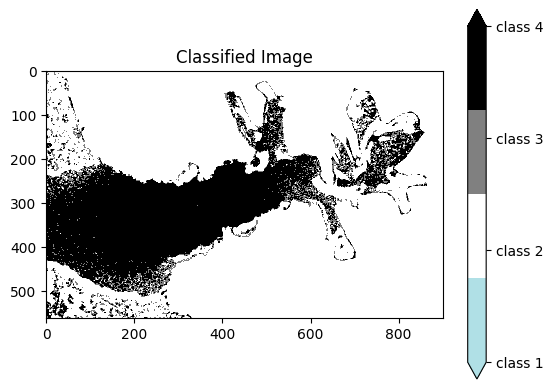

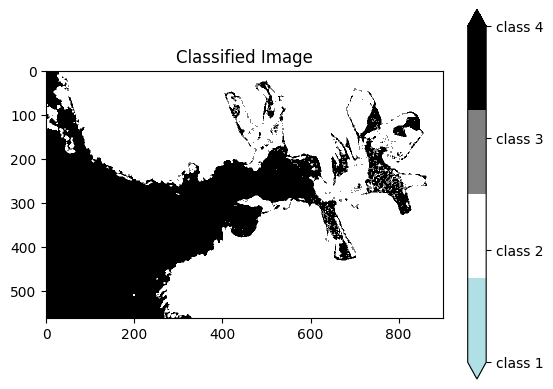

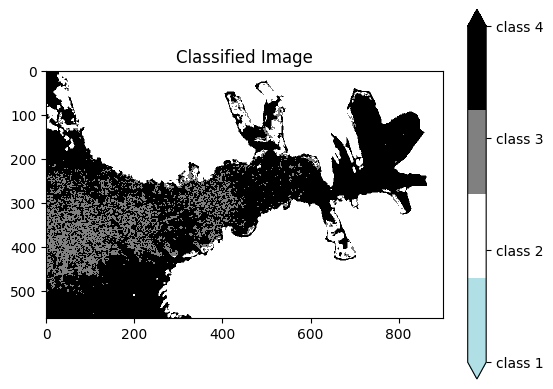

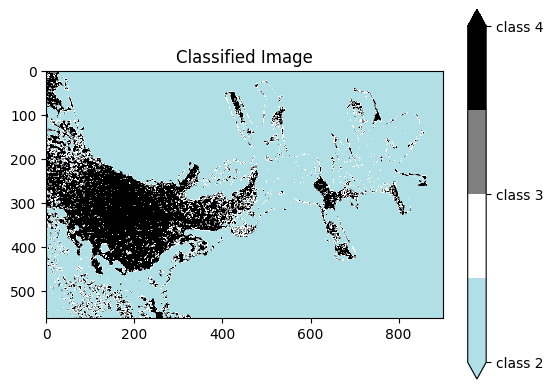

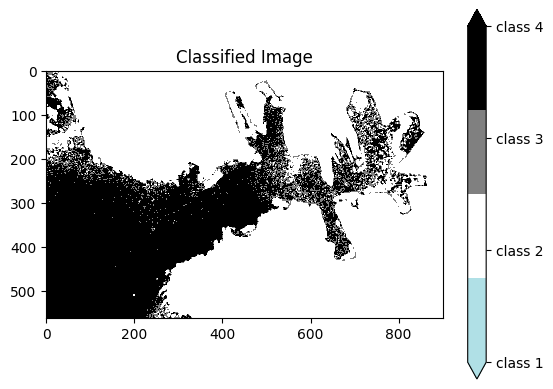

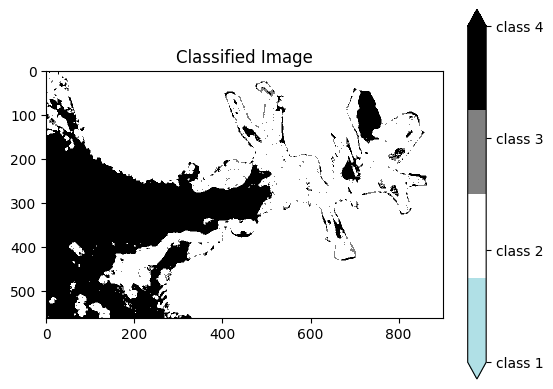

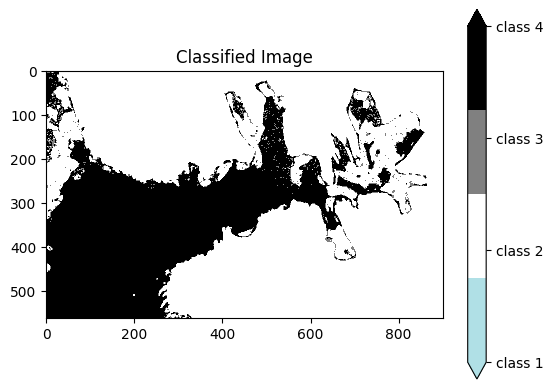

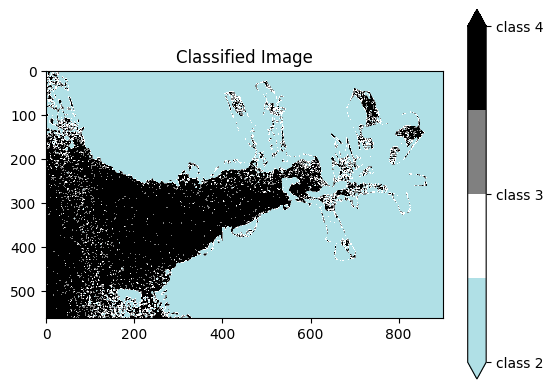

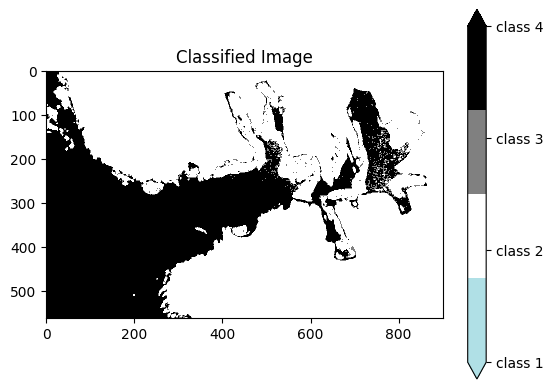

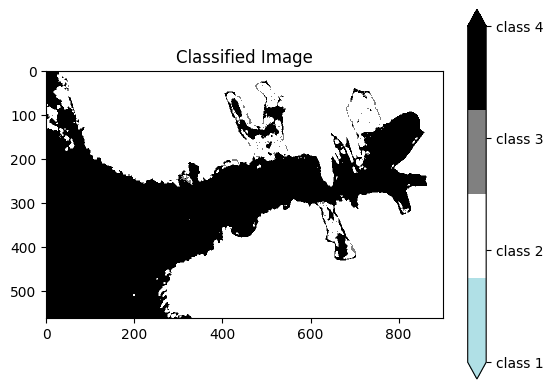

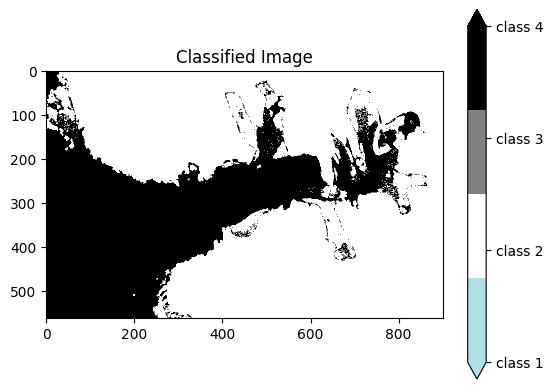

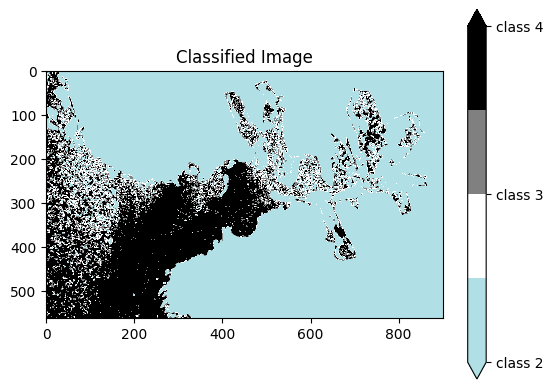

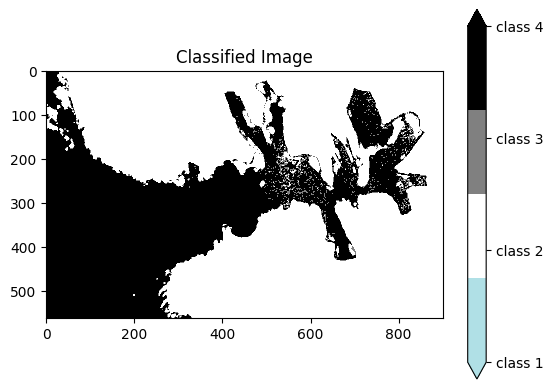

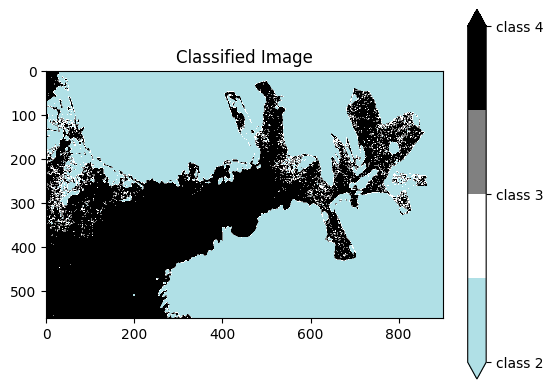

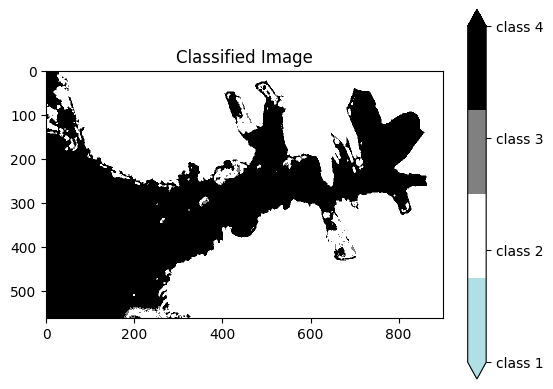

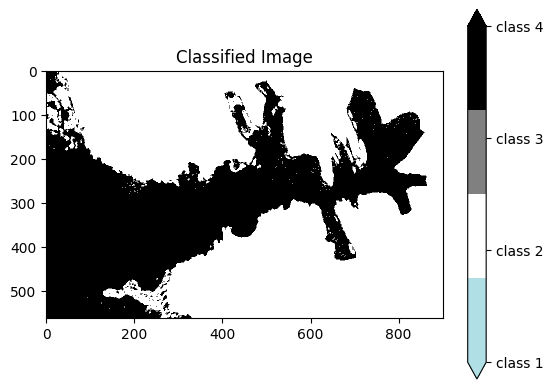

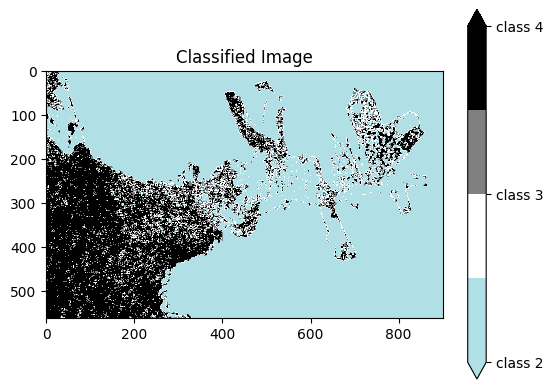

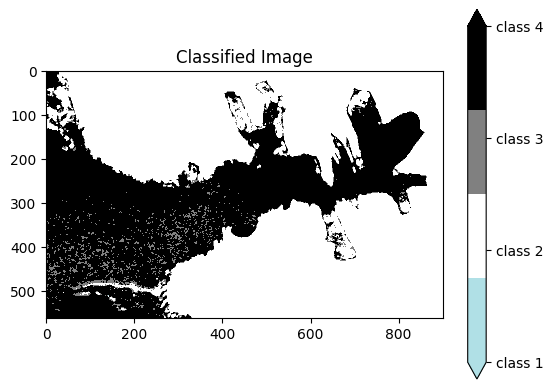

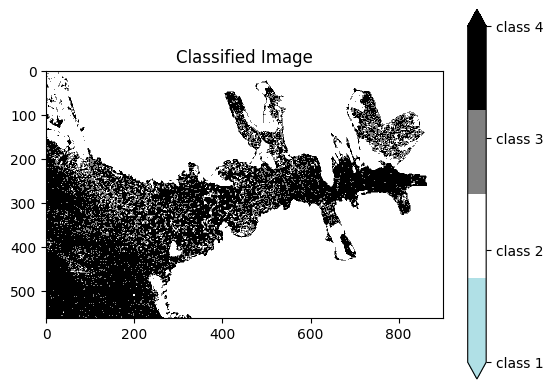

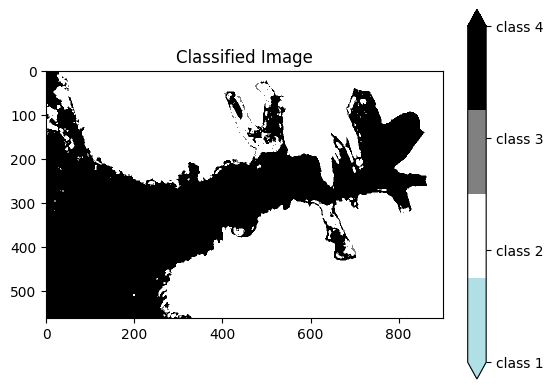

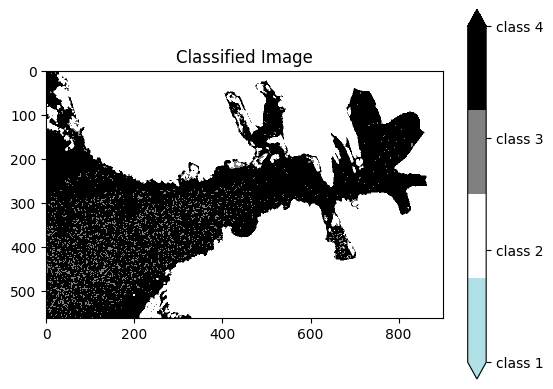

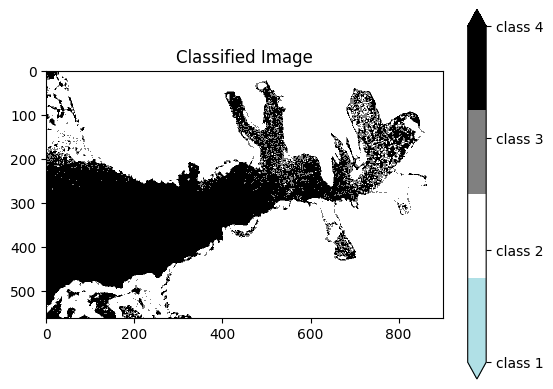

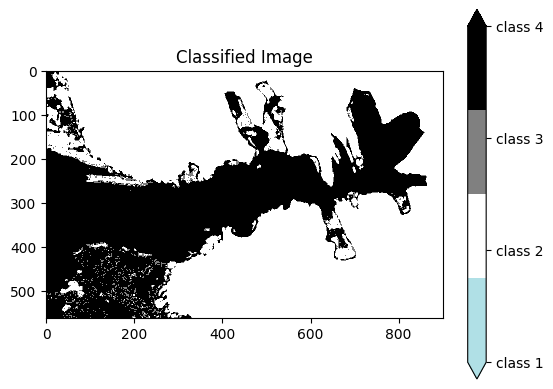

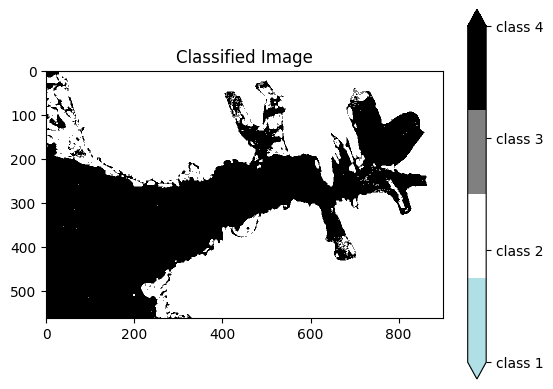

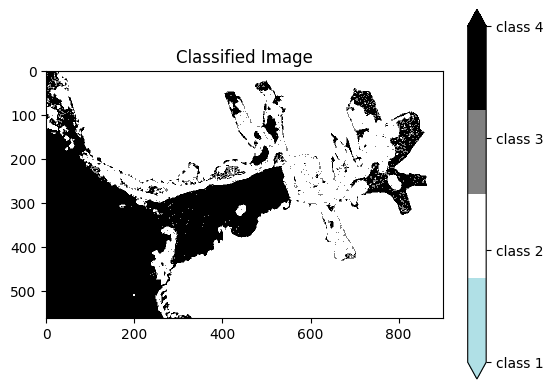

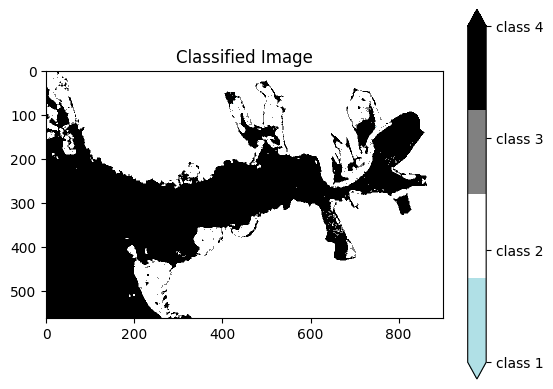

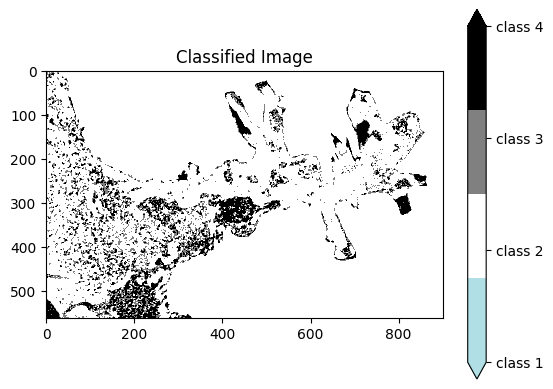

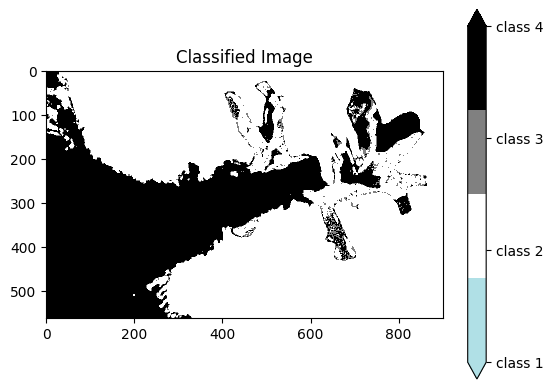

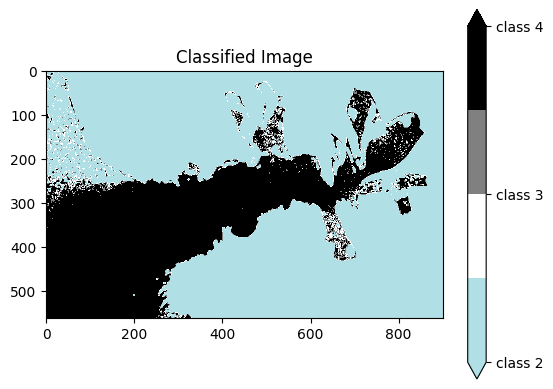

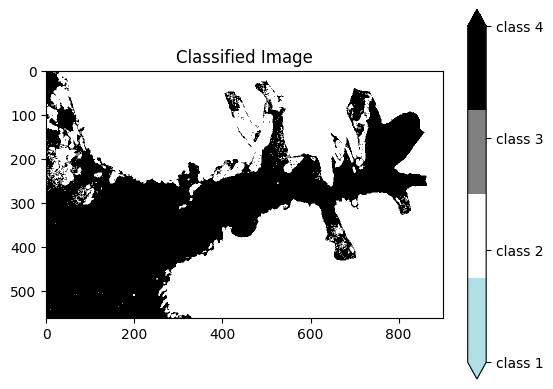

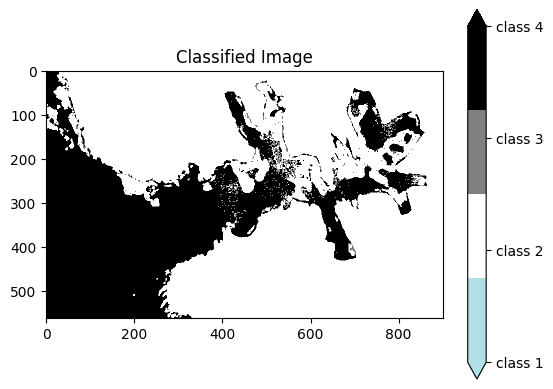

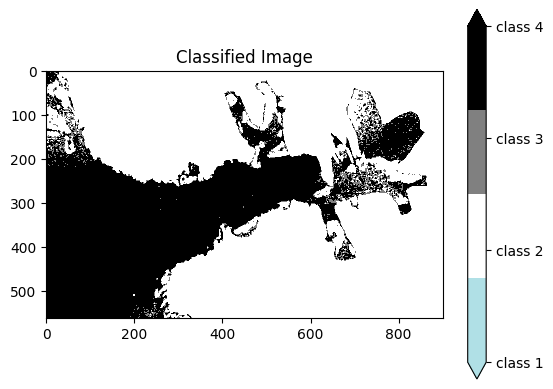

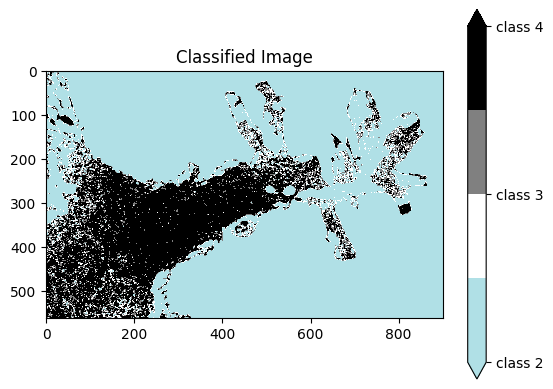

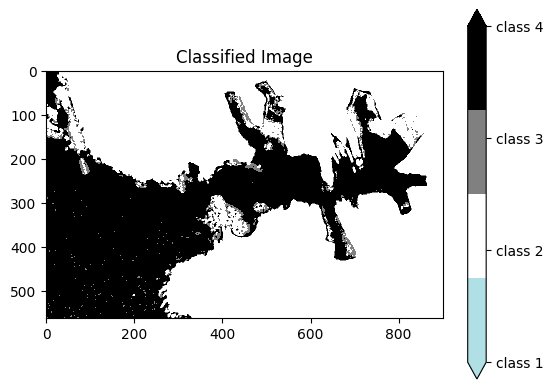

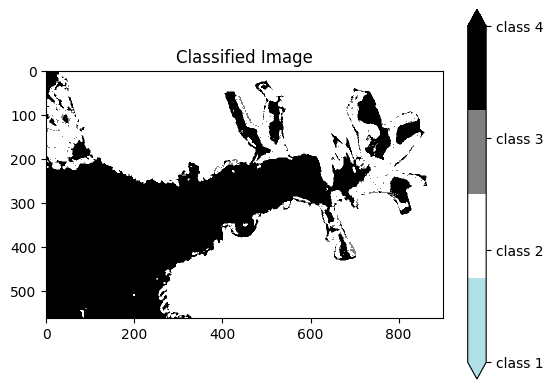

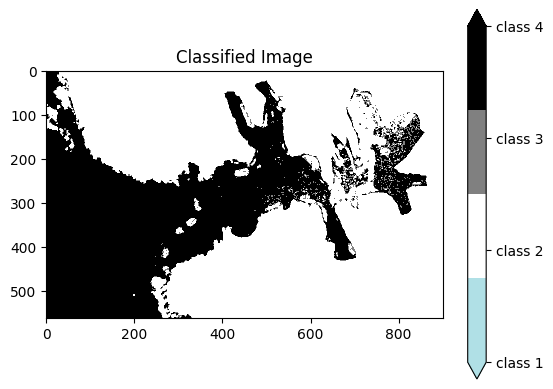

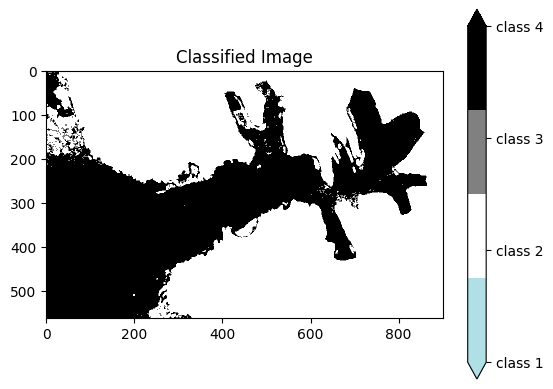

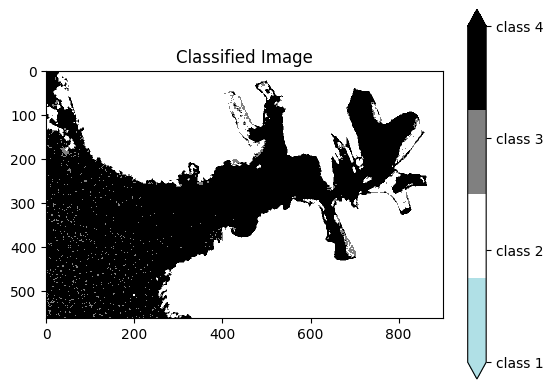

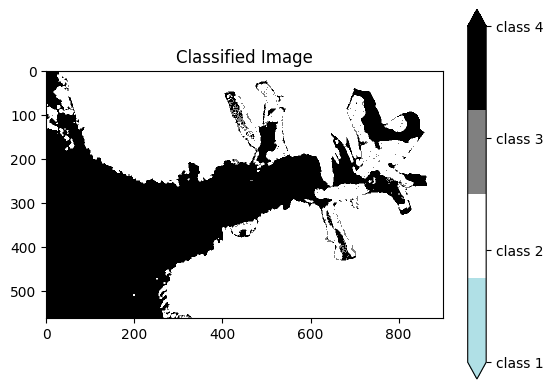

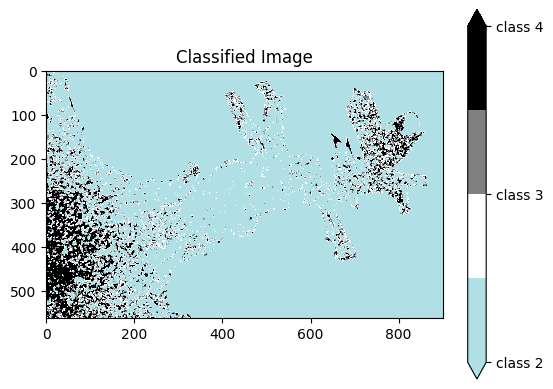

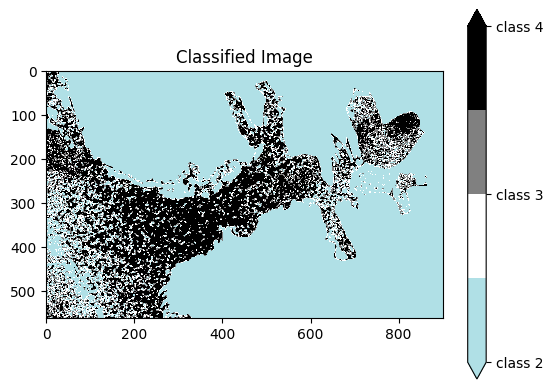

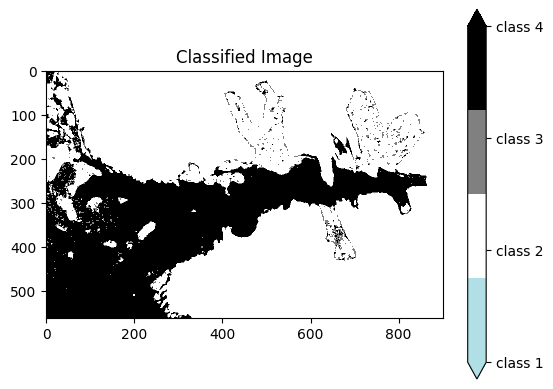

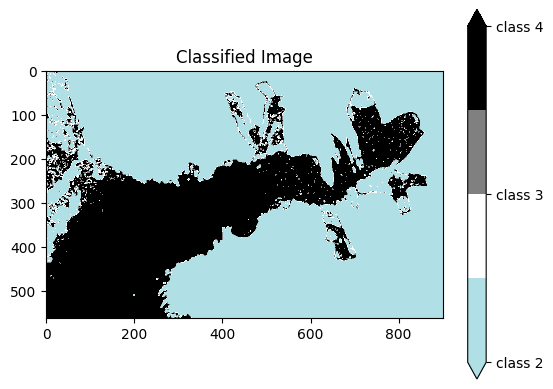

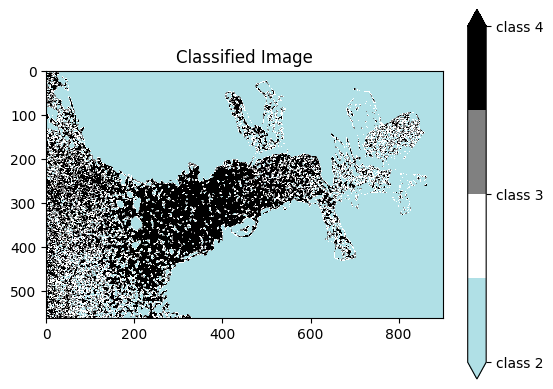

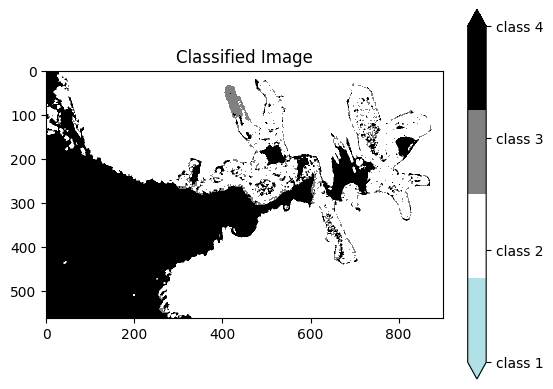

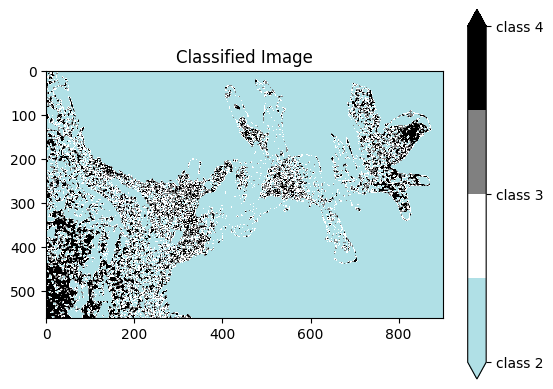

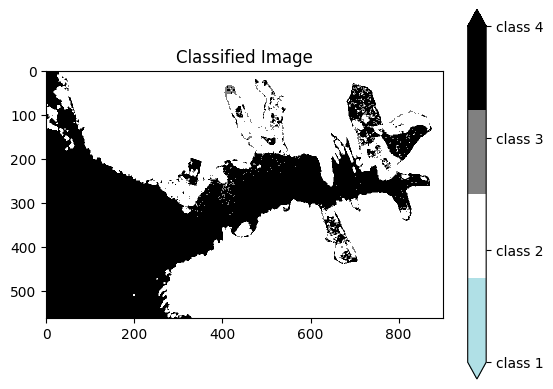

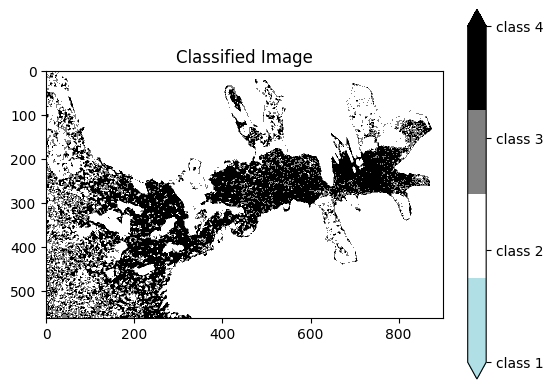

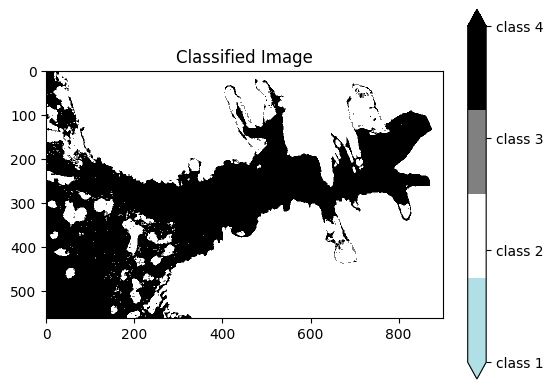

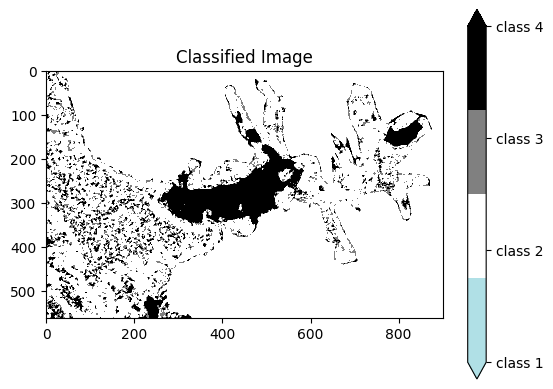

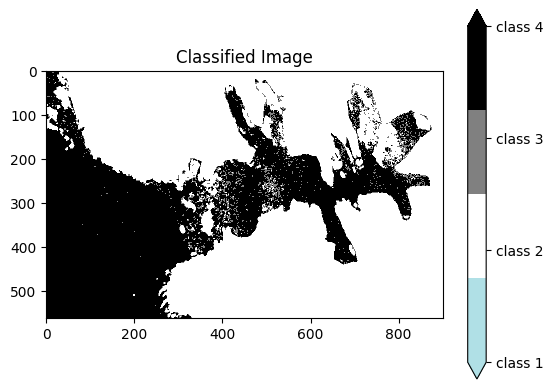

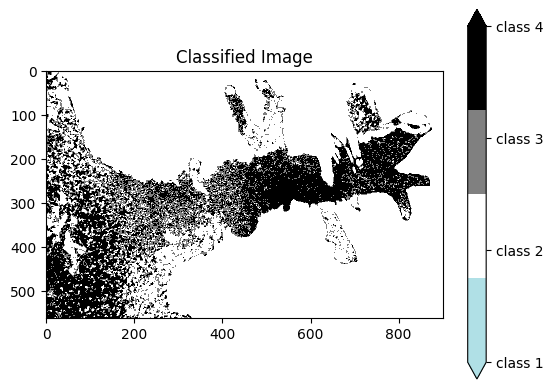

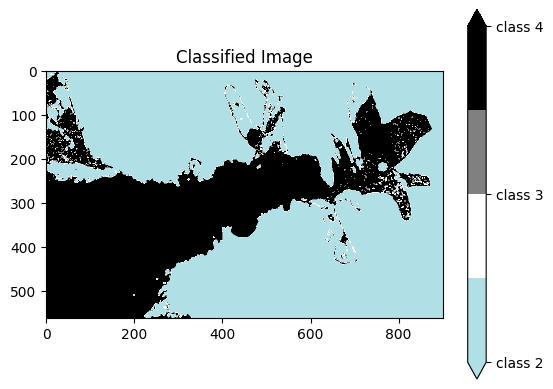

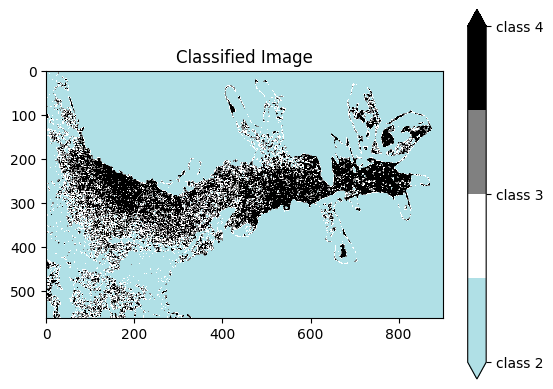

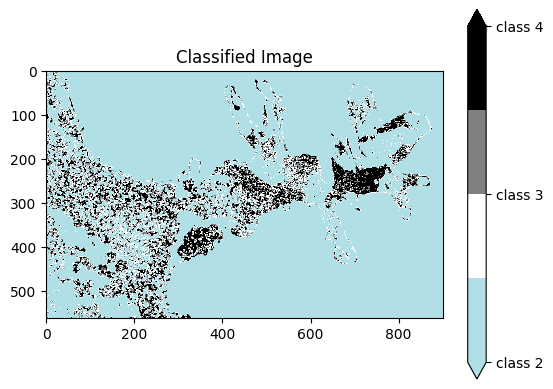

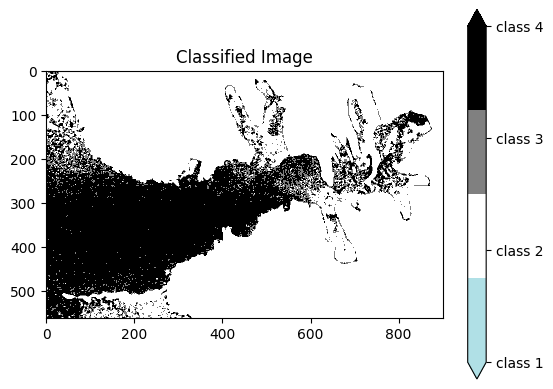

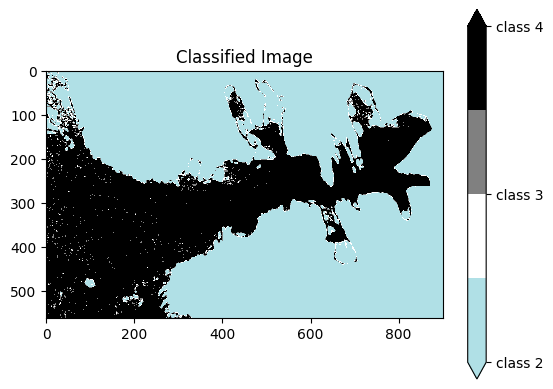

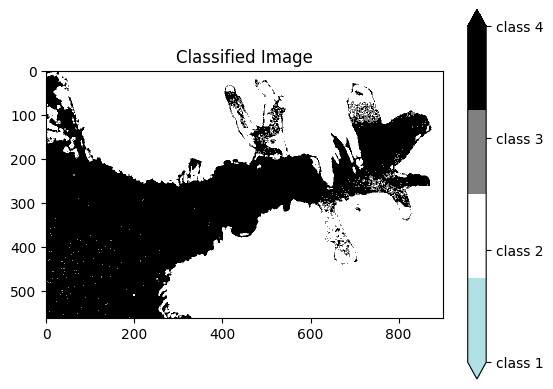

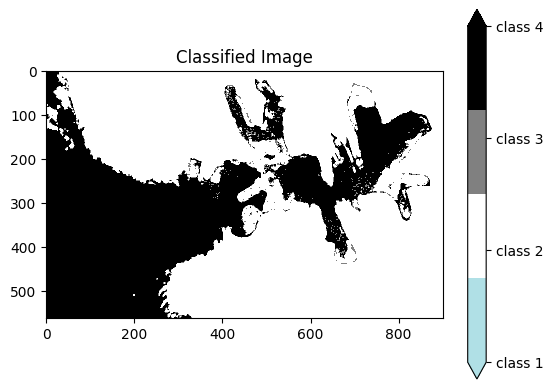

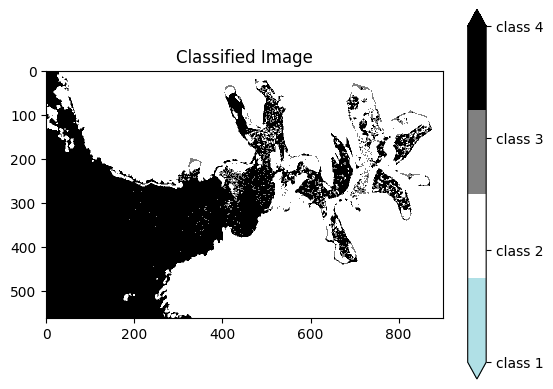

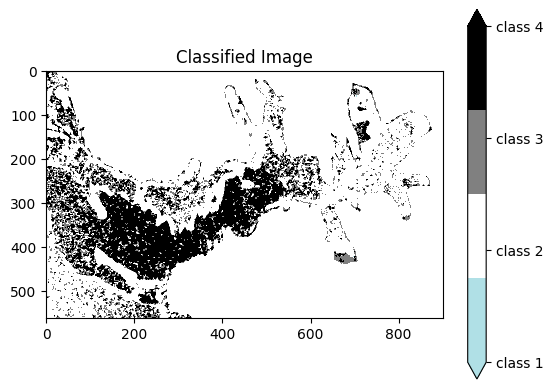

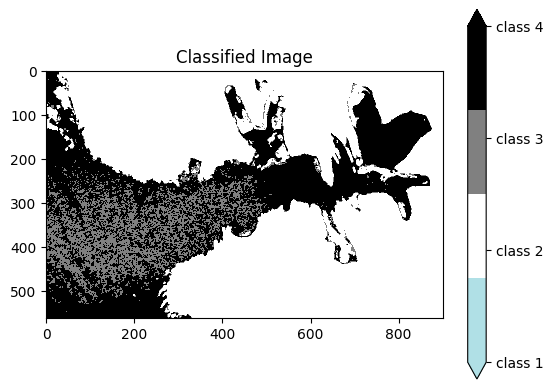

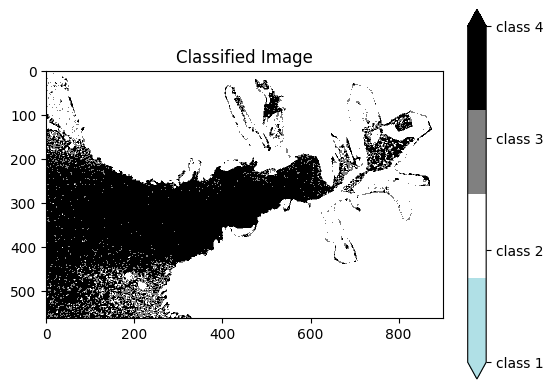

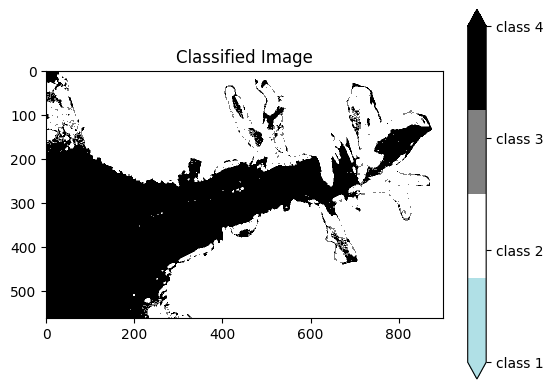

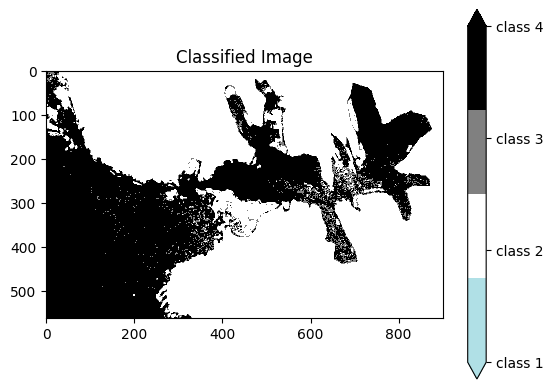

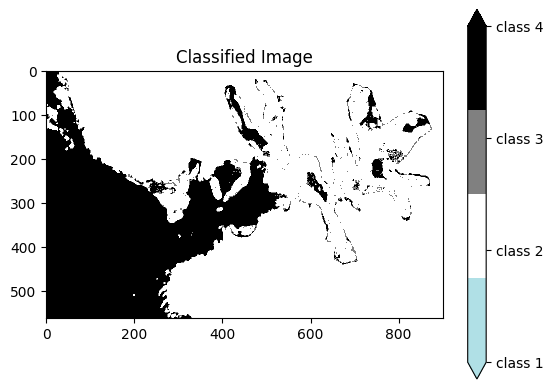

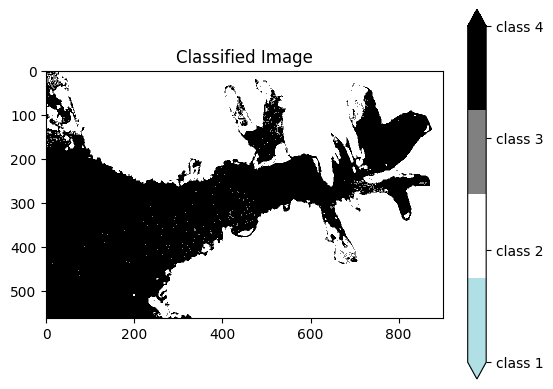

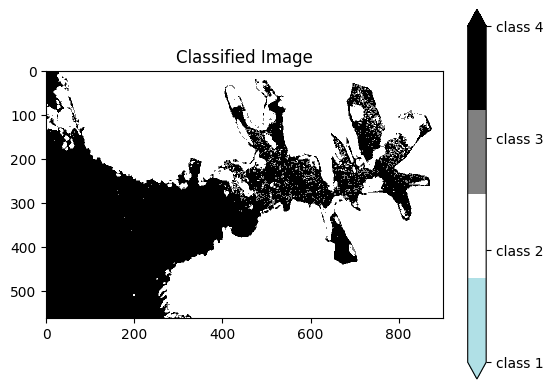

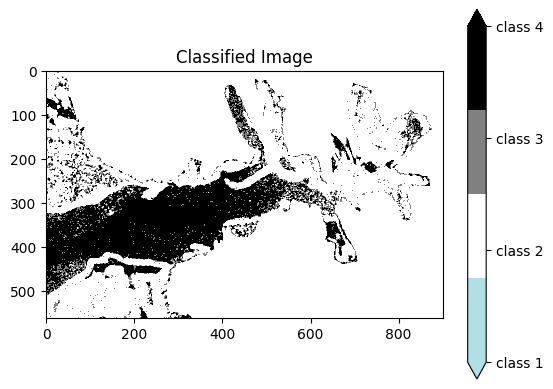

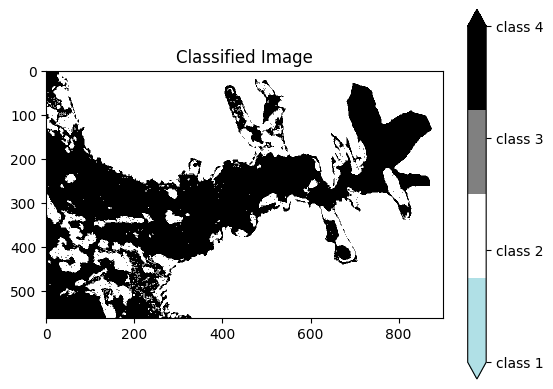

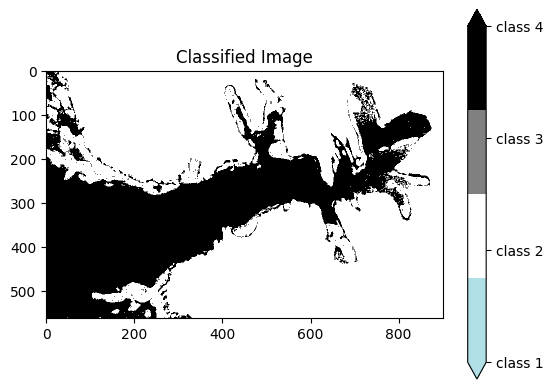

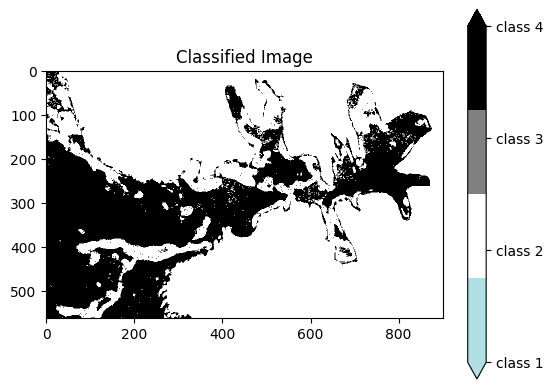

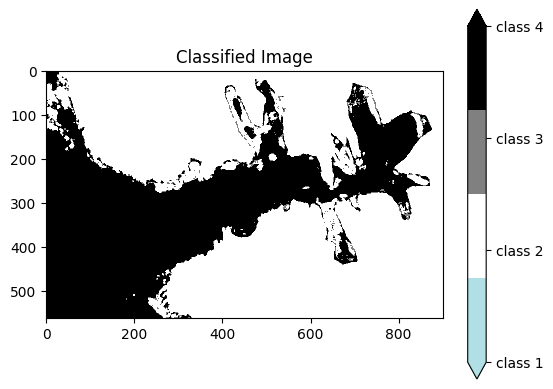

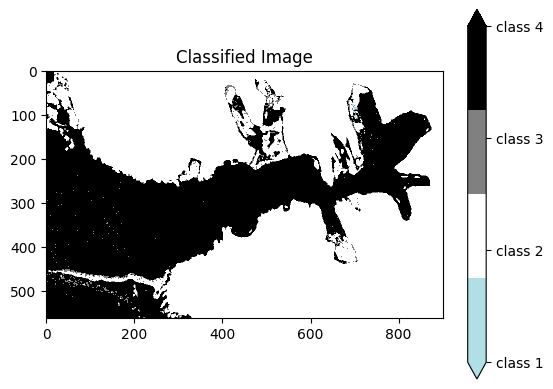

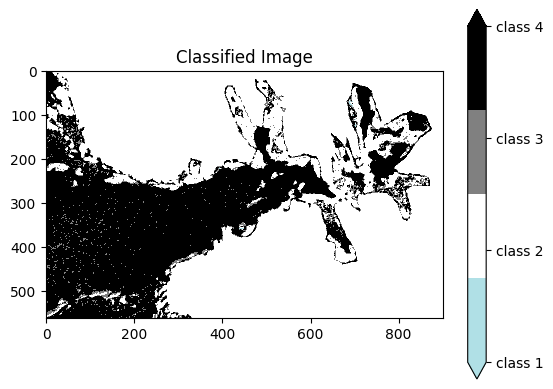

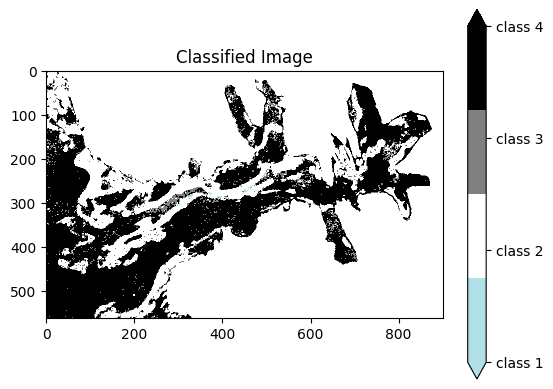

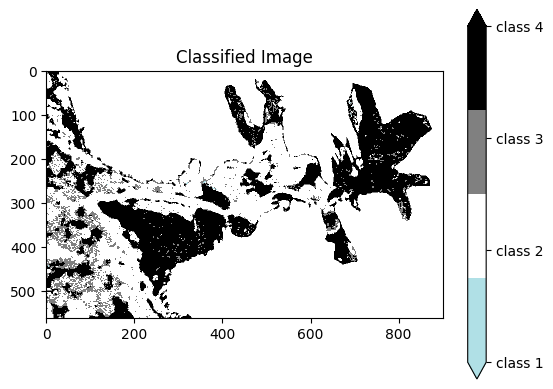

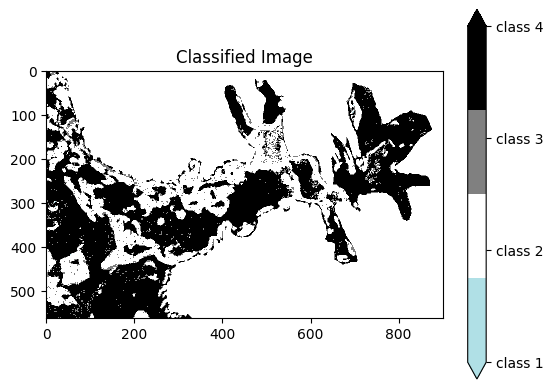

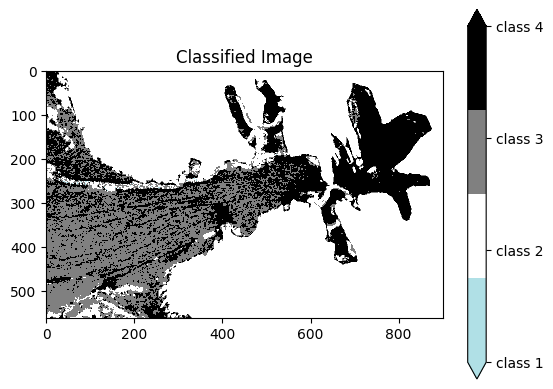

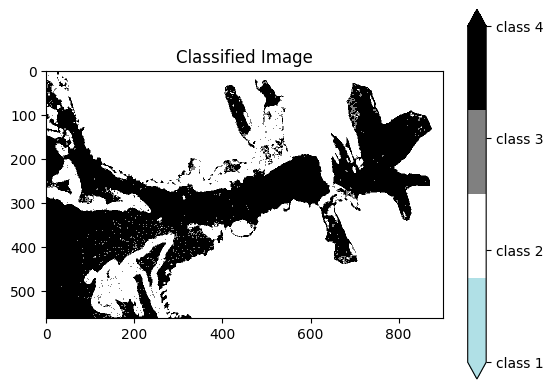

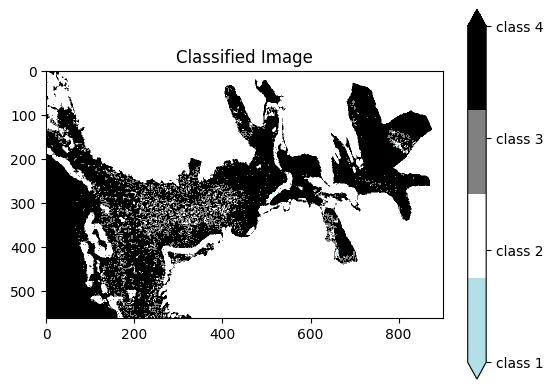

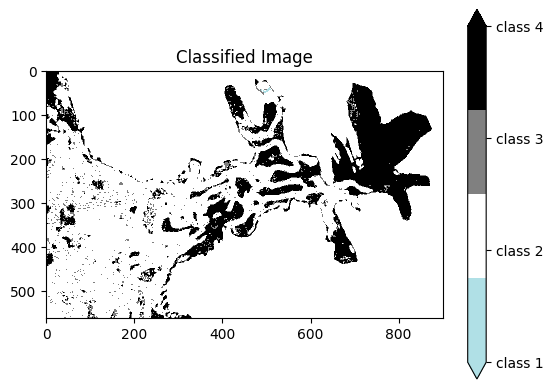

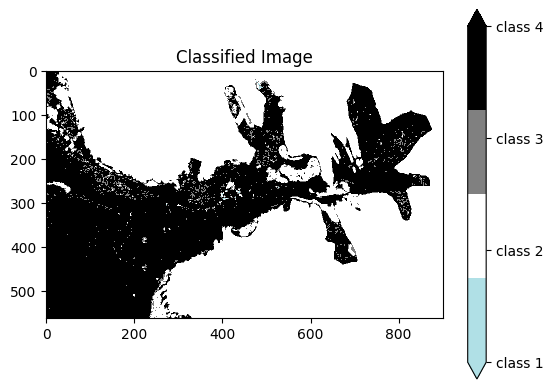

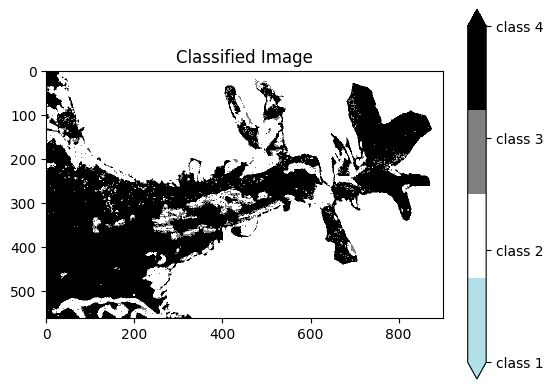

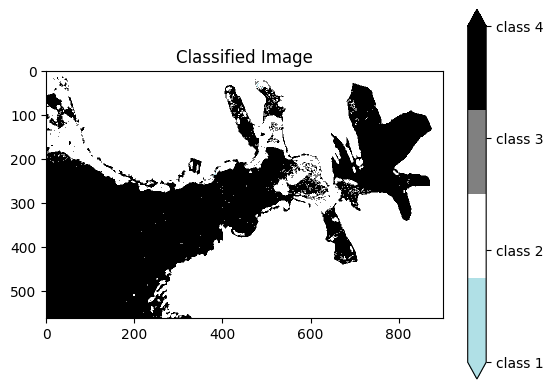

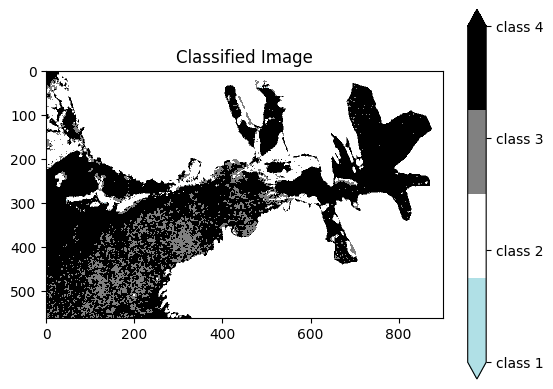

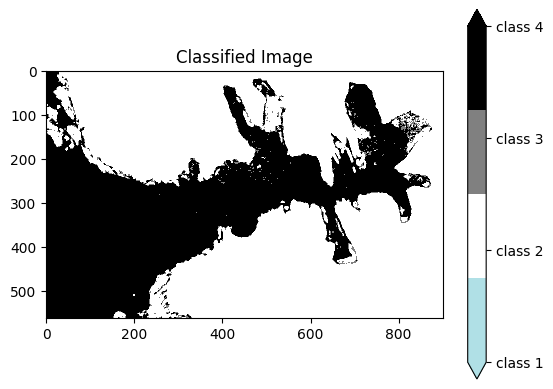

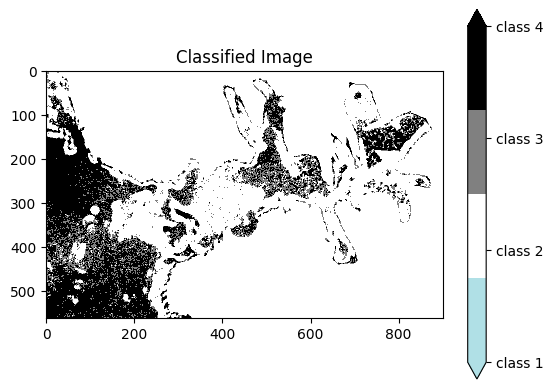

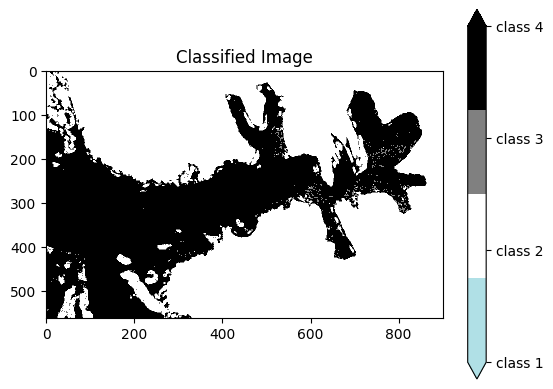

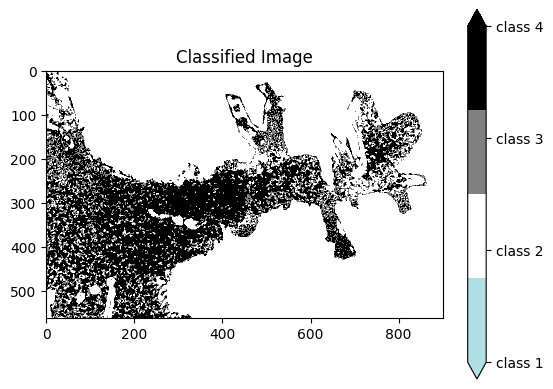

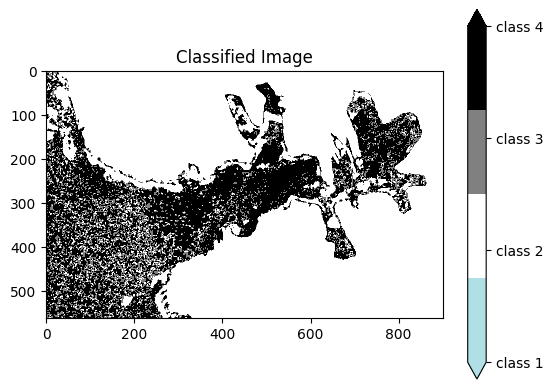

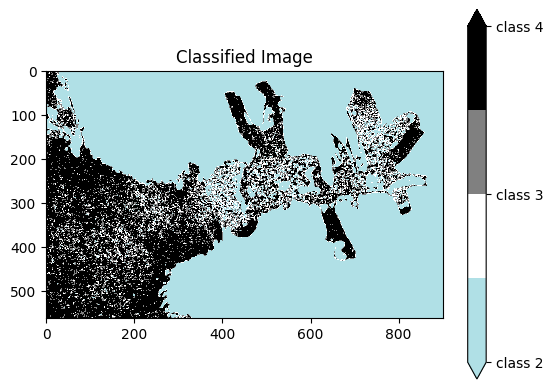

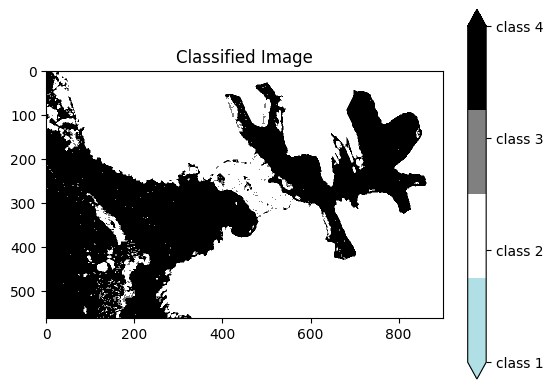

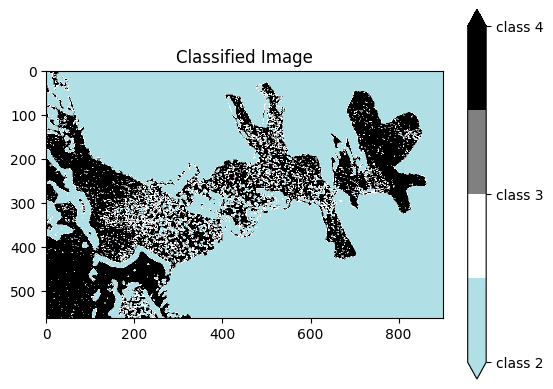

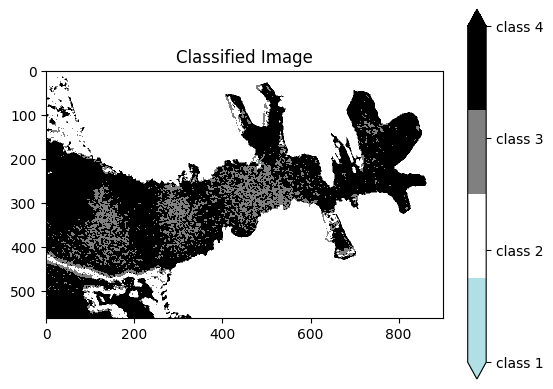

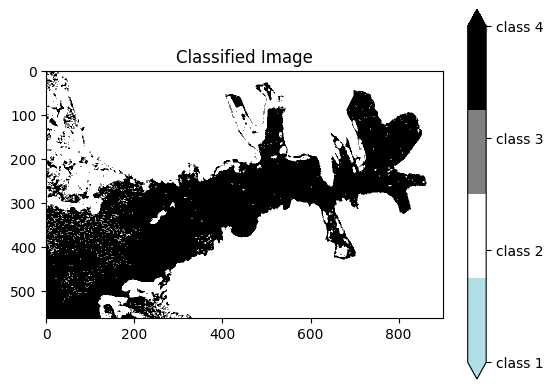

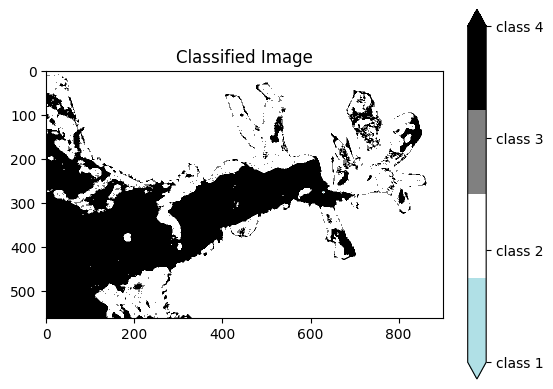

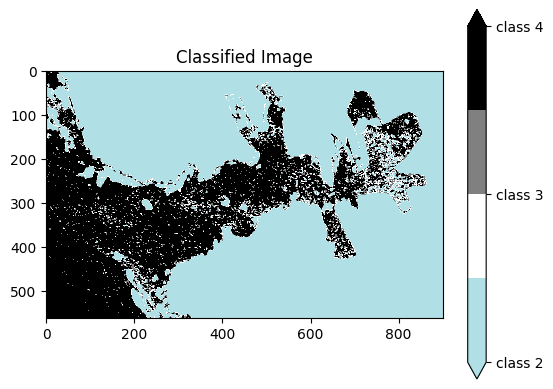

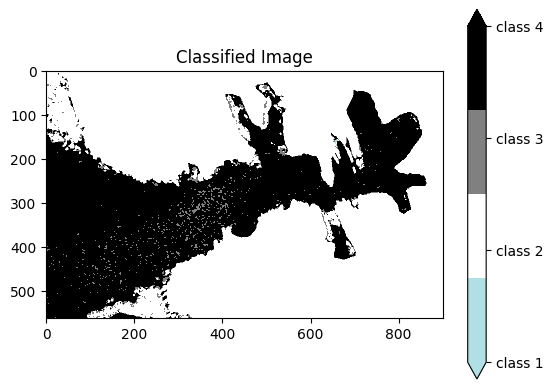

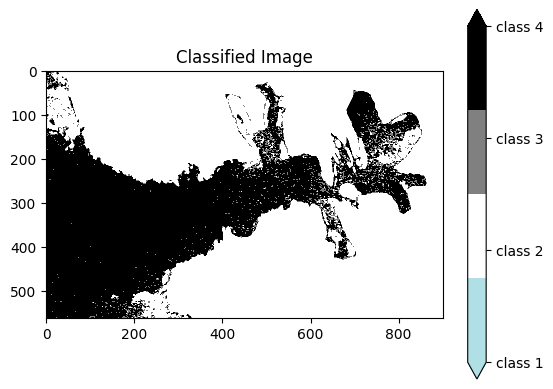

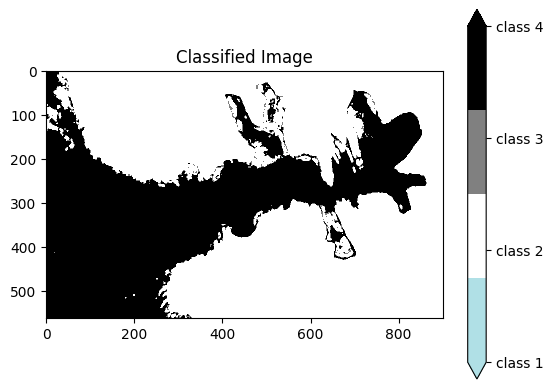

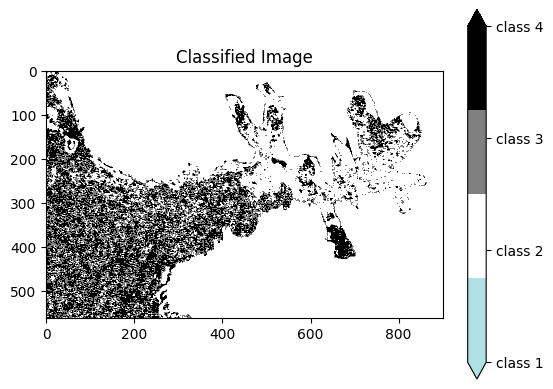

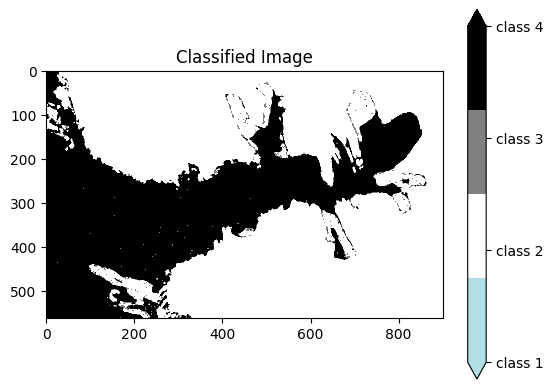

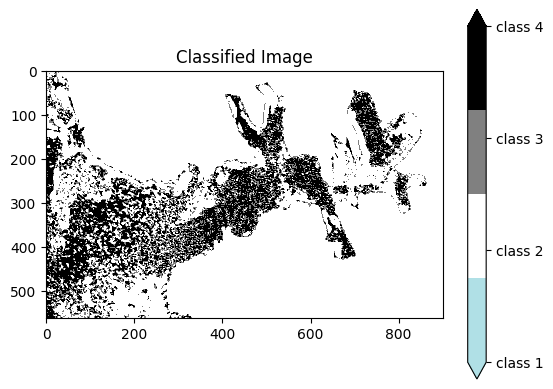

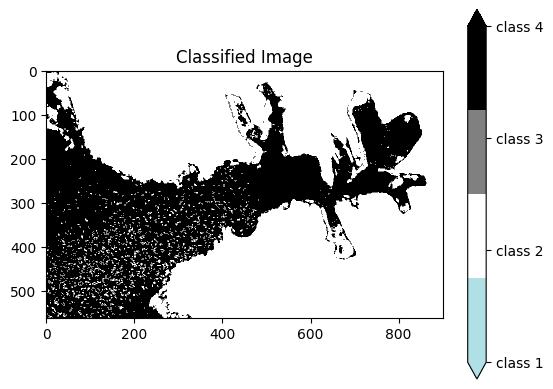

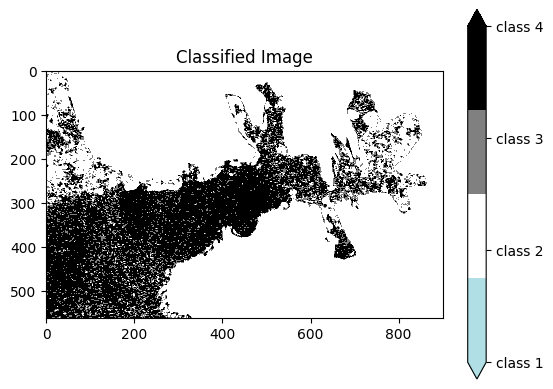

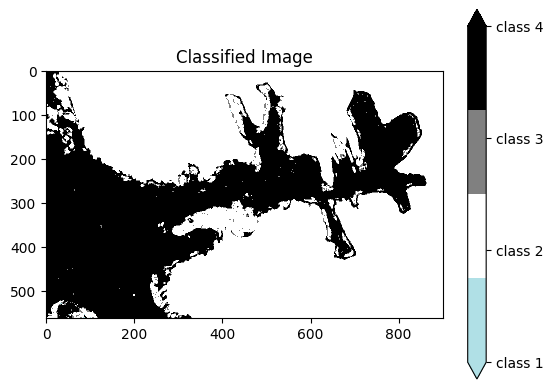

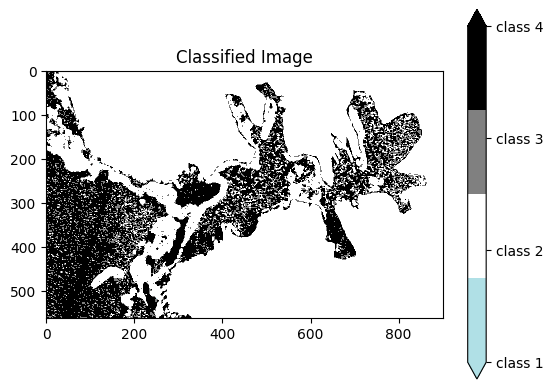

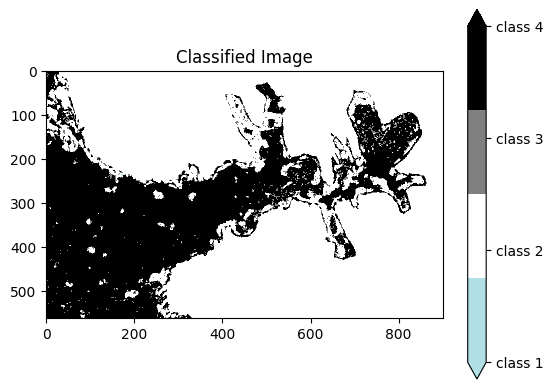

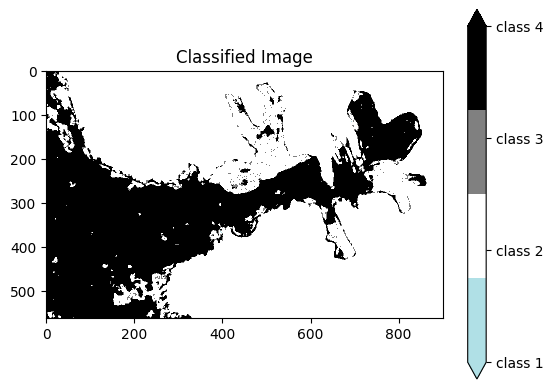

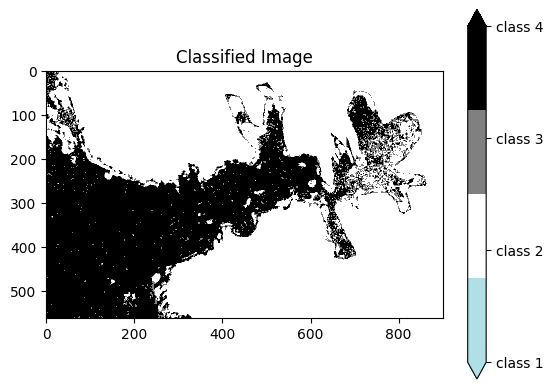

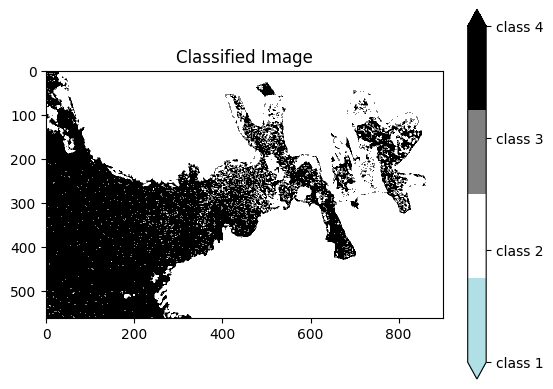

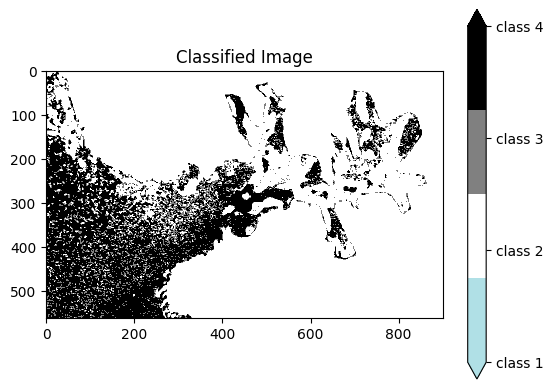

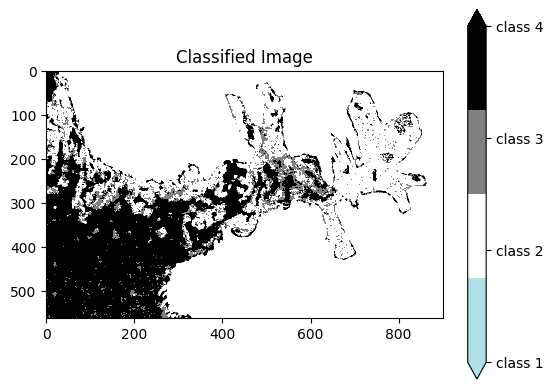

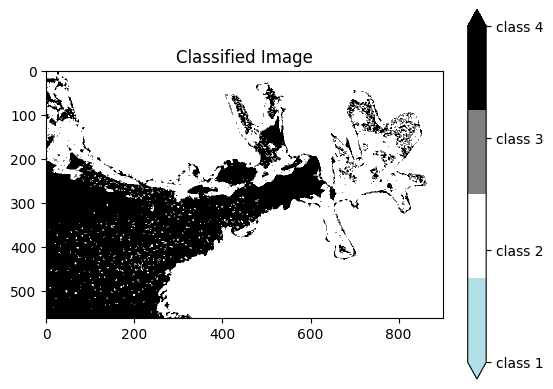

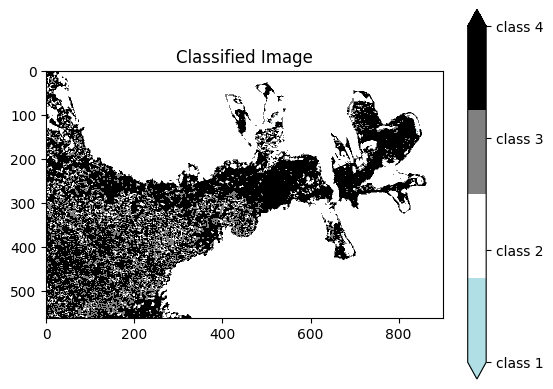

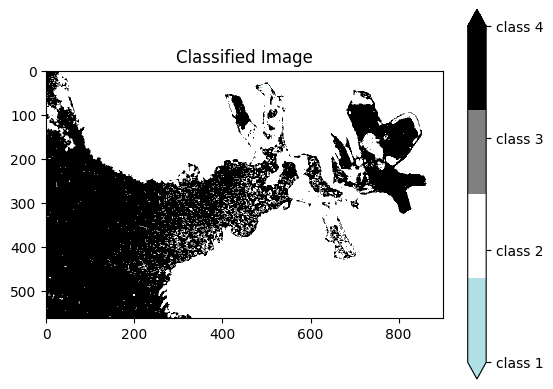

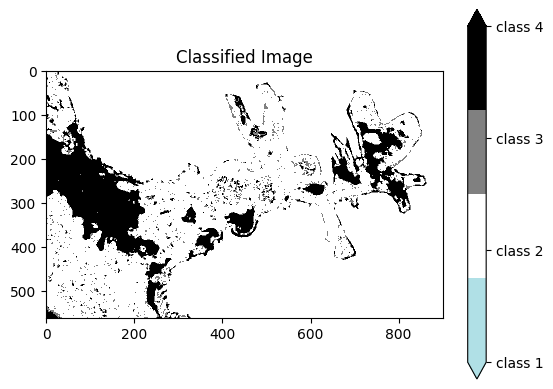

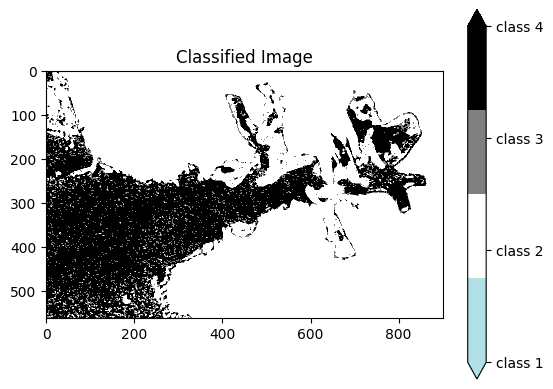

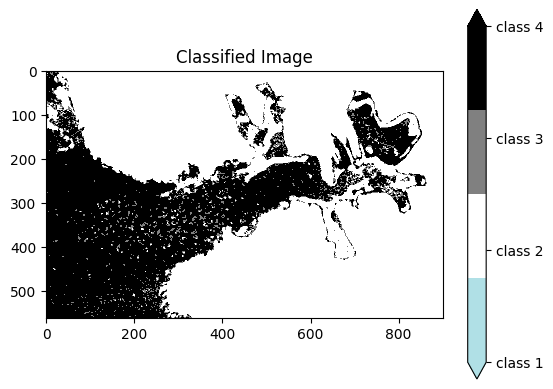

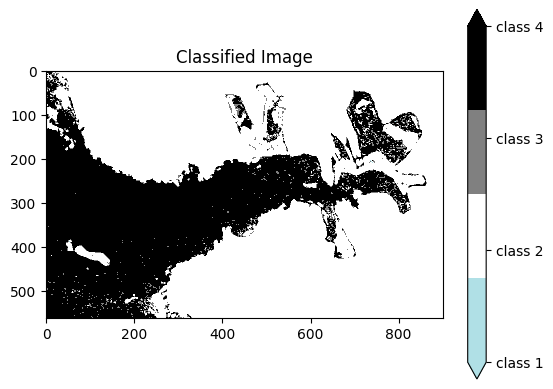

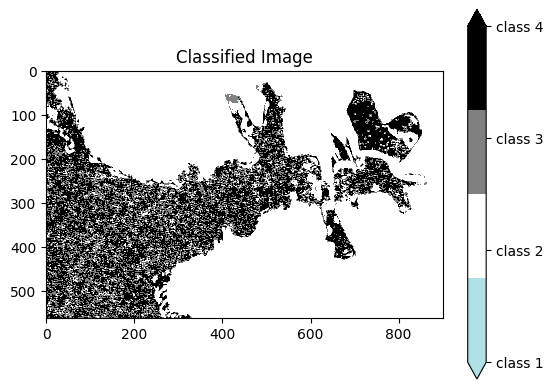

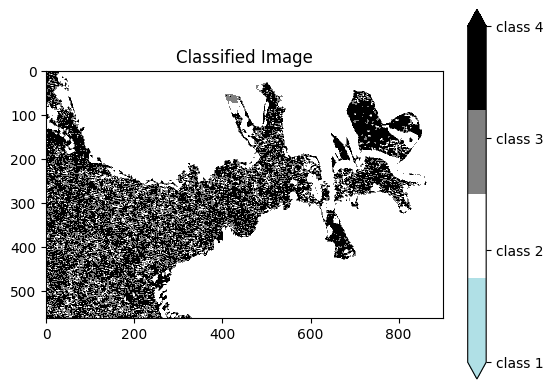

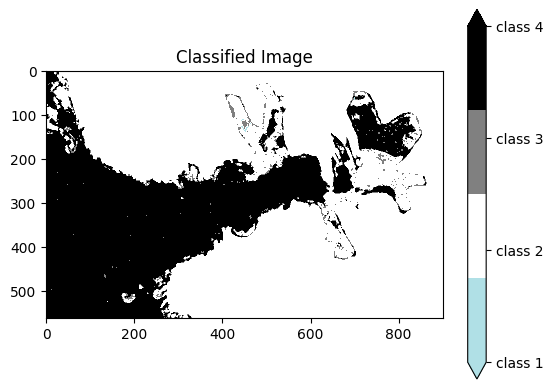

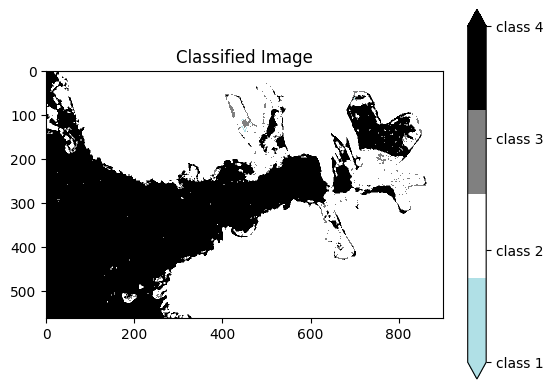

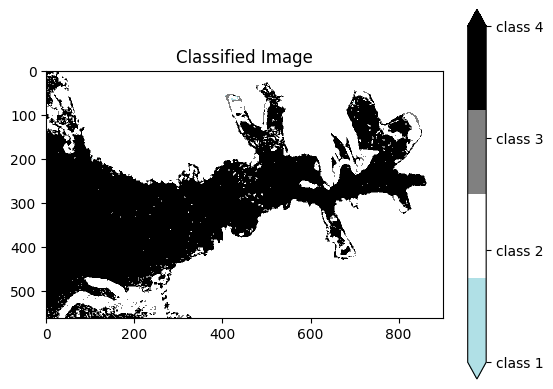

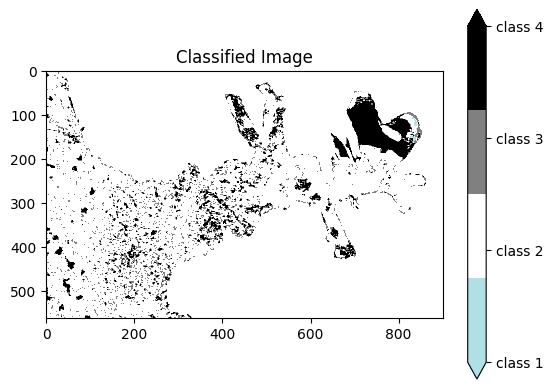

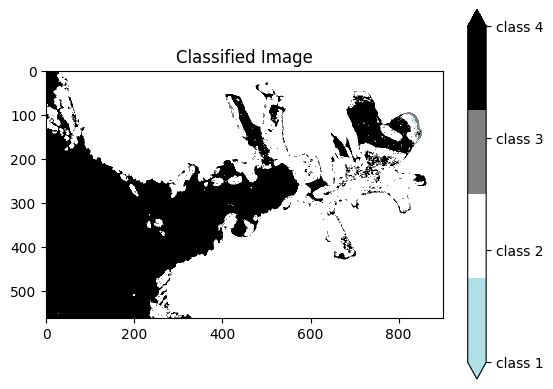

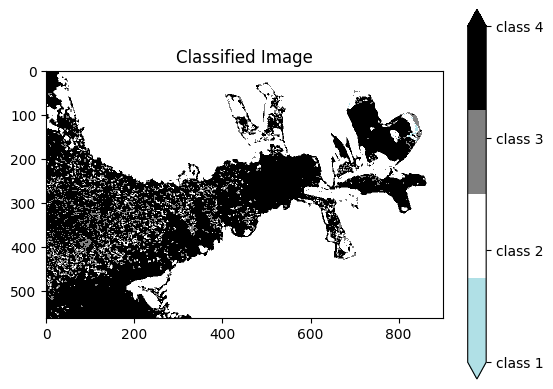

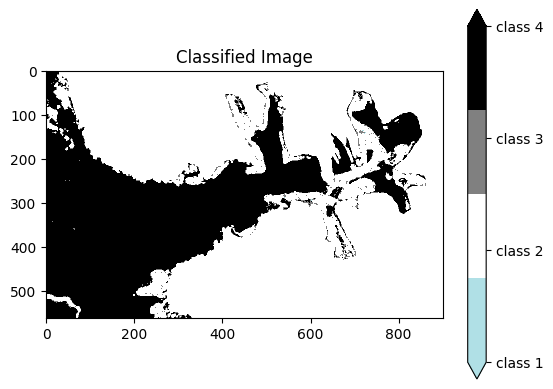

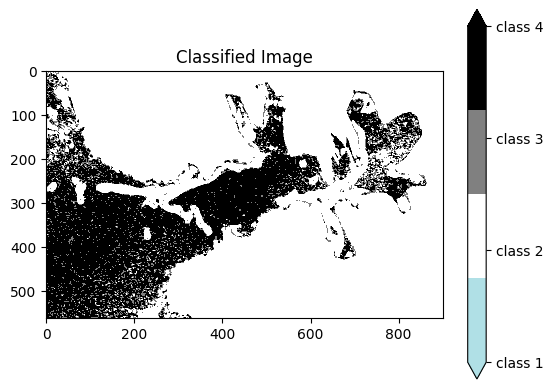

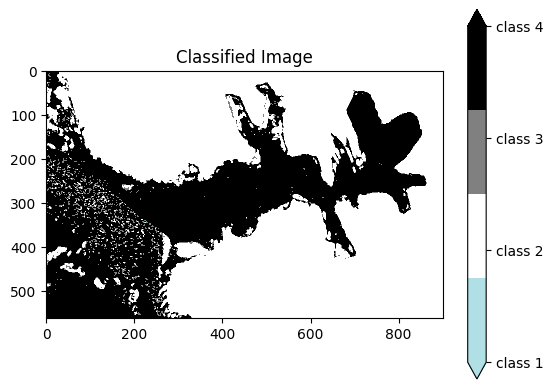

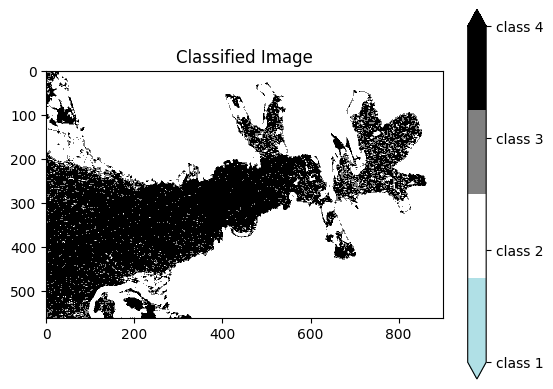

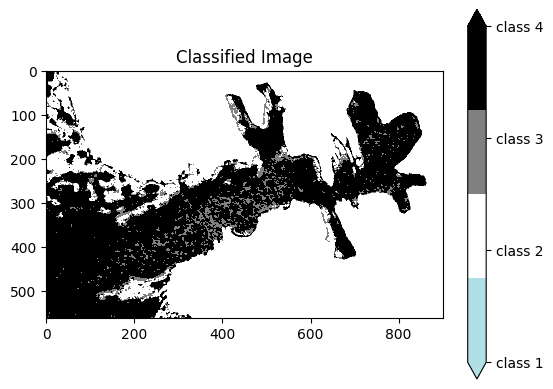

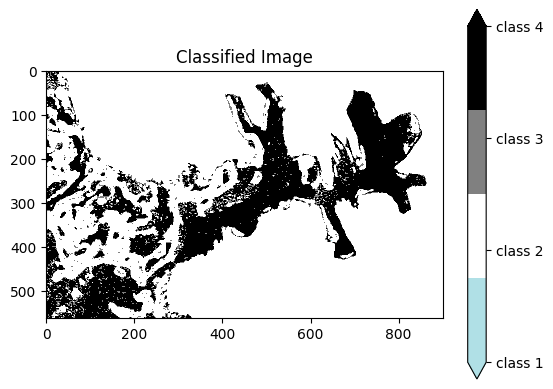

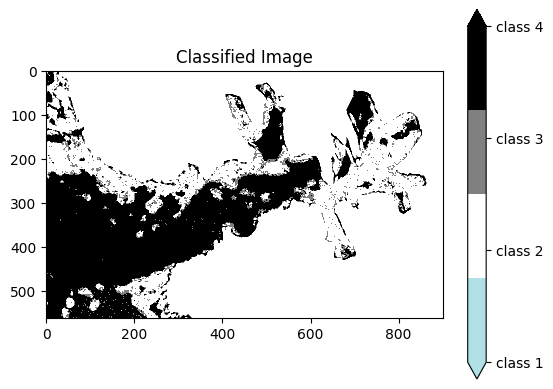

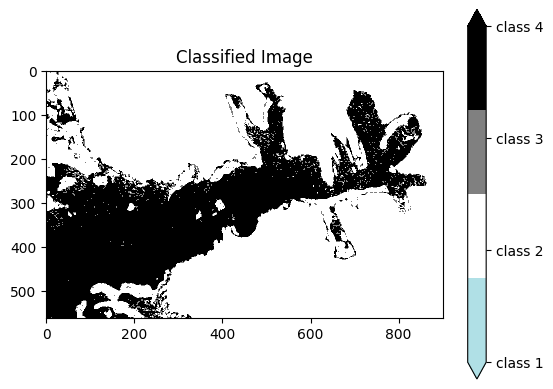

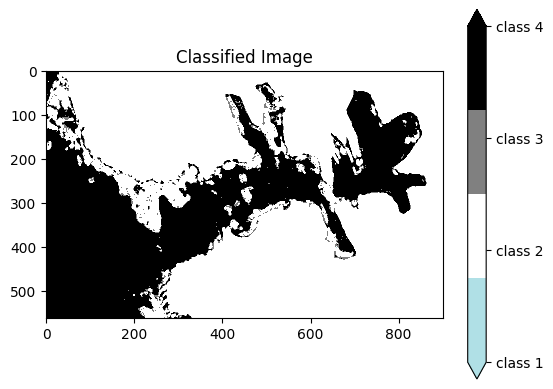

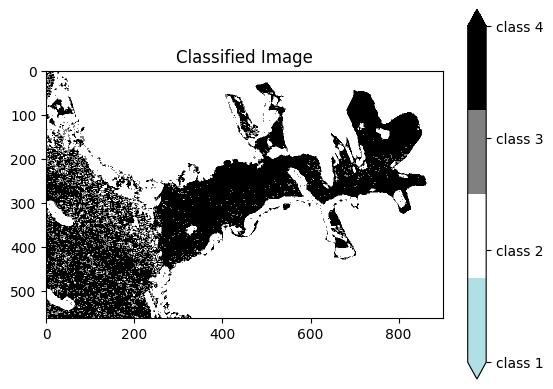

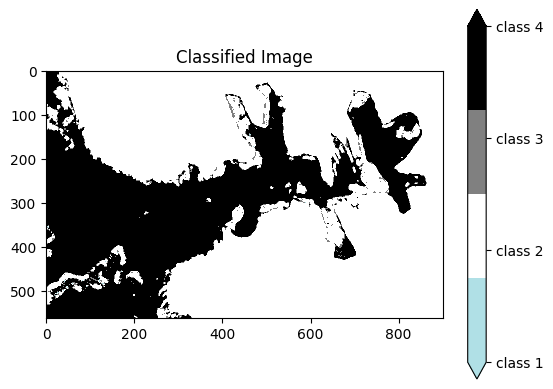

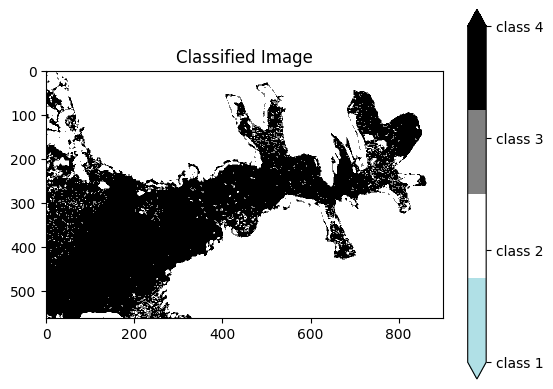

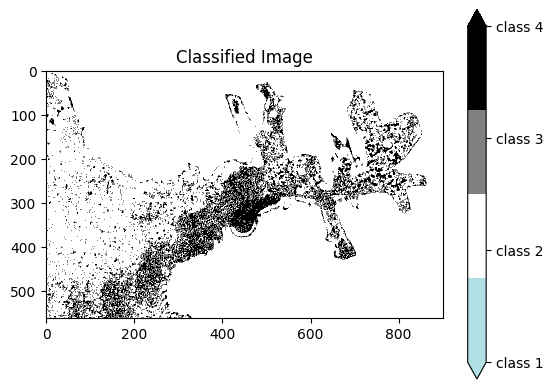

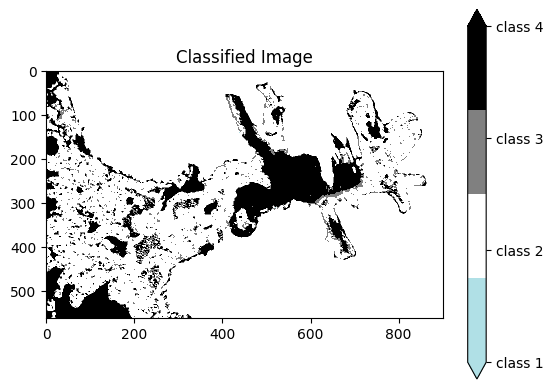

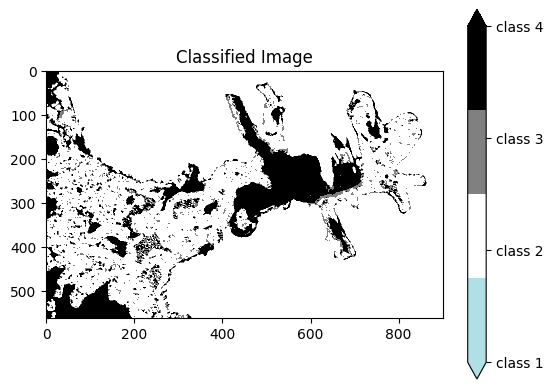

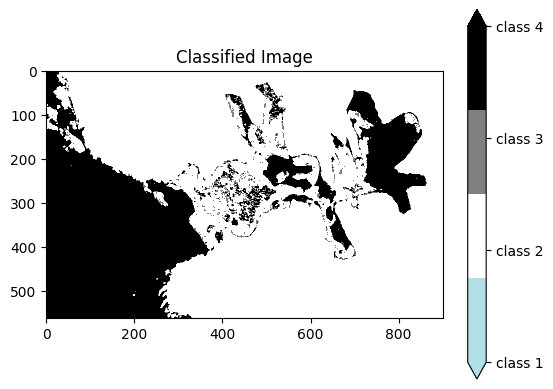

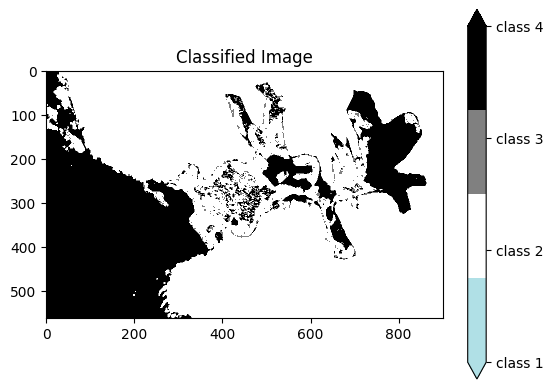

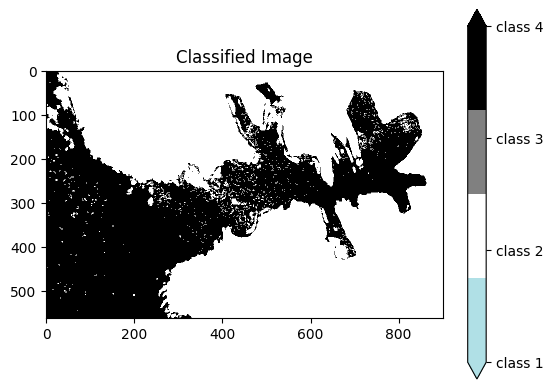

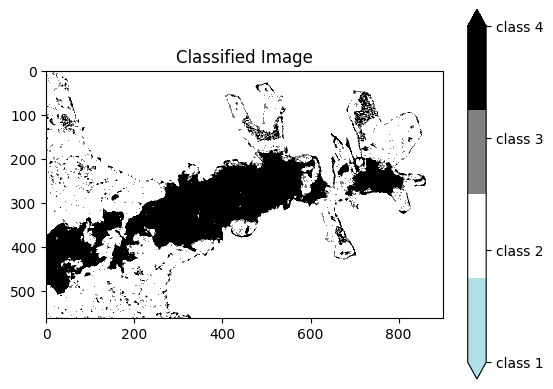

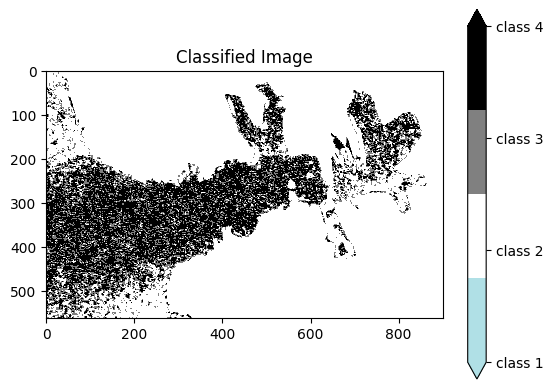

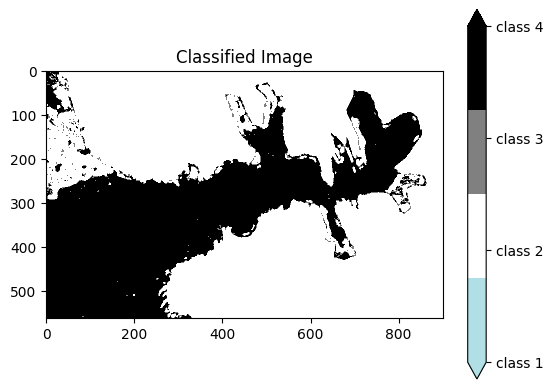

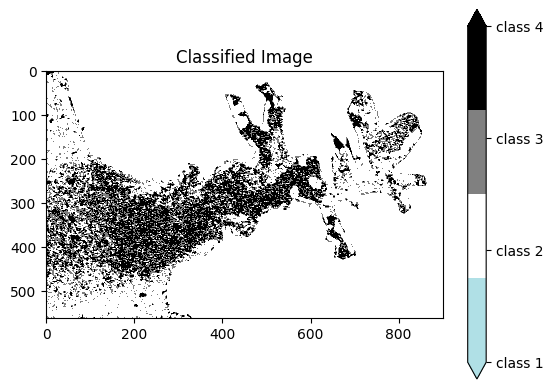

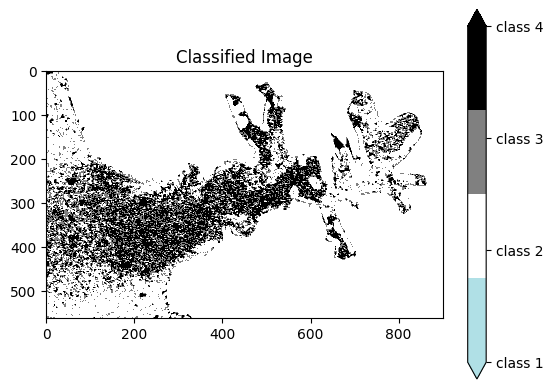

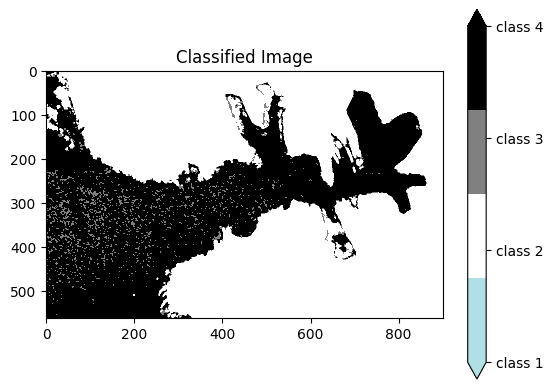

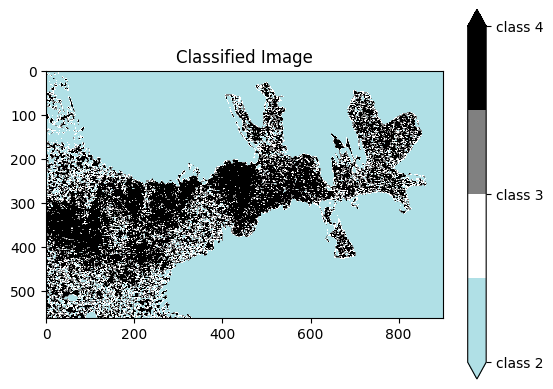

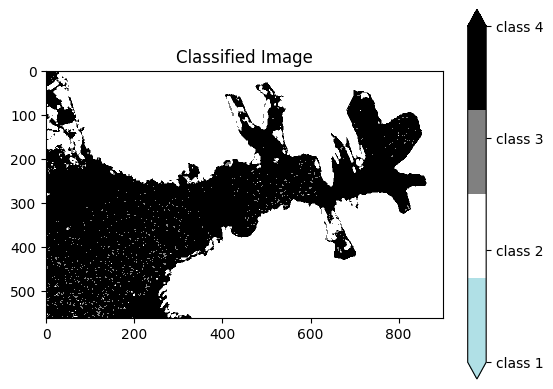

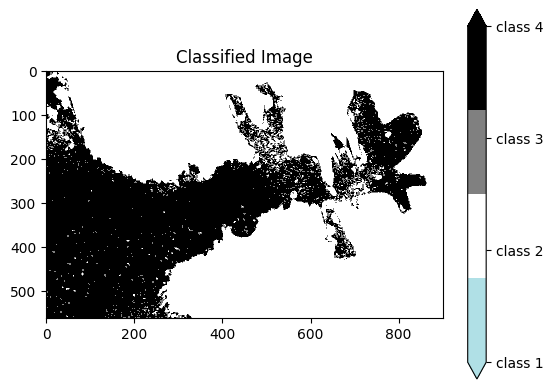

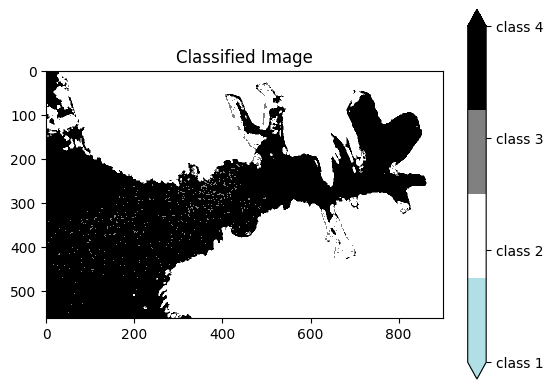

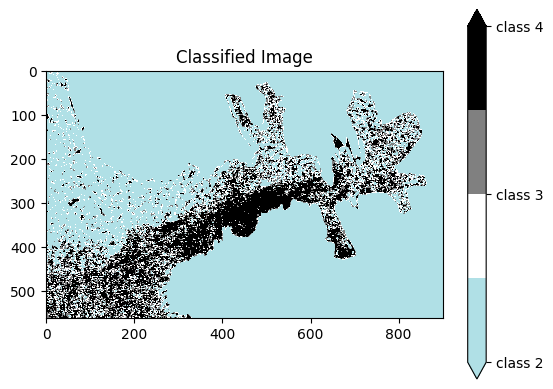

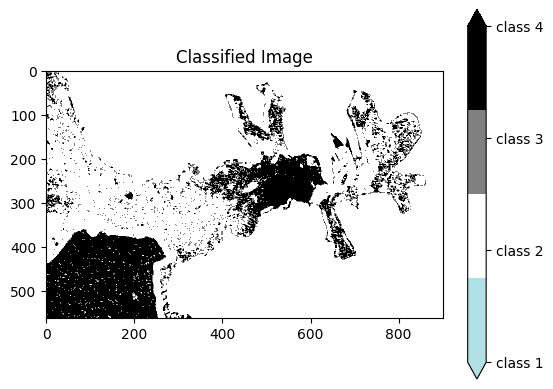

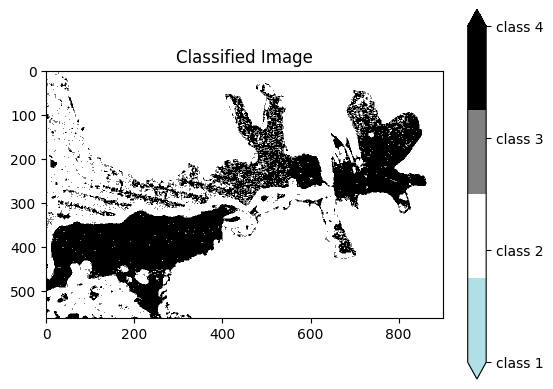

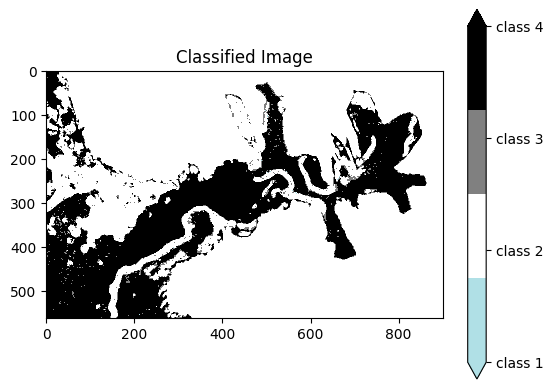

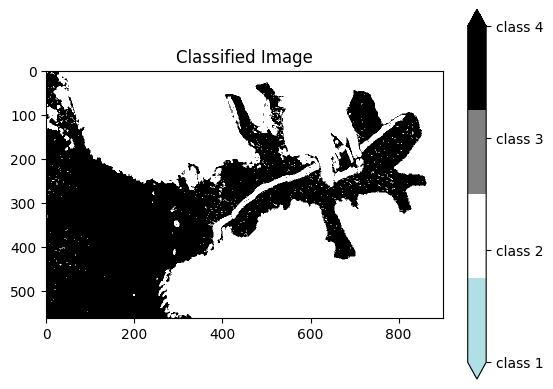

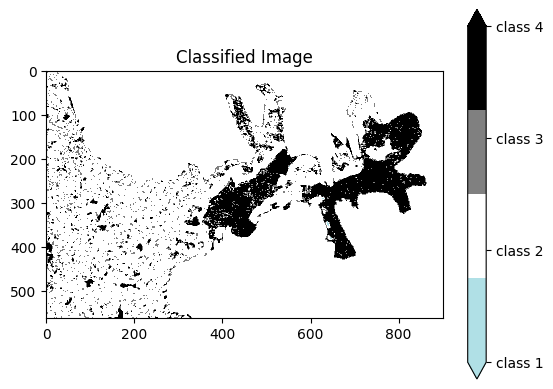

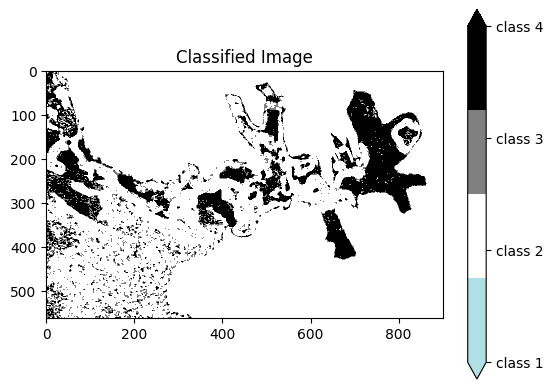

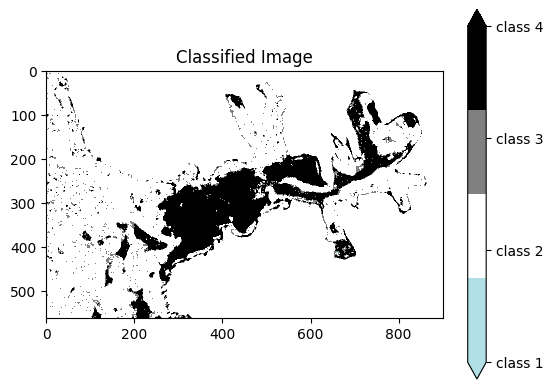

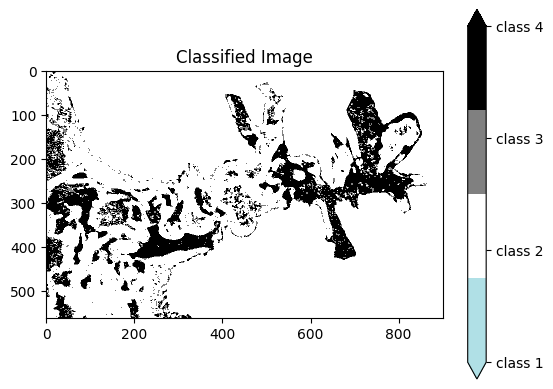

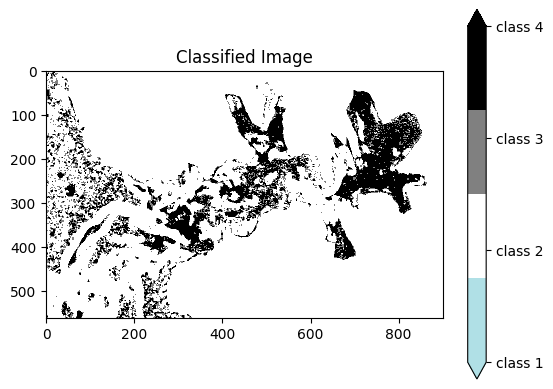

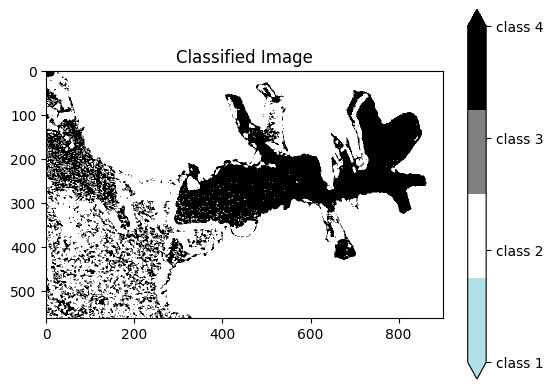

KeyboardInterrupt: 

In [3]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/multi_class_img2/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".png"))

            # tsl_fp = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2011.shp'
            # tsl_shp = gpd.read_file(tsl_fp)
            # def getFeatures(gdf):
            #     """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
            #     import json
            #     return [json.loads(gdf.to_json())['features'][0]['geometry']]
            # tsl_coord = getFeatures(tsl_shp)

    
            # raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/SVM_winter_stack.tif"
            raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
            with rio.open(raster_path) as src:
                image = src.read()  # Read all bands
                profile = src.profile  # Save metadata
                # masked_raster, masked_transform = mask(src, shapes, crop=True)
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)
                b4 = src.read(4)
                b5 = src.read(5)
                b6 = src.read(6)
                b7 = src.read(7)
                b8 = src.read(8)
                b9 = src.read(9)
                b10 = src.read(10)
                b11 = src.read(11)
                b12 = src.read(12)
                b13 = src.read(13)
                b14 = src.read(14)
            
                image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
                
                bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
                bands = bands.reshape(int(np.prod(bands.shape)/14),14)

            
            # Step 2: Load the shapefile
            shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER_.shp"
            shapefile = gpd.read_file(shapefile_path)
            
            # Step 3: Extract training data
            # Assuming the shapefile has a 'class' column for labels
            training_data = []
            labels = []
            
            for _, row in shapefile.iterrows():
                geom = row.geometry
                label = row['Class_']
                mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
                pixels = image[mask]
                training_data.append(pixels)
                labels.extend([label] * len(pixels))
            
            training_data = np.vstack(training_data)
            # training_data = training_data[:, 0:2]
            labels = np.array(labels)

            with rio.open(input_path) as src_:
                image_ = src_.read()  # Read all bands
                profile_ = src_.profile  # Save metadata
                b1_ = src_.read(1)
                b2_ = src_.read(2)
                b3_ = src_.read(3)
                b4_ = src_.read(4)
                b5_ = src_.read(5)
                b6_ = src_.read(6)
                b7_ = src_.read(7)
                b8_ = src_.read(8)
                b9_ = src_.read(9)
                b10_ = src_.read(10)
                b11_ = src_.read(11)
                b12_ = src_.read(12)
                b13_ = src_.read(13)
                b14_ = src_.read(14)
          
                b1_ = np.where(np.isinf(b1_), np.nan, b1_)
                b2_ = np.where(np.isinf(b2_), np.nan, b2_)          
                b3_ = np.where(np.isinf(b3_), np.nan, b3_)
                b4_ = np.where(np.isinf(b4_), np.nan, b4_)
                b5_ = np.where(np.isinf(b5_), np.nan, b5_)
                b6_ = np.where(np.isinf(b6_), np.nan, b6_)
                b7_ = np.where(np.isinf(b7_), np.nan, b7_)
                b8_ = np.where(np.isinf(b8_), np.nan, b8_)
                b9_ = np.where(np.isinf(b9_), np.nan, b9_)
                b10_ = np.where(np.isinf(b10_), np.nan, b10_)
                b11_ = np.where(np.isinf(b11_), np.nan, b11_)
                b12_ = np.where(np.isinf(b12_), np.nan, b12_)
                b13_ = np.where(np.isinf(b13_), np.nan, b13_)
                b14_ = np.where(np.isinf(b14_), np.nan, b14_)

                nan1 = 9
                nan2 = 81

                b1_ = np.nan_to_num(b1_, nan=nan1)
                b2_ = np.nan_to_num(b2_, nan=nan1)
                b3_ = np.nan_to_num(b3_, nan=nan1)
                b4_ = np.nan_to_num(b4_, nan=nan1)
                b5_ = np.nan_to_num(b5_, nan=nan2)
                b6_ = np.nan_to_num(b6_, nan=nan2)
                b7_ = np.nan_to_num(b7_, nan=nan1)
                b8_ = np.nan_to_num(b8_, nan=nan1)
                b9_ = np.nan_to_num(b9_, nan=nan1)
                b10_ = np.nan_to_num(b10_, nan=nan1)
                b11_ = np.nan_to_num(b11_, nan=nan1)
                b12_ = np.nan_to_num(b12_, nan=nan1)
                b13_ = np.nan_to_num(b13_, nan=nan2)
                b14_ = np.nan_to_num(b14_, nan=nan2)
            
                mask1 = (b1_ ==9) & (b1_== 81)
                mask2 = (b2_ ==9) & (b2_== 81)
                mask3 = (b3_ ==9) & (b3_== 81)
                mask4 = (b4_ ==9) & (b4_== 81)
                mask5 = (b5_ ==9) & (b5_== 81)
                mask6 = (b6_ ==9) & (b6_== 81)
                mask7 = (b7_ ==9) & (b7_== 81)
                mask8 = (b8_ ==9) & (b8_== 81)
                mask9 = (b9_ ==9) & (b9_== 81)
                mask10 = (b10_ ==9) & (b10_== 81)
                mask11 = (b11_ ==9) & (b11_== 81)
                mask12 = (b12_ ==9) & (b12_== 81)
                mask13 = (b13_ ==9) & (b13_== 81)
                mask14 = (b14_ ==9) & (b14_== 81)
                
                b1_ = np.ma.masked_array(b1_, mask1)
                b2_ = np.ma.masked_array(b2_, mask2)
                b3_ = np.ma.masked_array(b3_, mask3)
                b4_ = np.ma.masked_array(b4_, mask4)
                b5_ = np.ma.masked_array(b5_, mask5)
                b6_ = np.ma.masked_array(b6_, mask6)
                b7_ = np.ma.masked_array(b7_, mask7)
                b8_ = np.ma.masked_array(b8_, mask8)
                b9_ = np.ma.masked_array(b9_, mask9)
                b10_ = np.ma.masked_array(b10_, mask10)
                b11_ = np.ma.masked_array(b11_, mask11)
                b12_ = np.ma.masked_array(b12_, mask12)
                b13_ = np.ma.masked_array(b13_, mask13)
                b14_ = np.ma.masked_array(b14_, mask14)


                image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
                bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)

                # plt.imshow(b1_)
                # plt.show()
                

                # Step 4: Train the SVM model
                X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
                clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                # Step 5: Classify the image
                predicted = clf.predict(bands_) #Predict using the model
                class_image = predicted.reshape(b1_.shape)
                
                
                # accuracy = accuracy_score(y_test, y_pred)
                # print(f"Accuracy: {accuracy:.2f}")
                
                # # Generate classification report
                # report = classification_report(y_test, y_pred)
                # print(report)
                
                # Step 7: Save and visualize the classified image
                hex_colors = ['#b0e0e6','#ffffff','#808080','#000000']  #powderblue: #b0e0e6
                custom_cmap = ListedColormap(hex_colors)
                plt.imshow(class_image, cmap=custom_cmap)
                plt.colorbar(cmap=custom_cmap,ticks=[1,2,3,4],format=mticker.FixedFormatter(['class 1','class 2','class 3','class 4']),extend='both') #'drift ice'
                    
                plt.title("Classified Image")

                plt.savefig(output_path, dpi=1500,     #resoluton  
                           bbox_inches='tight',  # Tight layout
                           pad_inches=0.1,       # Padding
                           facecolor='white',    # Background color
                           edgecolor='none',     # Edge color
                           format='png')

                plt.show()

#### Code adjustment for specified images

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_15460\157160524.py:165: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 1500x1000 with 2 Axes> which fig.colorbar is called on.
  cbar = fig2.colorbar(image1, ax=axes2, extend='both')


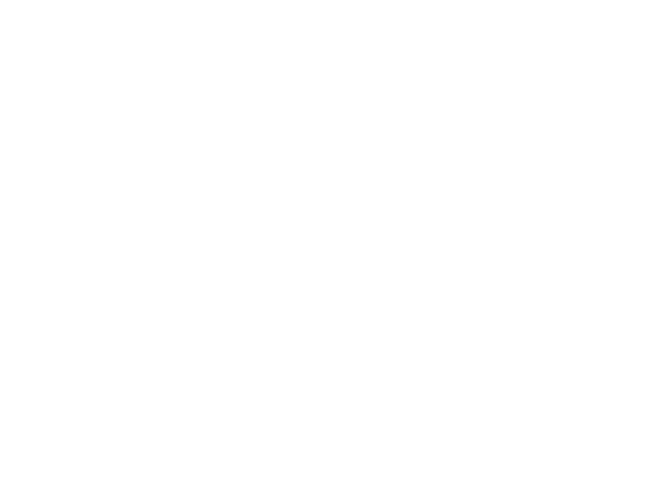

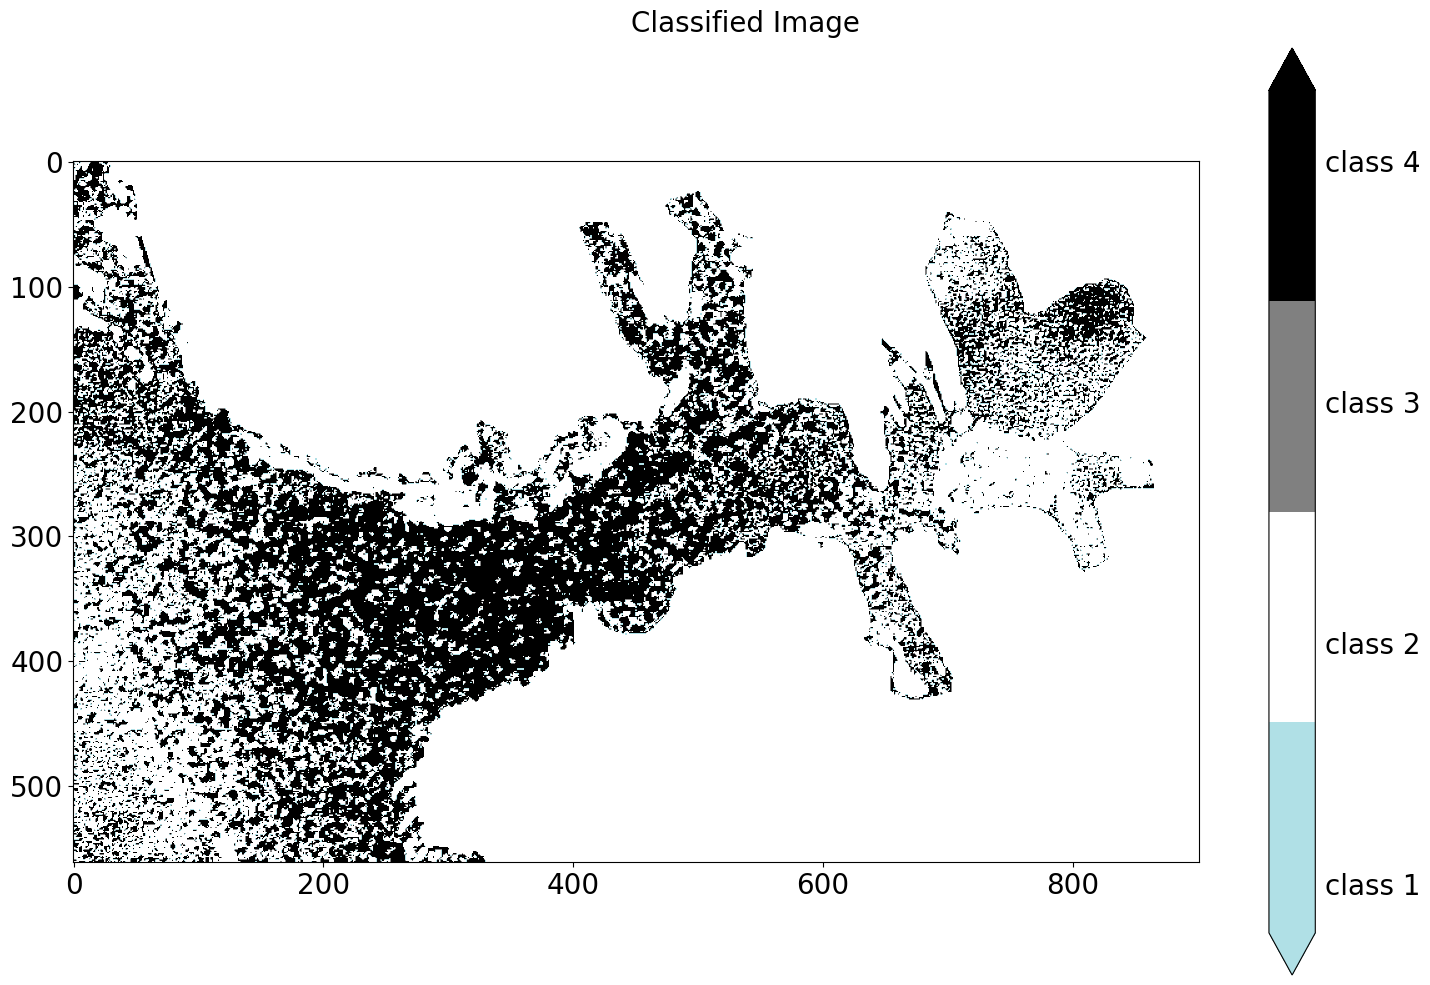

In [19]:
from shapely.geometry import box
with fiona.open("C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2011.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    b14 = src.read(14)

    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/14),14)

raster_path_ = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/RS2_SCNA_20140530_154743_ASC_101_einc_2151620e_d23c_4f37_8124_acd1f4830d75.tif"
# raster_path_ = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/amend/RS2_SCNA_20120620_152657_ASC_258_einc_634ba86b_d89f_4020_aac8_ebd67d2807e0.tif"
with rio.open(raster_path_) as src_:
    image_, transformed = rio.mask.mask(src_, shapes, crop=True, filled=True)
    # image_ = src_.read()  # Read all bands
    profile_ = src_.profile  # Save metadata
    b1_ = src_.read(1)
    b2_ = src_.read(2)
    b3_ = src_.read(3)
    b4_ = src_.read(4)
    b5_ = src_.read(5)
    b6_ = src_.read(6)
    b7_ = src_.read(7)
    b8_ = src_.read(8)
    b9_ = src_.read(9)
    b10_ = src_.read(10)
    b11_ = src_.read(11)
    b12_ = src_.read(12)
    b13_ = src_.read(13)
    b14_ = src_.read(14)

    b1_ = np.where(np.isinf(b1_), np.nan, b1_)
    b2_ = np.where(np.isinf(b2_), np.nan, b2_)          
    b3_ = np.where(np.isinf(b3_), np.nan, b3_)
    b4_ = np.where(np.isinf(b4_), np.nan, b4_)
    b5_ = np.where(np.isinf(b5_), np.nan, b5_)
    b6_ = np.where(np.isinf(b6_), np.nan, b6_)
    b7_ = np.where(np.isinf(b7_), np.nan, b7_)
    b8_ = np.where(np.isinf(b8_), np.nan, b8_)
    b9_ = np.where(np.isinf(b9_), np.nan, b9_)
    b10_ = np.where(np.isinf(b10_), np.nan, b10_)
    b11_ = np.where(np.isinf(b11_), np.nan, b11_)
    b12_ = np.where(np.isinf(b12_), np.nan, b12_)
    b13_ = np.where(np.isinf(b13_), np.nan, b13_)
    b14_ = np.where(np.isinf(b14_), np.nan, b14_)
                
    nan1 = 9
    nan2 = 81
    
    b1_ = np.nan_to_num(b1_, nan=nan1)
    b2_ = np.nan_to_num(b2_, nan=nan1)
    b3_ = np.nan_to_num(b3_, nan=nan1)
    b4_ = np.nan_to_num(b4_, nan=nan1)
    b5_ = np.nan_to_num(b5_, nan=nan2)
    b6_ = np.nan_to_num(b6_, nan=nan2)
    b7_ = np.nan_to_num(b7_, nan=nan1)
    b8_ = np.nan_to_num(b8_, nan=nan1)
    b9_ = np.nan_to_num(b9_, nan=nan1)
    b10_ = np.nan_to_num(b10_, nan=nan1)
    b11_ = np.nan_to_num(b11_, nan=nan1)
    b12_ = np.nan_to_num(b12_, nan=nan1)
    b13_ = np.nan_to_num(b13_, nan=nan2)
    b14_ = np.nan_to_num(b14_, nan=nan2)


    mask1 = (b1_ ==9) & (b1_== 81)
    mask2 = (b2_ ==9) & (b2_== 81)
    mask3 = (b3_ ==9) & (b3_== 81)
    mask4 = (b4_ ==9) & (b4_== 81)
    mask5 = (b5_ ==9) & (b5_== 81)
    mask6 = (b6_ ==9) & (b6_== 81)
    mask7 = (b7_ ==9) & (b7_== 81)
    mask8 = (b8_ ==9) & (b8_== 81)
    mask9 = (b9_ ==9) & (b9_== 81)
    mask10 = (b10_ ==9) & (b10_== 81)
    mask11 = (b11_ ==9) & (b11_== 81)
    mask12 = (b12_ ==9) & (b12_== 81)
    mask13 = (b13_ ==9) & (b13_== 81)
    mask14 = (b14_ ==9) & (b14_== 81)
    
    b1_ = np.ma.masked_array(b1_, mask1)
    b2_ = np.ma.masked_array(b2_, mask2)
    b3_ = np.ma.masked_array(b3_, mask3)
    b4_ = np.ma.masked_array(b4_, mask4)
    b5_ = np.ma.masked_array(b5_, mask5)
    b6_ = np.ma.masked_array(b6_, mask6)
    b7_ = np.ma.masked_array(b7_, mask7)
    b8_ = np.ma.masked_array(b8_, mask8)
    b9_ = np.ma.masked_array(b9_, mask9)
    b10_ = np.ma.masked_array(b10_, mask10)
    b11_ = np.ma.masked_array(b11_, mask11)
    b12_ = np.ma.masked_array(b12_, mask12)
    b13_ = np.ma.masked_array(b13_, mask13)
    b14_ = np.ma.masked_array(b14_, mask14)

    image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)

    bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
    bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)


# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

# Step 4: Train the SVM model
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
clf.fit(X_train, y_train)

# Step 5: Classify the image
predicted = clf.predict(bands_) #Predict using the model
class_image = predicted.reshape(b1_.shape)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(y_test, y_pred)
# print(report)

cmap_ = ListedColormap(['white','powderblue','gray','black'])
cmap_1 = ListedColormap(['powderblue','white','gray','black'])
fig1, axes1 = plt.subplots()
fig2, axes2 = plt.subplots(figsize=(15, 10))
image1 = axes1.imshow(class_image, cmap=cmap_1)
fig1.gca().set_visible(False)
image2 = axes2.imshow(class_image,cmap=cmap_)
cbar = fig2.colorbar(image1, ax=axes2, extend='both')
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['class 1','class 2','class 3','class 4']):
    cbar.ax.text(1.2, (4 * j + 1) / 14.0, lab, ha='left', va='top',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig2.suptitle("Classified Image",fontsize=20)
fig2.subplots_adjust(top=1.0)
plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/amend_classification_SVM/img.png',dpi=1500,     #resoluton  
           bbox_inches='tight',  # Tight layout
           pad_inches=0.1,       # Padding
           facecolor='white',    # Background color
           edgecolor='none',     # Edge color
           format='png')
plt.tight_layout()
plt.show()

#### SCWA convention 08-09 - Code adjustment for specified images

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_15460\3621028661.py:166: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 1500x1000 with 2 Axes> which fig.colorbar is called on.
  cbar = fig2.colorbar(image1, ax=axes2, extend='both')


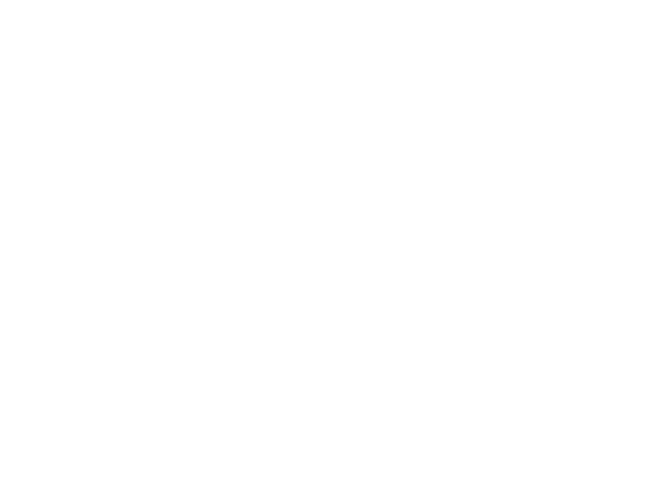

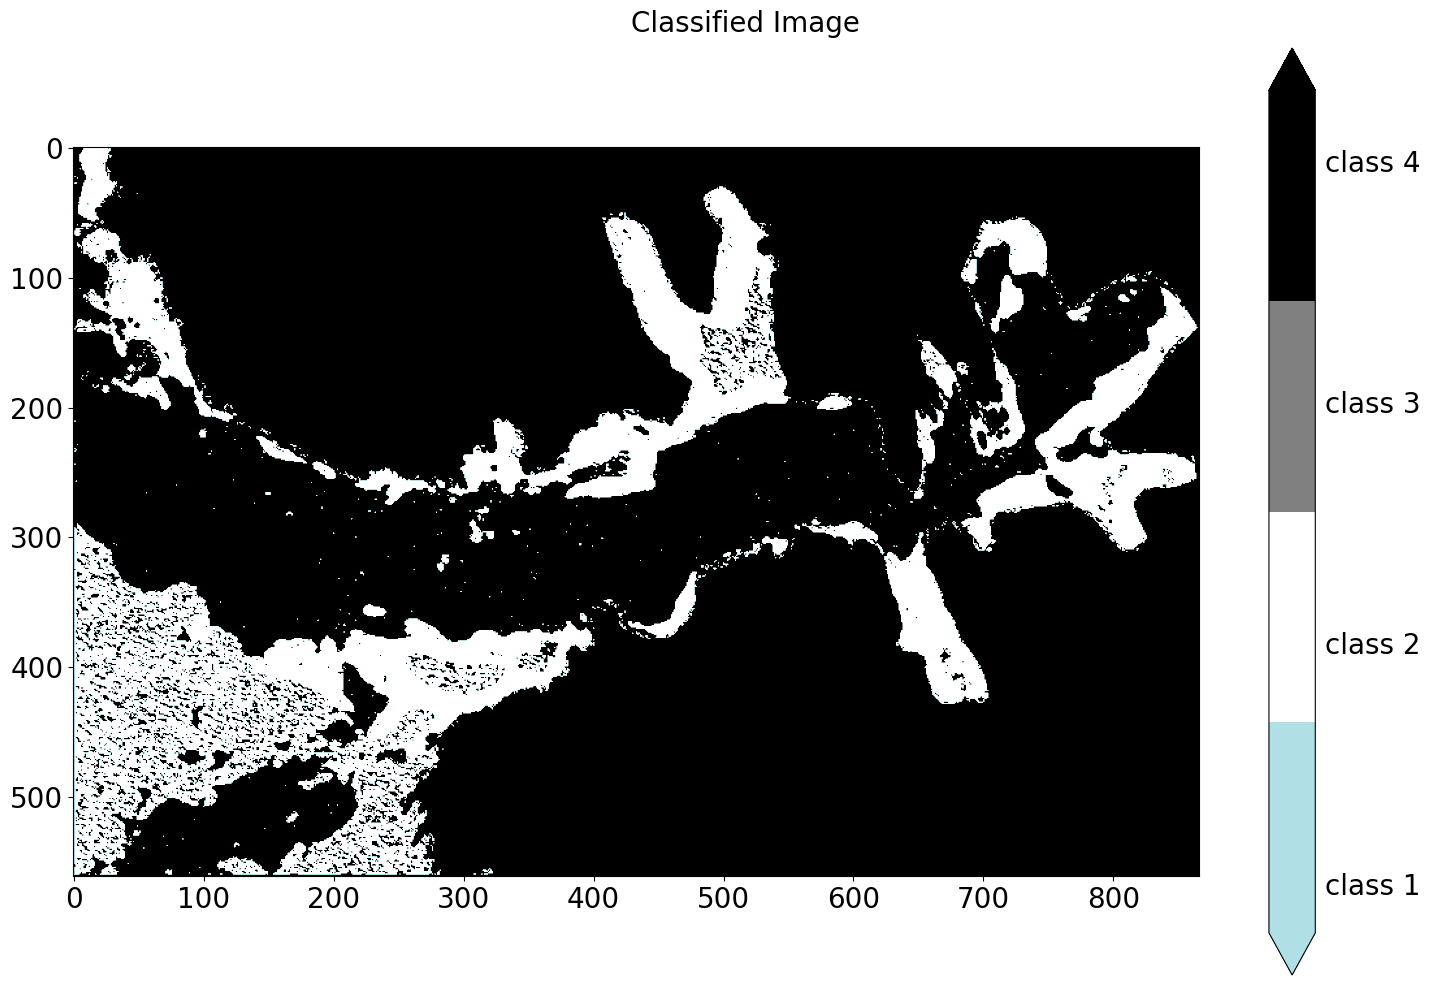

In [9]:
from shapely.geometry import box
with fiona.open("C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2011.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
with rio.open(raster_path) as src:
    image = src.read()  # Read all bands
    profile = src.profile  # Save metadata
    b1 = src.read(1)
    b2 = src.read(2)
    b3 = src.read(3)
    b4 = src.read(4)
    b5 = src.read(5)
    b6 = src.read(6)
    b7 = src.read(7)
    b8 = src.read(8)
    b9 = src.read(9)
    b10 = src.read(10)
    b11 = src.read(11)
    b12 = src.read(12)
    b13 = src.read(13)
    b14 = src.read(14)

    image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)

    bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
    bands = bands.reshape(int(np.prod(bands.shape)/14),14)

# raster_path_ = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/RS2_SCNA_20130628_154748_ASC_101_einc_9f05602b_4f4d_408d_bd24_4a090af4f0d0.tif"
raster_path_ = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/3band_/amend/RS2_SCWA_20081203_063924_DES_267_einc_3338ff02_2328_4a92_9aae_707e7058eb4f.tif"
with rio.open(raster_path_) as src_:
    image_, transformed = rio.mask.mask(src_, shapes, crop=True, filled=True)
    # image_ = src_.read()  # Read all bands
    profile_ = src_.profile  # Save metadata
    b1_ = src_.read(1)
    b2_ = src_.read(2)
    b3_ = src_.read(3)
    b4_ = src_.read(4)
    b5_ = src_.read(5)
    b6_ = src_.read(6)
    b7_ = src_.read(7)
    b8_ = src_.read(8)
    b9_ = src_.read(9)
    b10_ = src_.read(10)
    b11_ = src_.read(11)
    b12_ = src_.read(12)
    b13_ = src_.read(13)
    b14_ = src_.read(14)

    b1_ = np.where(np.isinf(b1_), np.nan, b1_)
    b2_ = np.where(np.isinf(b2_), np.nan, b2_)          
    b3_ = np.where(np.isinf(b3_), np.nan, b3_)
    b4_ = np.where(np.isinf(b4_), np.nan, b4_)
    b5_ = np.where(np.isinf(b5_), np.nan, b5_)
    b6_ = np.where(np.isinf(b6_), np.nan, b6_)
    b7_ = np.where(np.isinf(b7_), np.nan, b7_)
    b8_ = np.where(np.isinf(b8_), np.nan, b8_)
    b9_ = np.where(np.isinf(b9_), np.nan, b9_)
    b10_ = np.where(np.isinf(b10_), np.nan, b10_)
    b11_ = np.where(np.isinf(b11_), np.nan, b11_)
    b12_ = np.where(np.isinf(b12_), np.nan, b12_)
    b13_ = np.where(np.isinf(b13_), np.nan, b13_)
    b14_ = np.where(np.isinf(b14_), np.nan, b14_)
                
    nan1 = -50
    nan2 = 206
    nan3 = 196
    
    b1_ = np.nan_to_num(b1_, nan=nan1)
    b2_ = np.nan_to_num(b2_, nan=nan1)
    b3_ = np.nan_to_num(b3_, nan=nan2)
    b4_ = np.nan_to_num(b4_, nan=nan2)
    b5_ = np.nan_to_num(b5_, nan=nan3)
    b6_ = np.nan_to_num(b6_, nan=nan1)
    b7_ = np.nan_to_num(b7_, nan=nan1)
    b8_ = np.nan_to_num(b8_, nan=nan1)
    b9_ = np.nan_to_num(b9_, nan=nan1)
    b10_ = np.nan_to_num(b10_, nan=nan1)
    b11_ = np.nan_to_num(b11_, nan=nan2)
    b12_ = np.nan_to_num(b12_, nan=nan2)
    b13_ = np.nan_to_num(b13_, nan=nan3)
    b14_ = np.nan_to_num(b14_, nan=nan3)


    mask1 = (b1_ ==-50)
    mask2 = (b2_ ==-50)
    mask3 = (b3_ ==206)
    mask4 = (b4_ ==206)
    mask5 = (b5_ ==196)
    mask6 = (b6_ ==196)
    mask7 = (b7_ ==196)
    mask8 = (b8_ ==196)
    mask9 = (b9_ ==196)
    mask10 = (b10_ ==196)
    mask11 = (b11_ ==206)
    mask12 = (b12_ ==206)
    mask13 = (b13_ ==196)
    mask14 = (b14_ ==196)
    
    b1_ = np.ma.masked_array(b1_, mask1)
    b2_ = np.ma.masked_array(b2_, mask2)
    b3_ = np.ma.masked_array(b3_, mask3)
    b4_ = np.ma.masked_array(b4_, mask4)
    b5_ = np.ma.masked_array(b5_, mask5)
    b6_ = np.ma.masked_array(b6_, mask6)
    b7_ = np.ma.masked_array(b7_, mask7)
    b8_ = np.ma.masked_array(b8_, mask8)
    b9_ = np.ma.masked_array(b9_, mask9)
    b10_ = np.ma.masked_array(b10_, mask10)
    b11_ = np.ma.masked_array(b11_, mask11)
    b12_ = np.ma.masked_array(b12_, mask12)
    b13_ = np.ma.masked_array(b13_, mask13)
    b14_ = np.ma.masked_array(b14_, mask14)

    image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)

    bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
    bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)


# Step 2: Load the shapefile
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER.shp"
shapefile = gpd.read_file(shapefile_path)

# Step 3: Extract training data
# Assuming the shapefile has a 'class' column for labels
training_data = []
labels = []

for _, row in shapefile.iterrows():
    geom = row.geometry
    label = row['Class']
    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
    pixels = image[mask]
    training_data.append(pixels)
    labels.extend([label] * len(pixels))

training_data = np.vstack(training_data)
labels = np.array(labels)

# Step 4: Train the SVM model
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3))
clf.fit(X_train, y_train)

# Step 5: Classify the image
predicted = clf.predict(bands_) #Predict using the model
class_image = predicted.reshape(b1_.shape)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(y_test, y_pred)
# print(report)

cmap_ = ListedColormap(['white','powderblue','gray','black'])
cmap_1 = ListedColormap(['powderblue','white','gray','black'])
fig1, axes1 = plt.subplots()
fig2, axes2 = plt.subplots(figsize=(15, 10))
image1 = axes1.imshow(class_image, cmap=cmap_1)
fig1.gca().set_visible(False)
image2 = axes2.imshow(class_image,cmap=cmap_)
cbar = fig2.colorbar(image1, ax=axes2, extend='both')
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['class 1','class 2','class 3','class 4']):
    cbar.ax.text(1.2, (4 * j + 1) / 14.0, lab, ha='left', va='top',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig2.suptitle("Classified Image",fontsize=20)
fig2.subplots_adjust(top=1.0)
plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/amend_classification_SVM/img.png',dpi=1500,     #resoluton  
           bbox_inches='tight',  # Tight layout
           pad_inches=0.1,       # Padding
           facecolor='white',    # Background color
           edgecolor='none',     # Edge color
           format='png')
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/winter_classed_RF/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".png"))


            # raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/SVM_winter_stack.tif"
            raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
            with rio.open(raster_path) as src:
                image = src.read()  # Read all bands
                profile = src.profile  # Save metadata
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)
                b4 = src.read(4)
                b5 = src.read(5)
                b6 = src.read(6)
                b7 = src.read(7)
                b8 = src.read(8)
                b9 = src.read(9)
                b10 = src.read(10)
                b11 = src.read(11)
                b12 = src.read(12)
                b13 = src.read(13)
                b14 = src.read(14)
            
                image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
                bands = bands.reshape(int(np.prod(bands.shape)/14),14)
            
            # Step 2: Load the shapefile
            shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER_.shp"
            shapefile = gpd.read_file(shapefile_path)
            
            # Step 3: Extract training data
            # Assuming the shapefile has a 'class' column for labels
            training_data = []
            labels = []
            
            for _, row in shapefile.iterrows():
                geom = row.geometry
                label = row['Class_']
                mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
                pixels = image[mask]
                training_data.append(pixels)
                labels.extend([label] * len(pixels))
            
            training_data = np.vstack(training_data)
            labels = np.array(labels)


            with rio.open(input_path) as src_:
                image_ = src_.read()  # Read all bands
                profile_ = src_.profile  # Save metadata
                b1_ = src_.read(1)
                b2_ = src_.read(2)
                b3_ = src_.read(3)
                b4_ = src_.read(4)
                b5_ = src_.read(5)
                b6_ = src_.read(6)
                b7_ = src_.read(7)
                b8_ = src_.read(8)
                b9_ = src_.read(9)
                b10_ = src_.read(10)
                b11_ = src_.read(11)
                b12_ = src_.read(12)
                b13_ = src_.read(13)
                b14_ = src_.read(14)


                image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
                bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)
    

                X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
                
                # Initialize the Random Forest Classifier
                rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
                
                # Train the model
                rf_classifier.fit(X_train, Y_train)
                
                # Make predictions
                y_pred = rf_classifier.predict(X_test)
                RF_pred = rf_classifier.predict(bands_) #Predict using the model
                climage = RF_pred.reshape(b1_.shape)
                
                # Step 7: Save and visualize the classified image
                cmap = ListedColormap(['black', 'gray'])
                plt.imshow(climage, cmap=cmap)
                plt.colorbar(ticks=[0, 1])
                plt.title("Classified Image")

                
                # plt.savefig(output_path, dpi=1500,     #resoluton  
                #            bbox_inches='tight',  # Tight layout
                #            pad_inches=0.1,       # Padding
                #            facecolor='white',    # Background color
                #            edgecolor='none',     # Edge color
                #            format='png')

                plt.show()

### K Nearest Neighbour

In [ ]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/winter_classed_KNN/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".png"))


            # raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/SVM_winter_stack.tif"
            raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
            with rio.open(raster_path) as src:
                image = src.read()  # Read all bands
                profile = src.profile  # Save metadata
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)
                b4 = src.read(4)
                b5 = src.read(5)
                b6 = src.read(6)
                b7 = src.read(7)
                b8 = src.read(8)
                b9 = src.read(9)
                b10 = src.read(10)
                b11 = src.read(11)
                b12 = src.read(12)
                b13 = src.read(13)
                b14 = src.read(14)
            
                image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
                bands = bands.reshape(int(np.prod(bands.shape)/14),14)
            
            # Step 2: Load the shapefile
            shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER.shp"
            shapefile = gpd.read_file(shapefile_path)
            
            # Step 3: Extract training data
            # Assuming the shapefile has a 'class' column for labels
            training_data = []
            labels = []
            
            for _, row in shapefile.iterrows():
                geom = row.geometry
                label = row['Class']
                mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
                pixels = image[mask]
                training_data.append(pixels)
                labels.extend([label] * len(pixels))
            
            training_data = np.vstack(training_data)
            labels = np.array(labels)


            with rio.open(input_path) as src_:
                image_ = src_.read()  # Read all bands
                profile_ = src_.profile  # Save metadata
                b1_ = src_.read(1)
                b2_ = src_.read(2)
                b3_ = src_.read(3)
                b4_ = src_.read(4)
                b5_ = src_.read(5)
                b6_ = src_.read(6)
                b7_ = src_.read(7)
                b8_ = src_.read(8)
                b9_ = src_.read(9)
                b10_ = src_.read(10)
                b11_ = src_.read(11)
                b12_ = src_.read(12)
                b13_ = src_.read(13)
                b14_ = src_.read(14)

                image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
                bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)

                X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)

                # Initialize KNN classifier with k=3
                knn = KNeighborsClassifier(n_neighbors=2)
                
                # Train the model
                knn.fit(X_train, Y_train)
                
                # Make predictions
                y_pred = knn.predict(X_test)
                KNN_pred = knn.predict(bands_) #Predict using the model
                cimage = KNN_pred.reshape(b1_.shape)


                cmap = ListedColormap(['black', 'gray'])
                plt.imshow(cimage, cmap=cmap)
                plt.colorbar(ticks=[0, 1])
                plt.title("Classified Image")
                
                plt.savefig(output_path, dpi=1500,     #resoluton  
                           bbox_inches='tight',  # Tight layout
                           pad_inches=0.1,       # Padding
                           facecolor='white',    # Background color
                           edgecolor='none',     # Edge color
                           format='png')
                
                plt.show()


### Artificial Neural Network

In [ ]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/GLCM_stack/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/winter_classed_ANN/" 

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".png"))


            # raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/ALL_SAT/composite/RS2/Winter_train_stack/SVM_winter_stack.tif"
            raster_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/output_bandsSVMtrain_Pair.tif"
            with rio.open(raster_path) as src:
                image = src.read()  # Read all bands
                profile = src.profile  # Save metadata
                b1 = src.read(1)
                b2 = src.read(2)
                b3 = src.read(3)
                b4 = src.read(4)
                b5 = src.read(5)
                b6 = src.read(6)
                b7 = src.read(7)
                b8 = src.read(8)
                b9 = src.read(9)
                b10 = src.read(10)
                b11 = src.read(11)
                b12 = src.read(12)
                b13 = src.read(13)
                b14 = src.read(14)
            
                image = np.moveaxis(image, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands = np.dstack((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14))  # <-- Why must b1 be alpha? Odd.
                bands = bands.reshape(int(np.prod(bands.shape)/14),14)

                # Step 2: Load the shapefile
                shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/ROI/PTS_MERGED/HS_ice_water_MASTER.shp"
                shapefile = gpd.read_file(shapefile_path)
                # Step 3: Extract training data
                # Assuming the shapefile has a 'class' column for labels
                training_data = []
                labels = []
                
                for _, row in shapefile.iterrows():
                    geom = row.geometry
                    label = row['Class']
                    mask = rio.features.geometry_mask([geom], transform=profile['transform'], invert=True, out_shape=image.shape[:2])
                    pixels = image[mask]
                    training_data.append(pixels)
                    labels.extend([label] * len(pixels))
                
                training_data = np.vstack(training_data)
                labels = np.array(labels)
                
                # Step 4: Train the SVM model
                X_train, X_test, Y_train, Y_test = train_test_split(training_data, labels, test_size=0.3, random_state=42)
                
                # Feature Scaling
                sc = StandardScaler()
                X_train = sc.fit_transform(X_train)
                X_test = sc.transform(X_test)
                
                
                model = Sequential()
                
                #Adding the input layer and the first hidden layer
                model.add(Dense(units = 100,
                                kernel_initializer = 'uniform',
                                activation = 'relu',
                                input_dim = 14))
                
                #the second hidden layer
                model.add(Dense(units = 150,
                                kernel_initializer = 'uniform',
                                activation = 'relu'
                                ))
                
                #the third hidden layer
                model.add(Dense(units=250,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the fourth hidden layer
                model.add(Dense(units=300,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the fifth hidden layer
                model.add(Dense(units=350,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the sixth hidden layer
                model.add(Dense(units=400,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the seventh hidden layer
                model.add(Dense(units=450,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the eighth hidden layer
                model.add(Dense(units=500,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the ninth hidden layer
                model.add(Dense(units=550,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #the tenth hidden layer
                model.add(Dense(units=600,
                                kernel_initializer = 'uniform',
                                activation= 'relu'))
                
                #adding the output layer
                model.add(Dense(units=1,
                                kernel_initializer = 'uniform',
                                activation = 'sigmoid'))
                            
                model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])
                                
                #Fitting the ANN to the training Set
                EPOCHS = 100
                Batch_size = 64
                                
                # train model
                H = model.fit(X_train, Y_train, batch_size = Batch_size, epochs = EPOCHS, validation_split = 0.4, verbose=1)
                                
                y_pred= model.predict(X_test)
                y_pred =(y_pred >0.5)

            with rio.open(input_path) as src_:
                image_ = src_.read()  # Read all bands
                profile_ = src_.profile  # Save metadata
                b1_ = src_.read(1)
                b2_ = src_.read(2)
                b3_ = src_.read(3)
                b4_ = src_.read(4)
                b5_ = src_.read(5)
                b6_ = src_.read(6)
                b7_ = src_.read(7)
                b8_ = src_.read(8)
                b9_ = src_.read(9)
                b10_ = src_.read(10)
                b11_ = src_.read(11)
                b12_ = src_.read(12)
                b13_ = src_.read(13)
                b14_ = src_.read(14)


                image_ = np.moveaxis(image_, 0, -1)  # Rearrange to (rows, cols, bands)
            
                bands_ = np.dstack((b1_,b2_,b3_,b4_,b5_,b6_,b7_,b8_,b9_,b10_,b11_,b12_,b13_,b14_))  # <-- Why must b1 be alpha? Odd.
                bands_ = bands_.reshape(int(np.prod(bands_.shape)/14),14)

                
                ANN_pred = model.predict(bands_) #Predict using the model
                clsimage = ANN_pred.reshape(b1_.shape)
                
                
                cmap = ListedColormap(['gray', 'black'])
                plt.imshow(clsimage, cmap=cmap)
                plt.colorbar(ticks=[0, 1]) #,labels=['water','ice'] whenever you're ready 
                plt.title("Classified Image")

                plt.savefig(output_path, dpi=1500,     #resoluton  
                           bbox_inches='tight',  # Tight layout
                           pad_inches=0.1,       # Padding
                           facecolor='white',    # Background color
                           edgecolor='none',     # Edge color
                           format='png')
                
                plt.show()